In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
import datetime

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [4]:
#tf.keras.backend.set_floatx('float64')

In [5]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
#    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
    #tf.config.experimental.set_virtual_device_configuration(
    #    gpus[1],
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

In [6]:
file_name = '~/Data/kospi200f_809_0515.csv'
item_name = 'kospi200f_reinfo_809'
train_start = '2000-01-31'
train_end = '2019-01-02'
test_start = '2019-01-02'
test_end = '2020-05-15'

remove_columns = ['date', '종가', '시가', '고가', '저가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'ddaeryuble2-1'
channel = False

trans_day = 1

target_alpha = 100
future_day = 2
train_end_idx = -2
n_timestep = 100
time_interval = 1
input_size = 809
n_unit = 800
batch_size = 20
learning_rate = 0.0005
epochs = 399
comment = "2일 예측, model1은 compile, fit 방식(epochs=3)으로, model2는 random interval batch 방식으로 train"

alpha = 0.1
beta = 0.1

checkpoint_path = model_name + "/pred"+str(future_day)+"_trans"+str(trans_day)+".ckpt"

In [7]:
dataframe = util.read_datafile(file_name)
df = dataframe.copy()
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) / df.loc[i, target_column]) * target_alpha 

In [8]:
df.head(20)

date  시가지수(포인트)  고가지수(포인트)  저가지수(포인트)  종가지수(포인트)    수익률(%)  \
0   2000-01-31  -0.218225  -0.493106  -0.400439  -0.223565  0.212872   
1   2000-02-01  -0.213200  -0.230417  -0.373954  -0.595373 -0.407635   
2   2000-02-02  -0.208520  -0.448886  -0.367787  -0.200398  0.696677   
3   2000-02-03  -0.204125  -0.216603  -0.062403  -0.021445  0.366314   
4   2000-02-07  -0.200000   0.378008   0.426748   0.592789  0.949260   
5   2000-02-08  -0.196110   0.353748   0.677387   0.254527 -0.366454   
6   2000-02-09  -0.192447   0.306497   0.819824   0.658684  0.641075   
7   2000-02-10   0.330923   0.617187   0.552762   0.366383 -0.311193   
8   2000-02-11   0.977388   0.576306   0.048738  -0.013448 -0.428351   
9   2000-02-14  -0.649462  -0.806483  -0.954529  -1.222378 -1.533955   
10  2000-02-15  -1.074607  -1.359121  -1.825901  -1.959771 -1.104848   
11  2000-02-16  -1.939741  -2.072462  -2.426875  -1.820694  0.171634   
12  2000-02-17  -2.062374  -1.576333  -1.627765  -1.281362  0.934836   
13  2000-02-18  -1.203728  -1.119424  -1.312861  -1.662198 -0.622664   
14  2000-02-21  -2.011534  -2.360013  -2.117703  -2.493118 -1.243495   
15  2000-02-22  -2.301061  -2.151107  -2.119718  -2.142064  0.422501   
16  2000-02-23  -1.670887  -1.656883  -1.569320  -1.267786  1.605126   
17  2000-02-24  -1.366238  -1.422324  -1.358331  -1.490032 -0.528189   
18  2000-02-25  -1.680249  -1.665735  -1.510077  -1.461250  0.033092   
19  2000-02-28  -1.697353  -2.045428  -2.011407  -2.307633 -1.966604   

    수익률 (1주)(%)  수익률 (1개월)(%)  수익률 (3개월)(%)  수익률 (6개월)(%)  ...  \
0      1.352924     -0.851790     -0.382658     -0.162615  ...   
1      1.808646     -1.074203     -1.707405     -0.490731  ...   
2      2.107257     -0.769928     -1.558400      0.074389  ...   
3      1.488978     -0.625155     -1.268930     -0.079967  ...   
4      1.101574      1.281908     -1.288431      1.273730  ...   
5      1.138729      0.998930     -1.329397      0.942469  ...   
6      1.076862      1.233568     -1.637689      0.994675  ...   
7      0.651653      0.275024     -1.607973      0.269679  ...   
8      0.326747      0.131530     -1.828185      0.546650  ...   
9     -1.217328     -0.075927     -2.486079      0.140712  ...   
10    -1.601324     -0.717085     -2.587555     -0.669097  ...   
11    -1.786449     -0.703717     -2.563710     -0.401469  ...   
12    -1.133411     -0.976304     -1.810490      1.006196  ...   
13    -1.227625     -1.271035     -1.891012      0.605513  ...   
14    -1.039810     -0.905187     -2.286667     -0.665131  ...   
15    -0.214320     -0.740215     -1.957417     -0.444290  ...   
16     0.506204      0.050075     -1.494619     -0.699133  ...   
17    -0.294080     -0.319013     -1.472892     -1.661528  ...   
18     0.075897      0.493437     -1.430882     -2.424417  ...   
19    -0.289909     -1.729787     -1.563181     -3.097790  ...   

    주요상품선물_천연가스(선물, NYMEX)($/mmBtu)  주요상품선물_금(선물)($/ounce)  \
0                          1.653438              -0.853010   
1                          1.687061              -0.039689   
2                          1.809524               0.800355   
3                          1.213642               1.515992   
4                          0.689954               3.856851   
5                          0.332052               2.657684   
6                          0.557674               3.026664   
7                          0.812787               3.316674   
8                          0.675096               2.384344   
9                          0.504701               1.935983   
10                         0.904886               1.222183   
11                         0.590265               1.251580   
12                         1.129172               1.099126   
13                         0.911884               1.361637   
14                         0.863101               1.274963   
15                         0.121219               1.230409   
16                         0.160356               0.7081

In [9]:
def loss_mean_square(model, input_data, output_data):
    logits = model(input_data, training=True)
    loss = tf.reduce_mean(tf.square(logits - output_data))
    return loss

In [10]:
"""
def loss_fn_(m, train_x, train_y):
    
    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))
    targets = train_y[:, n_timestep-1, 1:].reshape((-1))
    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))
    rates = (tagets - bse_prices) / base_prices
    updown = np.sign(targets - base_prices)
    preds = model(train_x)
    
    
    returns = [1.0]
    avg_return = 1.0
    avg_std = 0.0
    state = np.zeros((4))
    state[0] = 1.0 # average return
    state[1] = 0.0 # standard dev. of returns
    state[2] = 1.0
    state[3] = preds[train_x[0]]
    
    model2 = layers.Dense(units=10, activaton='tanh')
    
    #investment rate
    inv_r = np.zeros((len(train_y)))
    best_inv = np.zeros((len(train_y)))
    
    for i in range(len(targets)):
        state[0] = 
        state[1] = 
        state[2] = (len(train_y) - i) / len(train_y) 
        inv_r[i] = model2(state)
        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))
        
        r = tf.random.normal([100], mean=inv_r[i])
        sharp_ratio = np.zeros((len(r)))
        returns_random = [1.0]

        for j in range(len(r)):  
            returns_random.append(rates[i]*r[j] + 1-abs(r[j]))
            for k in range(i+1, len(train_y)):
                state[0] =
                state[1] = 
                state[2] = (len(train_y) - k) / len(train_y)
                inv_r[k] = model2(state, training=False)
                returns_random.append(rates[k]*inv_r[k] + 1-abs(inv_r[k]))
            avg_return = tf.math.reduce_prod(returns_random)**(1/(len(r)-i))
            std_return = tf.math.reduce_std(returns_random)
            sharp_ratio[j] = avg_return / std_return
        best_return_index = tf.math.argmax(sharp_ratio)
        best_inv[i] = r[best_return_index]

    return tf.math.square(inv_r - best_inv)
"""

"\ndef loss_fn_(m, train_x, train_y):\n    \n    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))\n    targets = train_y[:, n_timestep-1, 1:].reshape((-1))\n    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))\n    rates = (tagets - bse_prices) / base_prices\n    updown = np.sign(targets - base_prices)\n    preds = model(train_x)\n    \n    \n    returns = [1.0]\n    avg_return = 1.0\n    avg_std = 0.0\n    state = np.zeros((4))\n    state[0] = 1.0 # average return\n    state[1] = 0.0 # standard dev. of returns\n    state[2] = 1.0\n    state[3] = preds[train_x[0]]\n    \n    model2 = layers.Dense(units=10, activaton='tanh')\n    \n    #investment rate\n    inv_r = np.zeros((len(train_y)))\n    best_inv = np.zeros((len(train_y)))\n    \n    for i in range(len(targets)):\n        state[0] = \n        state[1] = \n        state[2] = (len(train_y) - i) / len(train_y) \n        inv_r[i] = model2(state)\n        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))\n        \n 

In [11]:
def loss_fn_model1(m, train_x, train_y):
    
    targets = tf.reshape(train_y, [-1])
    preds = tf.reshape(m(train_x), [-1])
        
    return tf.keras.losses.MSE(targets, preds)   

In [12]:
def loss_fn_model2(m1, m2, train_x, train_y):

    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / target_alpha
    preds = tf.reshape(m1(train_x, training=False)[:, -1, 0], [-1])
    updown = tf.cast(tf.math.sign(preds), dtype=tf.float64)        
    profits = 1 + tf.convert_to_tensor(rates, dtype=tf.float64)*updown    
    
    returns = [1.0]

    n = len(targets)
    for i in range(n):
        
        # average_return, std of returns, remaining days, preds[0] 
        state = []

        avg_return = tf.cast(tf.math.reduce_prod(returns)**(1/(i+1)), dtype=tf.float64)
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))

        model2_pred = tf.cast(m2(state, training=True)[0, 0], dtype=tf.float64)
        returns.append(tf.math.multiply(rates[i], model2_pred) + 1)
        
    avg_return = tf.math.reduce_prod(returns)**(1/n)
    std_return = tf.math.reduce_std(returns)
    if std_return == 0: 
        sharp_ratio = avg_return
    else: 
        sharp_ratio = avg_return / std_return
    return -alpha*sharp_ratio

In [13]:
def test_model2(m1, m2, test_x, test_y):
    
    targets = tf.reshape(test_y[:, -1, 0], [-1])
    rates = targets / target_alpha
    preds = tf.reshape(m1(test_x, training=False)[:, -1, 0], [-1])
    updown = tf.cast(tf.math.sign(preds), dtype=tf.float64)        
    profits = 1 + rates * updown
    
    returns = [1.0]
    inv_rate = []
    
    n = len(targets)
    for i in range(n):
        
        # average_return, std of returns, remaining days, preds[0] 
        state = np.zeros(4)
        
        state[0] = tf.cast(tf.math.reduce_prod(returns)**(1/(i+1)), dtype=tf.float64)
        state[1] = tf.math.reduce_std(returns)
        state[2] = (n - i) / n        
        state[3] = preds[i]
        state = state.reshape(1, 4)
        
        model2_pred = np.array(m2(state, training=False))[0, 0]
        inv_rate.append(model2_pred)
        returns.append(profits[i]*abs(tf.cast(model2_pred, dtype=tf.float64)) + 1-abs(tf.cast(model2_pred, dtype=tf.float64)))

    return inv_rate

In [14]:
def gradient(model, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model1(model, input_data, output_data)
    return tape.gradient(loss, model.trainable_variables)
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [15]:

#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
model1 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
model2 = models.DenseLayer(4, 10)

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

model1.compile(optimizer='adam',
              loss='mse',
              #callbacks=[cp-callback]
              metrics=['accuracy'])

#model2.compile(optimizer='adam',
#              loss=loss_fn_model2)
              #callbacks=[cp-callback]
          #metrics=['accuracy'])            

model1.save_weights(checkpoint_path)
#model2.save_weights("modle2_"+ checkpoint_path)

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 22s 5ms/sample - loss: 31.3670 - accuracy: 0.0050 - val_loss: 1.2552 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.8079 - accuracy: 0.0059 - val_loss: 0.7379 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5885 - accuracy: 0.0059 - val_loss: 0.5002 - val_accuracy: 0.0000e+00

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you inte

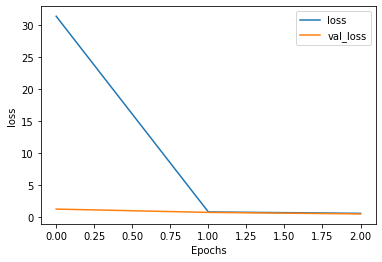

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4634 - accuracy: 0.0060 - val_loss: 0.4801 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3950 - accuracy: 0.0061 - val_loss: 0.5765 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4091 - accuracy: 0.0061 - val_loss: 0.4947 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-540.6870165528156, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1252.3268500194915, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1561.9747119357744, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-7100.594450080213, shape=(), dtype=float64)
test dates 2019-01-03~2019-01-03
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


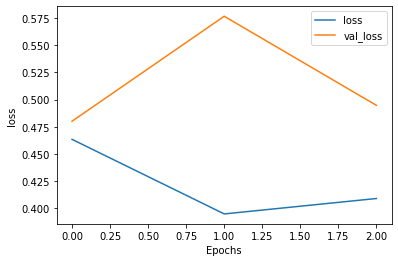

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3343 - accuracy: 0.0061 - val_loss: 0.4105 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3369 - accuracy: 0.0061 - val_loss: 0.3964 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3083 - accuracy: 0.0061 - val_loss: 0.3726 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-785.6298930656876, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1465.7385880891768, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1978.8586405524038, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3830.7135739120913, shape=(), dtype=float64)
test dates 2019-01-04~2019-01-04
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


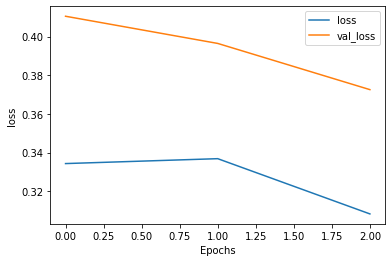

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3110 - accuracy: 0.0061 - val_loss: 0.3553 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3108 - accuracy: 0.0061 - val_loss: 0.3575 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3063 - accuracy: 0.0062 - val_loss: 0.3138 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1096.0499983423115, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1830.6982934252865, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3318.053522727994, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-514.5973105753909, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-01-07~2019-01-07
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


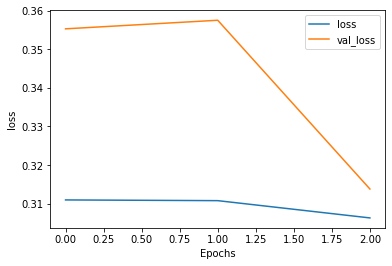

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2915 - accuracy: 0.0062 - val_loss: 0.4239 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2972 - accuracy: 0.0061 - val_loss: 0.3894 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2787 - accuracy: 0.0062 - val_loss: 0.2718 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-561.6803605214488, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1663.3549421707417, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2095.630265723634, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-10057.293899786679, shape=(), dtype=float64)
test dates 2019-01-08~2019-01-08
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


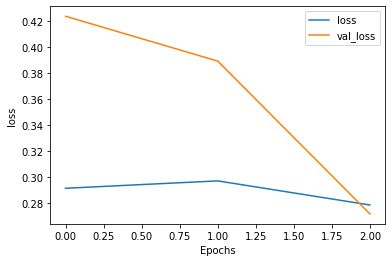

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2995 - accuracy: 0.0062 - val_loss: 0.3124 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2884 - accuracy: 0.0062 - val_loss: 0.5962 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2756 - accuracy: 0.0062 - val_loss: 1.3365 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-513.6350895448971, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1289.9925753646244, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1319.0046075276325, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1360.466111010126, shape=(), dtype=float64)
test dates 2019-01-09~2019-01-09
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


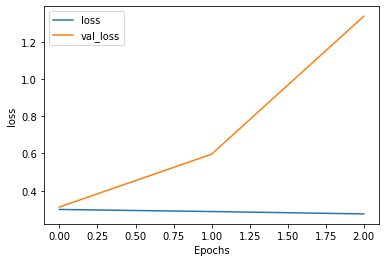

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3164 - accuracy: 0.0061 - val_loss: 0.7803 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2811 - accuracy: 0.0062 - val_loss: 0.3988 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3022 - accuracy: 0.0062 - val_loss: 0.3732 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1647.9911436046377, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1775.9436256818474, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2485.29327807375, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1641.6274007277993, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-01-10~2019-01-10
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


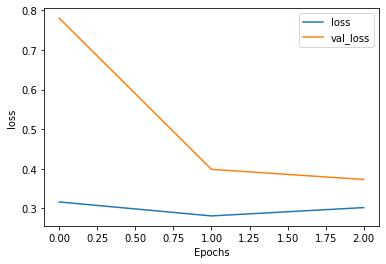

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2500 - accuracy: 0.0062 - val_loss: 1.8399 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3370 - accuracy: 0.0062 - val_loss: 0.3698 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2600 - accuracy: 0.0062 - val_loss: 0.4724 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2198.656452278458, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5282.710999232939, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-729.823779892054, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-730.0833772827299, shape=(), dtype=float64)
test dates 2019-01-11~2019-01-11
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


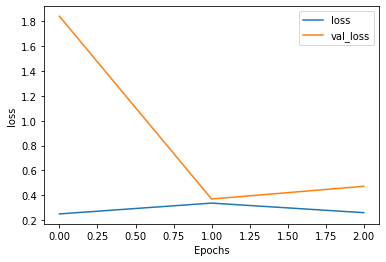

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2687 - accuracy: 0.0062 - val_loss: 0.4783 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2468 - accuracy: 0.0062 - val_loss: 0.3085 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2545 - accuracy: 0.0062 - val_loss: 0.3349 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-803.422268187086, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1520.2076759912572, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1527.7968035251624, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1538.559665818806, shape=(), dtype=float64)
test dates 2019-01-14~2019-01-14
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


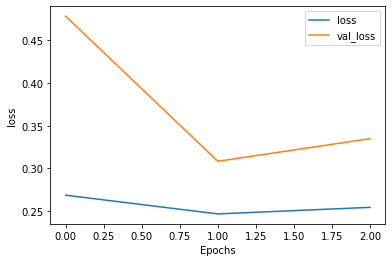

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2572 - accuracy: 0.0062 - val_loss: 0.2960 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2595 - accuracy: 0.0062 - val_loss: 0.3703 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3907 - accuracy: 0.0062 - val_loss: 2.4661 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1932.6125824998726, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1717.8356052087904, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1816.787282123243, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2011.831361738563, shape=(), dtype=float64)
test dates 2019-01-15~2019-01-15
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


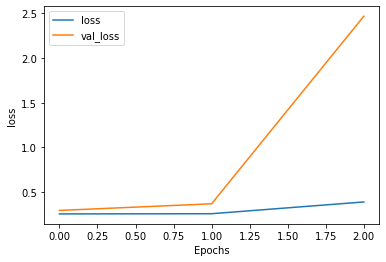

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4372 - accuracy: 0.0062 - val_loss: 0.2372 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2305 - accuracy: 0.0063 - val_loss: 0.3361 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2284 - accuracy: 0.0063 - val_loss: 0.3595 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3242.0607477568074, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5215.39742792991, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1221.5075738452776, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1338.9754907849403, shape=(), dtype=float64)
test dates 2019-01-16~2019-01-16
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


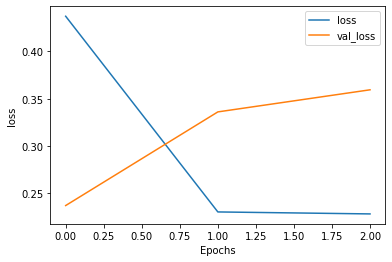

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2413 - accuracy: 0.0062 - val_loss: 0.3061 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2688 - accuracy: 0.0063 - val_loss: 0.3877 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2339 - accuracy: 0.0063 - val_loss: 0.2883 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2041.1711161132455, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2557.772199943568, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3202.1073202641664, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2767.3488927786366, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-01-17~2019-01-17
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


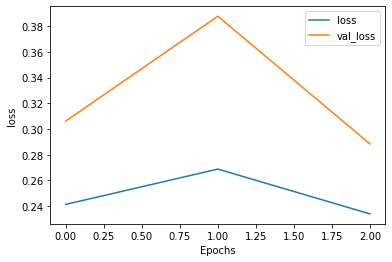

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3258 - accuracy: 0.0062 - val_loss: 0.4054 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2291 - accuracy: 0.0063 - val_loss: 0.2274 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2145 - accuracy: 0.0062 - val_loss: 0.2595 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3483.6119974551098, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3661.7012749657656, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-811.996782261695, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-812.1308578737285, shape=(), dtype=float64)
test dates 2019-01-18~2019-01-18
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


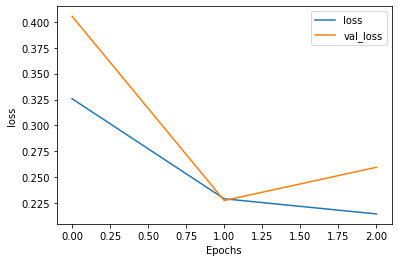

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2767 - accuracy: 0.0063 - val_loss: 0.2822 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2462 - accuracy: 0.0063 - val_loss: 0.3284 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2289 - accuracy: 0.0063 - val_loss: 0.2957 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-895.2375098060716, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1351.9229249520215, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1349.1383851230996, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1396.872611730075, shape=(), dtype=float64)
test dates 2019-01-21~2019-01-21
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


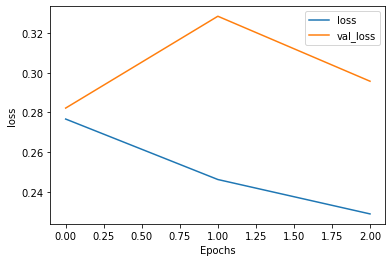

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2547 - accuracy: 0.0063 - val_loss: 0.2889 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2188 - accuracy: 0.0063 - val_loss: 0.2320 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2525 - accuracy: 0.0063 - val_loss: 0.2510 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1724.0184500308562, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3382.445052452184, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1037.5720972531353, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1059.4958269921624, shape=(), dtype=float64)
test dates 2019-01-22~2019-01-22
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


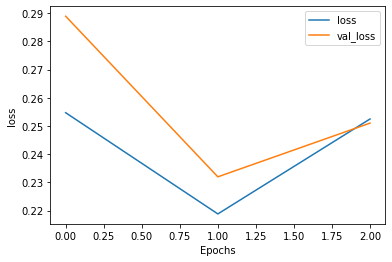

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2275 - accuracy: 0.0063 - val_loss: 0.1851 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2207 - accuracy: 0.0063 - val_loss: 0.2922 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2638 - accuracy: 0.0063 - val_loss: 0.2489 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1261.7851982715918, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1915.9074125647112, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1919.3539074856262, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1924.4456885593784, shape=(), dtype=float64)
test dates 2019-01-23~2019-01-23
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


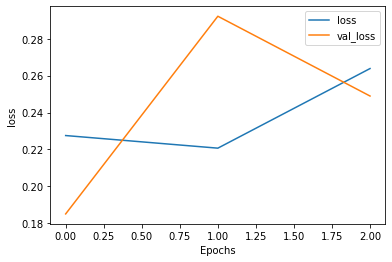

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2384 - accuracy: 0.0063 - val_loss: 0.2563 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3356 - accuracy: 0.0062 - val_loss: 0.3057 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7581 - accuracy: 0.0062 - val_loss: 1.2252 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2392.7195256087653, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2170.070178711647, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2253.5494962776547, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2385.9959574185464, shape=(), dtype=float64)
test dates 2019-01-24~2019-01-24
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


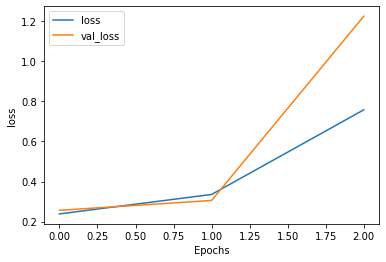

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3626 - accuracy: 0.0063 - val_loss: 0.3539 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2300 - accuracy: 0.0063 - val_loss: 0.3346 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2093 - accuracy: 0.0063 - val_loss: 0.2974 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3426.1317770251103, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1796.5187138901401, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1832.688311757063, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1888.7384452869185, shape=(), dtype=float64)
test dates 2019-01-25~2019-01-25
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


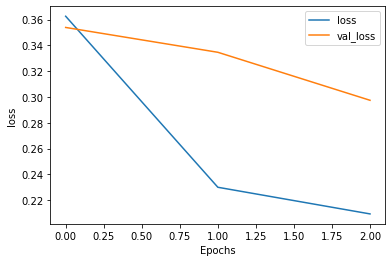

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2336 - accuracy: 0.0063 - val_loss: 0.2365 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2330 - accuracy: 0.0063 - val_loss: 0.3717 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2297 - accuracy: 0.0063 - val_loss: 0.3510 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2746.579931337116, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2690.645674607086, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2875.969927126661, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3192.073425710907, shape=(), dtype=float64)
test dates 2019-01-28~2019-01-28
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


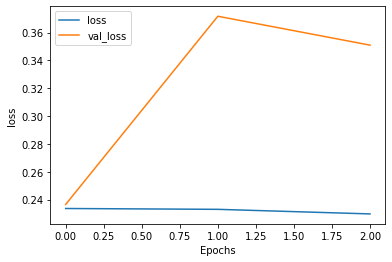

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2841 - accuracy: 0.0063 - val_loss: 0.3216 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2117 - accuracy: 0.0063 - val_loss: 0.3246 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2036 - accuracy: 0.0063 - val_loss: 0.2320 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-6152.208175798488, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3382.3373234300134, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3805.9507007936463, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5067.30548264342, shape=(), dtype=float64)
test dates 2019-01-29~2019-01-29
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


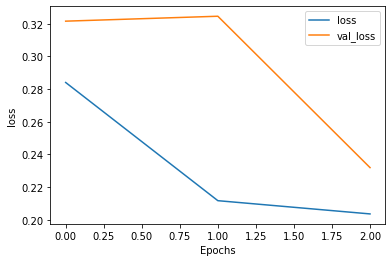

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3632 - accuracy: 0.0063 - val_loss: 0.4379 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7410 - accuracy: 0.0062 - val_loss: 0.5730 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2228 - accuracy: 0.0063 - val_loss: 0.3400 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-5109.389613209276, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2883.278927999068, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4094.8828149097335, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-965.6899934257765, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-01-30~2019-01-30
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


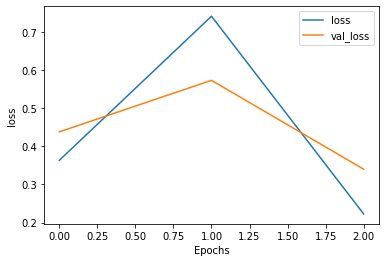

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1788 - accuracy: 0.0063 - val_loss: 0.3088 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1821 - accuracy: 0.0063 - val_loss: 0.2875 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1989 - accuracy: 0.0063 - val_loss: 0.3479 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-1132.701399053182, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3105.4092036887228, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3664.8998263199096, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-6654.578975031287, shape=(), dtype=float64)
test dates 2019-01-31~2019-01-31
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


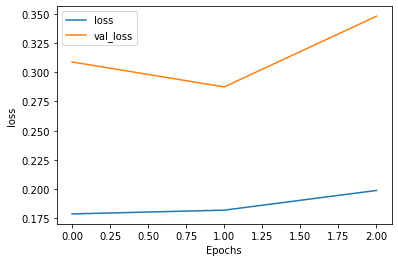

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2441 - accuracy: 0.0063 - val_loss: 0.4436 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2101 - accuracy: 0.0063 - val_loss: 0.2151 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1950 - accuracy: 0.0063 - val_loss: 0.3284 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-2434.5794697996657, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2187.8863695267905, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2131.0398665161856, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2300.2021481200572, shape=(), dtype=float64)
test dates 2019-02-01~2019-02-01
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


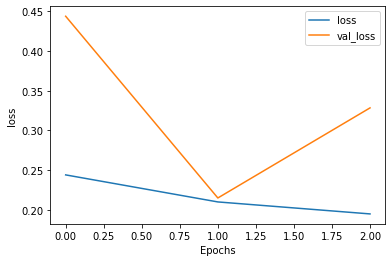

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.8043 - accuracy: 0.0062 - val_loss: 1.5572 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3806 - accuracy: 0.0063 - val_loss: 0.3947 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2387 - accuracy: 0.0063 - val_loss: 0.7253 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3143.093014293463, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4113.279003631003, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1684.4330439172063, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1780.8582908373712, shape=(), dtype=float64)
test dates 2019-02-07~2019-02-07
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


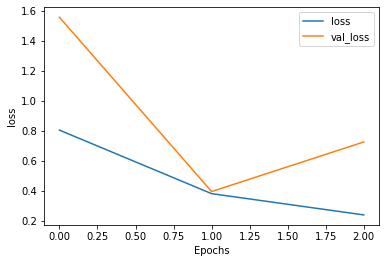

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2300 - accuracy: 0.0063 - val_loss: 0.2561 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1836 - accuracy: 0.0064 - val_loss: 0.3117 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1882 - accuracy: 0.0063 - val_loss: 0.5961 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2050.6472568095105, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2720.9510085073857, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2937.500275437993, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3389.0482933313647, shape=(), dtype=float64)
test dates 2019-02-08~2019-02-08
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


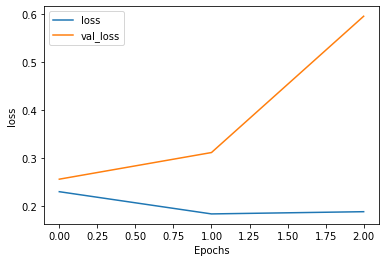

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1984 - accuracy: 0.0063 - val_loss: 0.3584 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4129 - accuracy: 0.0063 - val_loss: 0.2743 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1946 - accuracy: 0.0063 - val_loss: 0.8193 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-6822.740686207209, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2770.349875685477, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4458.229502502111, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-877.3709861375332, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-02-11~2019-02-11
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


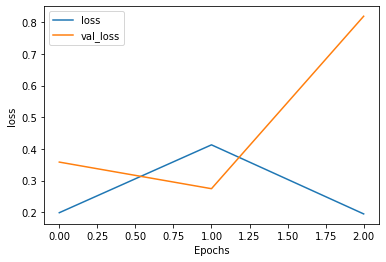

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 6.1269 - accuracy: 0.0059 - val_loss: 1.8207 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.0091 - accuracy: 0.0063 - val_loss: 0.7342 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4594 - accuracy: 0.0064 - val_loss: 0.4254 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-925.9449784407424, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2168.222977392697, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2170.4308408820675, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2173.7377443387772, shape=(), dtype=float64)
test dates 2019-02-12~2019-02-12
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


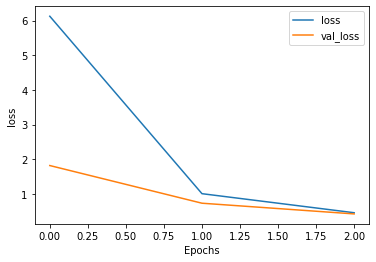

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2970 - accuracy: 0.0064 - val_loss: 0.4237 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2366 - accuracy: 0.0064 - val_loss: 0.2857 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2050 - accuracy: 0.0064 - val_loss: 0.3435 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-2739.882734794461, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2387.9238059471486, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2432.488527407287, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2493.7510414053195, shape=(), dtype=float64)
test dates 2019-02-13~2019-02-13
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


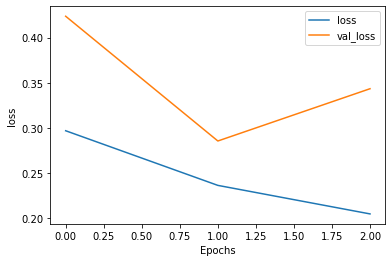

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2047 - accuracy: 0.0064 - val_loss: 0.2305 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1865 - accuracy: 0.0064 - val_loss: 0.1935 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1727 - accuracy: 0.0064 - val_loss: 0.6632 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3438.8054438882714, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1536.3415814978816, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1584.2683900788381, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1687.2324881666304, shape=(), dtype=float64)
test dates 2019-02-14~2019-02-14
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


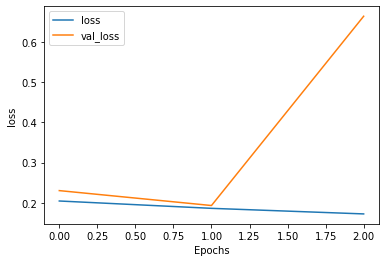

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1761 - accuracy: 0.0064 - val_loss: 0.1809 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1828 - accuracy: 0.0064 - val_loss: 0.2587 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1845 - accuracy: 0.0063 - val_loss: 0.1992 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2186.226293838334, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2658.4011432297625, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2769.4295356620146, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2945.055062493846, shape=(), dtype=float64)
test dates 2019-02-15~2019-02-15
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


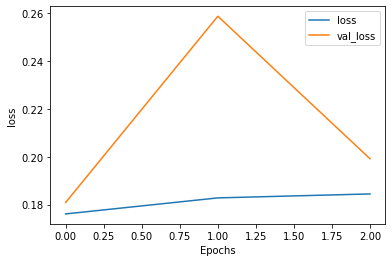

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1701 - accuracy: 0.0064 - val_loss: 0.4207 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3228 - accuracy: 0.0063 - val_loss: 0.2826 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1796 - accuracy: 0.0064 - val_loss: 0.2016 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-4112.113924885992, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2404.0213937793137, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2404.168456973387, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2404.6527551066333, shape=(), dtype=float64)
test dates 2019-02-18~2019-02-18
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


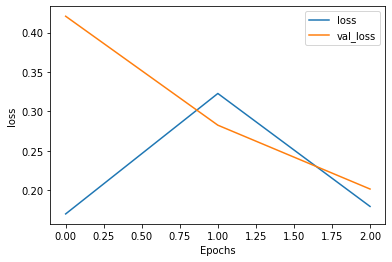

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1877 - accuracy: 0.0064 - val_loss: 1.7944 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1772 - accuracy: 0.0064 - val_loss: 0.8809 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3307 - accuracy: 0.0063 - val_loss: 1.7494 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3002.36995169671, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2888.7654185983483, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3244.6426450690024, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4188.044902473034, shape=(), dtype=float64)
test dates 2019-02-19~2019-02-19
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


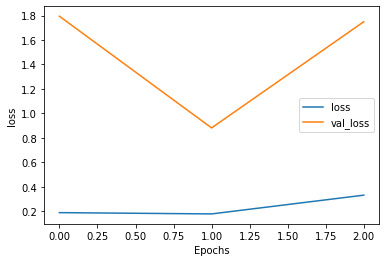

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1862 - accuracy: 0.0063 - val_loss: 1.1373 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6565 - accuracy: 0.0062 - val_loss: 3.3862 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4174 - accuracy: 0.0063 - val_loss: 0.2477 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-1018.419949775407, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2319.9047095879446, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2341.3378954723416, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2371.3622604470647, shape=(), dtype=float64)
test dates 2019-02-20~2019-02-20
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


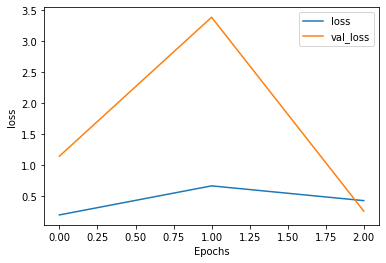

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2160 - accuracy: 0.0064 - val_loss: 0.2091 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1616 - accuracy: 0.0064 - val_loss: 0.2188 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2001 - accuracy: 0.0063 - val_loss: 0.3405 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2941.652557789612, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2569.8496407921984, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2636.8043177319496, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2735.4991320446893, shape=(), dtype=float64)
test dates 2019-02-21~2019-02-21
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


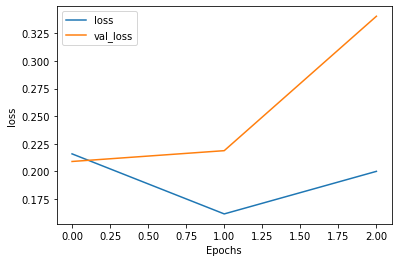

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3797 - accuracy: 0.0063 - val_loss: 0.3158 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2283 - accuracy: 0.0064 - val_loss: 0.3226 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1684 - accuracy: 0.0064 - val_loss: 0.2247 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3750.1961887880216, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2621.22676855863, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2758.263726490146, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3009.378149651251, shape=(), dtype=float64)
test dates 2019-02-22~2019-02-22
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


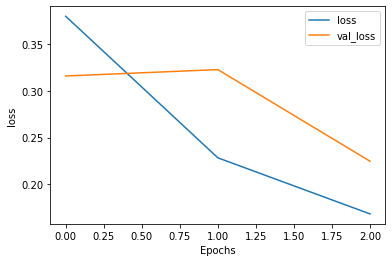

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1907 - accuracy: 0.0064 - val_loss: 0.3745 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1863 - accuracy: 0.0064 - val_loss: 0.3156 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.9277 - accuracy: 0.0062 - val_loss: 0.4584 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-4508.187086404974, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2836.416198647137, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3603.0877711783014, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-7260.916609089316, shape=(), dtype=float64)
test dates 2019-02-25~2019-02-25
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


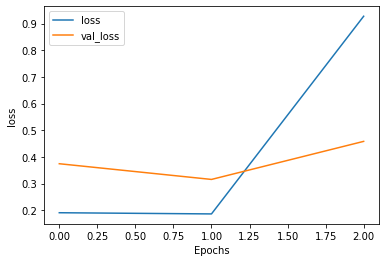

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2050 - accuracy: 0.0064 - val_loss: 0.4976 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2332 - accuracy: 0.0064 - val_loss: 0.4553 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5280 - accuracy: 0.0063 - val_loss: 0.3729 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-980.4774960429158, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2209.7280551325034, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2267.541353439336, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2352.3055536791653, shape=(), dtype=float64)
test dates 2019-02-26~2019-02-26
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


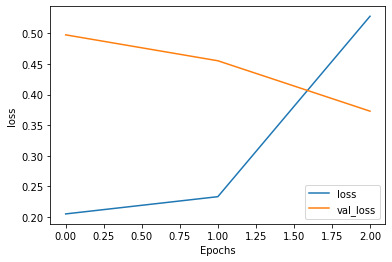

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2023 - accuracy: 0.0064 - val_loss: 0.6671 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1646 - accuracy: 0.0064 - val_loss: 0.6060 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1599 - accuracy: 0.0064 - val_loss: 0.4708 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3102.4047000912155, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3310.3825580344123, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4419.594520430673, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2416.918377174914, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-02-27~2019-02-27
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


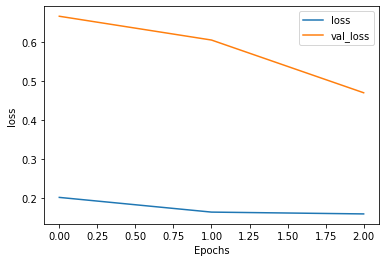

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1539 - accuracy: 0.0064 - val_loss: 0.4001 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1966 - accuracy: 0.0064 - val_loss: 0.5781 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1676 - accuracy: 0.0064 - val_loss: 0.5251 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2912.4011866469596, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2385.2554878359324, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2391.4830371171374, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2400.398219941789, shape=(), dtype=float64)
test dates 2019-02-28~2019-02-28
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


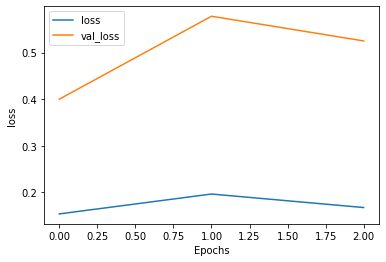

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.8648 - accuracy: 0.0063 - val_loss: 0.4518 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2439 - accuracy: 0.0064 - val_loss: 3.2350 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5212 - accuracy: 0.0063 - val_loss: 0.5616 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3069.935776348101, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3143.2653967493015, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3776.6728820645085, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-7630.880280096457, shape=(), dtype=float64)
test dates 2019-03-04~2019-03-04
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


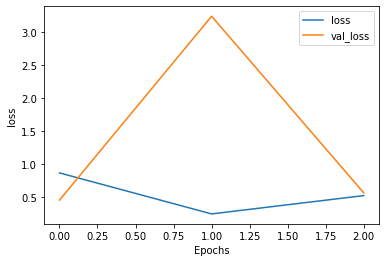

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1564 - accuracy: 0.0064 - val_loss: 0.3622 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1588 - accuracy: 0.0064 - val_loss: 0.4786 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2253 - accuracy: 0.0064 - val_loss: 0.5220 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-790.2072910549578, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2300.68598610151, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2459.2798798891636, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2746.9802457971073, shape=(), dtype=float64)
test dates 2019-03-05~2019-03-05
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


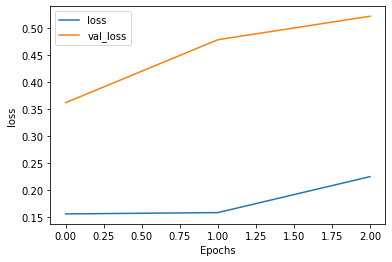

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1529 - accuracy: 0.0064 - val_loss: 1.0707 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1807 - accuracy: 0.0064 - val_loss: 1.0660 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1768 - accuracy: 0.0064 - val_loss: 5.6510 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-4390.010637179569, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2985.632782086821, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4578.812248941572, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1693.301900023057, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-03-06~2019-03-06
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


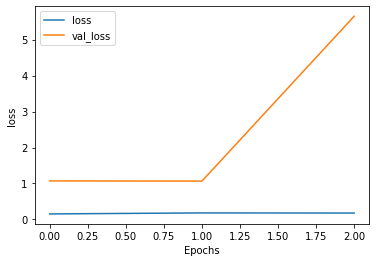

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.1170 - accuracy: 0.0063 - val_loss: 0.7146 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1771 - accuracy: 0.0064 - val_loss: 0.9456 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1657 - accuracy: 0.0064 - val_loss: 1.2780 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1884.403709466503, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3081.384411945919, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-9248.407384436527, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1103.4378389122746, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-03-07~2019-03-07
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtyp

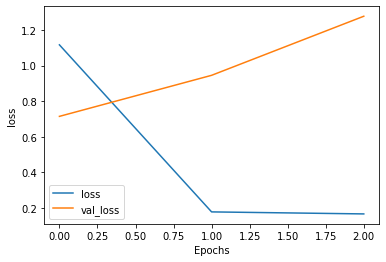

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.6295 - accuracy: 0.0059 - val_loss: 1.3703 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3908 - accuracy: 0.0063 - val_loss: 0.6585 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2456 - accuracy: 0.0063 - val_loss: 0.5951 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-1186.1734784812886, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1817.2518086001282, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1823.0126118100693, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1833.790153063625, shape=(), dtype=float64)
test dates 2019-03-08~2019-03-08
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


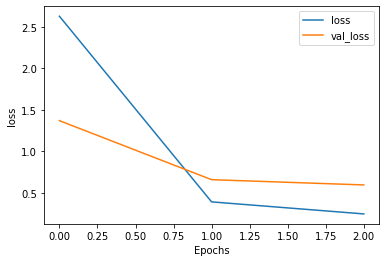

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2025 - accuracy: 0.0064 - val_loss: 0.2239 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1857 - accuracy: 0.0064 - val_loss: 0.3050 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1687 - accuracy: 0.0064 - val_loss: 0.3051 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2403.7669098738224, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4637.26662973445, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1054.3529134146581, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1054.2921159127543, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-03-11~2019-03-11
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dty

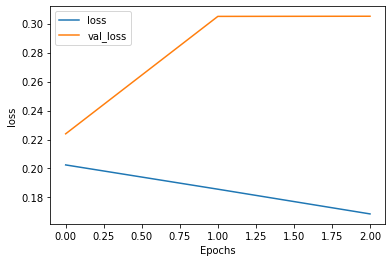

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1727 - accuracy: 0.0064 - val_loss: 0.2149 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2250 - accuracy: 0.0064 - val_loss: 1.3150 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2572 - accuracy: 0.0064 - val_loss: 0.2315 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1217.4050043037228, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3064.0536920520904, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3369.2357322248945, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4026.3577210614962, shape=(), dtype=float64)
test dates 2019-03-12~2019-03-12
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


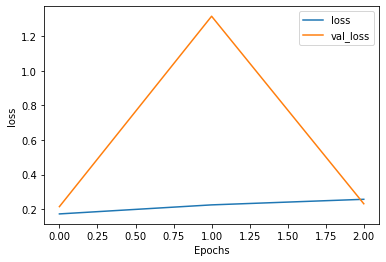

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1536 - accuracy: 0.0064 - val_loss: 0.4311 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1629 - accuracy: 0.0064 - val_loss: 1.2593 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1757 - accuracy: 0.0064 - val_loss: 0.4474 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-18745.108943283274, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3391.815054309134, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-8919.15921699172, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-873.6177691820358, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-03-13~2019-03-13
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype

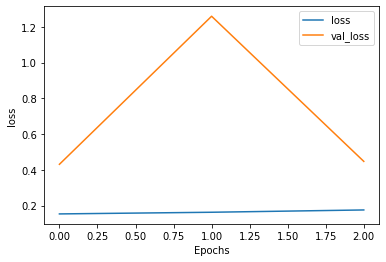

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1738 - accuracy: 0.0064 - val_loss: 0.7430 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1743 - accuracy: 0.0064 - val_loss: 0.6019 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2532 - accuracy: 0.0064 - val_loss: 0.5640 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-940.4093454655945, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2302.080798048572, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2302.829950908193, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2304.6255974146516, shape=(), dtype=float64)
test dates 2019-03-14~2019-03-14
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


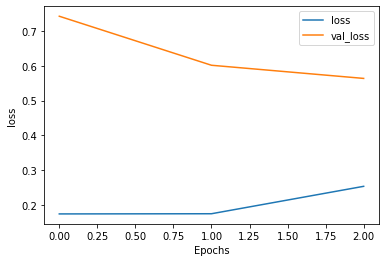

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1705 - accuracy: 0.0065 - val_loss: 0.3841 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1627 - accuracy: 0.0065 - val_loss: 0.4063 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2488 - accuracy: 0.0064 - val_loss: 0.4526 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2880.8253969574494, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2516.349168160926, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2516.611093594613, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2517.2769827129687, shape=(), dtype=float64)
test dates 2019-03-15~2019-03-15
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


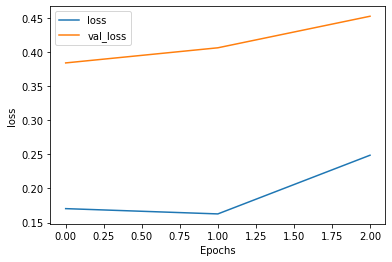

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1765 - accuracy: 0.0064 - val_loss: 0.2843 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1821 - accuracy: 0.0064 - val_loss: 0.2373 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1706 - accuracy: 0.0065 - val_loss: 0.3276 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3204.775267478479, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2841.41770510652, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3058.2000318439646, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3465.721324087181, shape=(), dtype=float64)
test dates 2019-03-18~2019-03-18
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


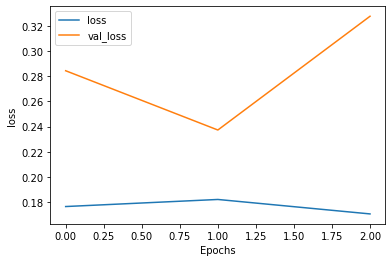

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2441 - accuracy: 0.0064 - val_loss: 0.3357 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1845 - accuracy: 0.0065 - val_loss: 0.1998 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1731 - accuracy: 0.0065 - val_loss: 0.1719 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-6970.434670483839, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2634.305861618494, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2645.657183541715, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2661.960733887785, shape=(), dtype=float64)
test dates 2019-03-19~2019-03-19
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


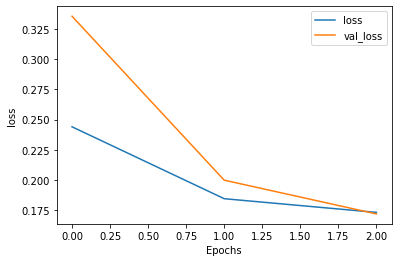

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.8013 - accuracy: 0.0063 - val_loss: 1.0213 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2956 - accuracy: 0.0064 - val_loss: 0.3124 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1742 - accuracy: 0.0065 - val_loss: 0.1737 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3336.9670339607424, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2812.8877212145067, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3084.924107430581, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3647.4596730982485, shape=(), dtype=float64)
test dates 2019-03-20~2019-03-20
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


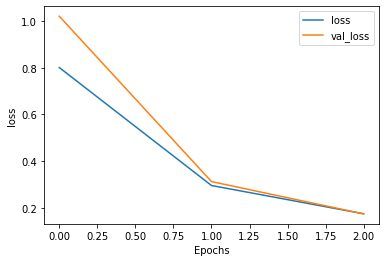

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1707 - accuracy: 0.0065 - val_loss: 0.2336 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1563 - accuracy: 0.0065 - val_loss: 0.1339 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1682 - accuracy: 0.0065 - val_loss: 0.4093 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-10063.0642582776, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3061.8027152679088, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3537.304180959157, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5248.105160930812, shape=(), dtype=float64)
test dates 2019-03-21~2019-03-21
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


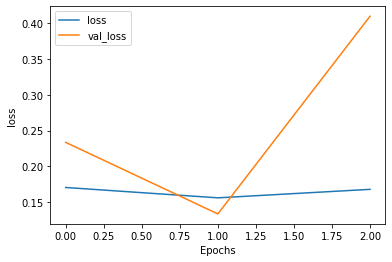

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2963 - accuracy: 0.0064 - val_loss: 1.5563 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2871 - accuracy: 0.0064 - val_loss: 0.3693 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1816 - accuracy: 0.0065 - val_loss: 0.3248 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-870.2435881571523, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2184.605993958426, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2186.8372717673715, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2190.229069822609, shape=(), dtype=float64)
test dates 2019-03-22~2019-03-22
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


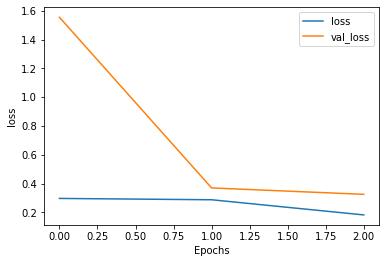

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1593 - accuracy: 0.0065 - val_loss: 0.9192 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1664 - accuracy: 0.0065 - val_loss: 0.8681 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2254 - accuracy: 0.0064 - val_loss: 2.2797 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-2541.898883072925, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4274.278467789564, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1252.8074580382627, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1252.8259617160218, shape=(), dtype=float64)
test dates 2019-03-25~2019-03-25
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


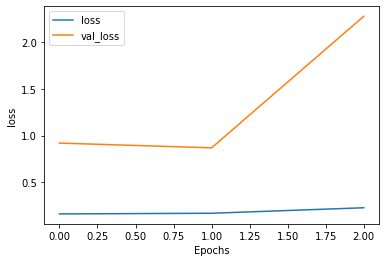

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2675 - accuracy: 0.0065 - val_loss: 0.5538 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1721 - accuracy: 0.0065 - val_loss: 1.4479 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.9581 - accuracy: 0.0063 - val_loss: 1.4109 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1532.5592685850095, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2538.6050123451832, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2806.236571042913, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3378.057234889369, shape=(), dtype=float64)
test dates 2019-03-26~2019-03-26
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


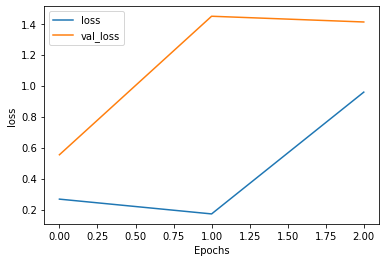

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3010 - accuracy: 0.0065 - val_loss: 0.3987 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1527 - accuracy: 0.0065 - val_loss: 0.2428 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1675 - accuracy: 0.0065 - val_loss: 0.2340 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-10842.779405640711, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2862.434849131476, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2951.6871053066784, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3097.7373425060964, shape=(), dtype=float64)
test dates 2019-03-27~2019-03-27
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


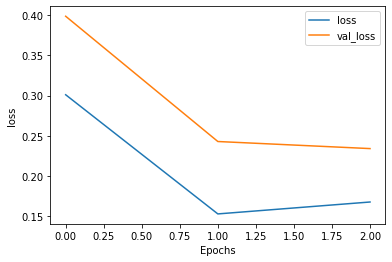

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1550 - accuracy: 0.0065 - val_loss: 0.1910 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1452 - accuracy: 0.0065 - val_loss: 0.2009 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1573 - accuracy: 0.0065 - val_loss: 0.7808 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-4236.640478938609, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3917.1319783588788, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-6957.514313861259, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-966.477267435295, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-03-28~2019-03-28
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype

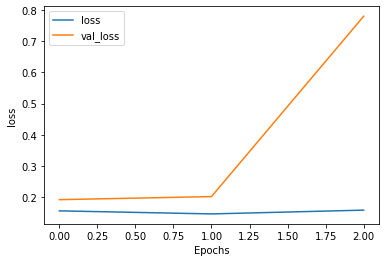

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1686 - accuracy: 0.0065 - val_loss: 0.2526 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.3243 - accuracy: 0.0063 - val_loss: 0.4722 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2128 - accuracy: 0.0065 - val_loss: 0.2003 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-998.7923417854022, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2659.868278070457, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4195.4178338555175, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1537.1748417272383, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-03-29~2019-03-29
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


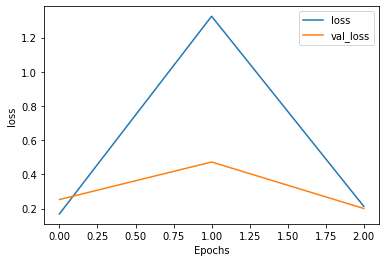

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1576 - accuracy: 0.0065 - val_loss: 0.7621 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1602 - accuracy: 0.0065 - val_loss: 0.1944 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1514 - accuracy: 0.0065 - val_loss: 1.3179 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-1715.994695020885, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2808.3770203983204, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2917.4245035313625, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3097.1051758101403, shape=(), dtype=float64)
test dates 2019-04-01~2019-04-01
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


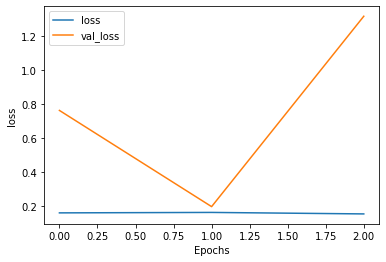

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2051 - accuracy: 0.0065 - val_loss: 0.2701 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1383 - accuracy: 0.0065 - val_loss: 0.6167 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2333 - accuracy: 0.0065 - val_loss: 0.6575 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-4648.587316376004, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-10050.594201054515, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1256.9948787161134, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1256.943792323047, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-04-02~2019-04-02
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dty

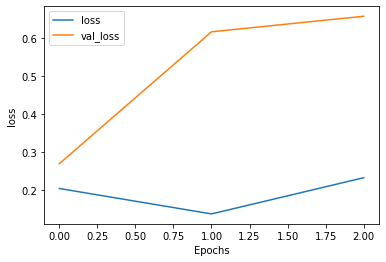

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2446 - accuracy: 0.0065 - val_loss: 0.2755 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1455 - accuracy: 0.0065 - val_loss: 0.5483 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4673 - accuracy: 0.0064 - val_loss: 0.3909 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1442.6970765952694, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2584.1684924863484, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2589.6798749368722, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2597.874636056114, shape=(), dtype=float64)
test dates 2019-04-03~2019-04-03
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


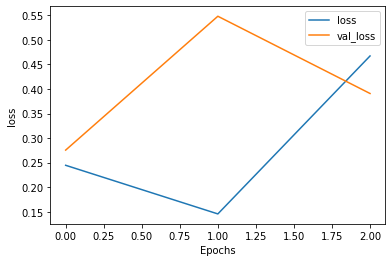

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1538 - accuracy: 0.0065 - val_loss: 0.2870 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1438 - accuracy: 0.0065 - val_loss: 0.2217 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1697 - accuracy: 0.0065 - val_loss: 0.3155 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3505.7795627388523, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3457.066300612401, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4562.959045390845, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-6096.34329594379, shape=(), dtype=float64)
test dates 2019-04-04~2019-04-04
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


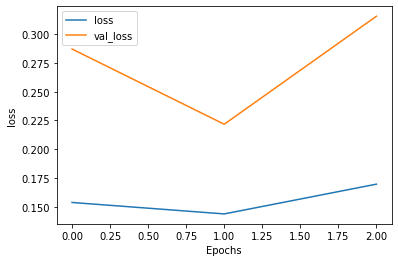

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1881 - accuracy: 0.0065 - val_loss: 0.9186 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2279 - accuracy: 0.0065 - val_loss: 0.2765 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1461 - accuracy: 0.0065 - val_loss: 0.3465 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3691.4757025861554, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3710.549600409883, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2572.415183037894, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1168.2397223744701, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-04-05~2019-04-05
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


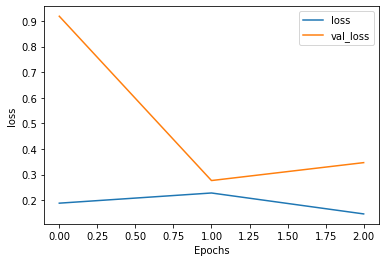

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3771 - accuracy: 0.0065 - val_loss: 0.1520 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.1881 - accuracy: 0.0064 - val_loss: 0.7685 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2556 - accuracy: 0.0065 - val_loss: 0.1889 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1173.235252551917, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4048.3133498248626, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5848.979660105562, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-988.7623588134231, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-04-08~2019-04-08
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtyp

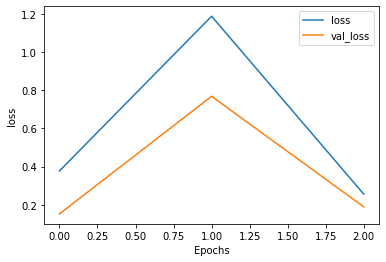

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1976 - accuracy: 0.0065 - val_loss: 0.2201 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2039 - accuracy: 0.0065 - val_loss: 0.3934 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1482 - accuracy: 0.0066 - val_loss: 0.1250 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-1023.087734008308, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-6421.600435494826, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1467.9761282274037, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1305.2570238841136, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-04-09~2019-04-09
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


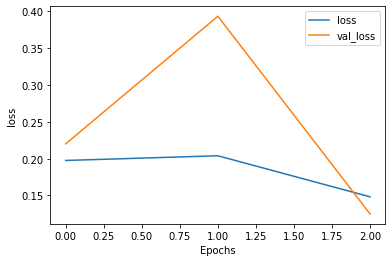

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1390 - accuracy: 0.0066 - val_loss: 1.0697 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1467 - accuracy: 0.0065 - val_loss: 1.0761 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1476 - accuracy: 0.0065 - val_loss: 1.0480 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-1169.9117100054661, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2615.8958328899403, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2793.0458371541517, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3113.1319447797564, shape=(), dtype=float64)
test dates 2019-04-10~2019-04-10
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


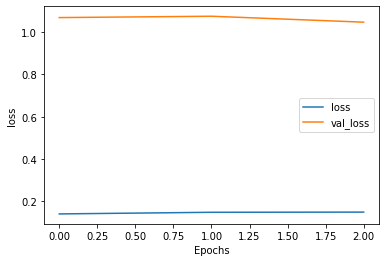

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4564 - accuracy: 0.0065 - val_loss: 0.4879 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1368 - accuracy: 0.0065 - val_loss: 0.3792 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1454 - accuracy: 0.0065 - val_loss: 1.1600 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-5102.0903057594405, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2230.718556317818, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2253.2157788345057, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2288.931268791666, shape=(), dtype=float64)
test dates 2019-04-11~2019-04-11
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


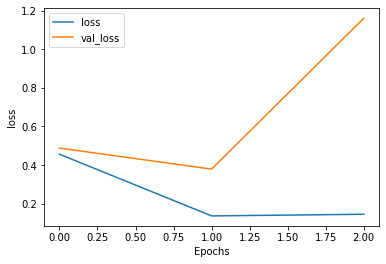

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1766 - accuracy: 0.0065 - val_loss: 0.4790 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2547 - accuracy: 0.0065 - val_loss: 6.9928 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 3.1621 - accuracy: 0.0061 - val_loss: 0.7682 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2961.5236114339527, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1508.0300780284006, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1535.8894209447558, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1606.19393283667, shape=(), dtype=float64)
test dates 2019-04-12~2019-04-12
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


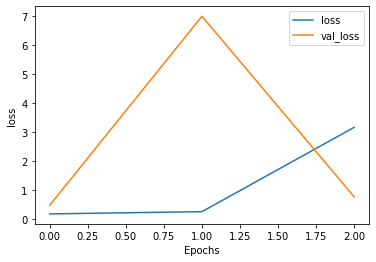

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3525 - accuracy: 0.0065 - val_loss: 0.6465 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2126 - accuracy: 0.0065 - val_loss: 0.4303 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1659 - accuracy: 0.0065 - val_loss: 0.5041 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-2021.1525557880268, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3465.7345115339494, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1290.019191041797, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1167.1889746506206, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-04-15~2019-04-15
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


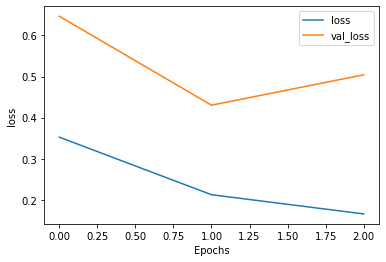

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1464 - accuracy: 0.0065 - val_loss: 0.2563 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1366 - accuracy: 0.0065 - val_loss: 0.2762 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1399 - accuracy: 0.0065 - val_loss: 0.2425 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-1327.2146278696773, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2353.3991321519356, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2398.080461251596, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2466.3986589992815, shape=(), dtype=float64)
test dates 2019-04-16~2019-04-16
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


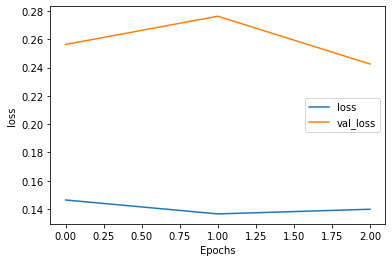

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1635 - accuracy: 0.0065 - val_loss: 0.3540 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1480 - accuracy: 0.0065 - val_loss: 0.2710 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1227 - accuracy: 0.0066 - val_loss: 0.1715 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3391.0931635109464, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5100.62811512706, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1149.4114572934022, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1150.9500025416153, shape=(), dtype=float64)
test dates 2019-04-17~2019-04-17
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


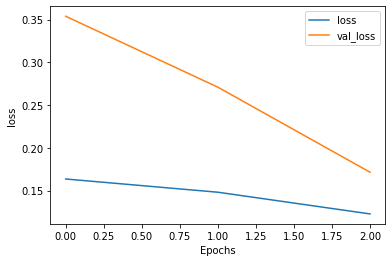

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1627 - accuracy: 0.0065 - val_loss: 0.3153 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1310 - accuracy: 0.0066 - val_loss: 0.2087 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1356 - accuracy: 0.0066 - val_loss: 0.2410 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-1269.9656297919764, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2455.39116378021, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2520.8054878251696, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2631.703614125417, shape=(), dtype=float64)
test dates 2019-04-18~2019-04-18
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


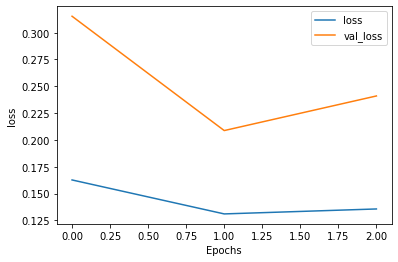

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1760 - accuracy: 0.0066 - val_loss: 0.2883 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1413 - accuracy: 0.0066 - val_loss: 0.3750 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1736 - accuracy: 0.0065 - val_loss: 0.3865 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3646.1921610719496, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2567.117438396588, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2676.5860778542924, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2832.104371532708, shape=(), dtype=float64)
test dates 2019-04-19~2019-04-19
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


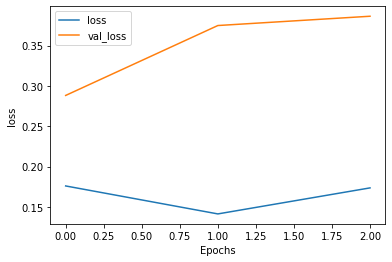

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 9.8941 - accuracy: 0.0065 - val_loss: 4.6625 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 6.6139 - accuracy: 0.0063 - val_loss: 3.2535 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 12.3898 - accuracy: 0.0064 - val_loss: 8.2712 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-4022.2773562778802, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2051.739898135059, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2051.5597204748196, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2052.6895621281274, shape=(), dtype=float64)
test dates 2019-04-22~2019-04-22
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


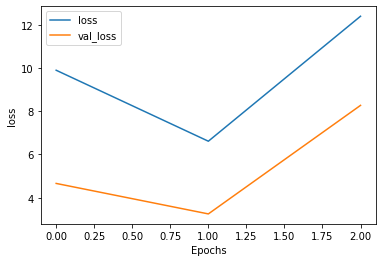

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 8.8470 - accuracy: 0.0062 - val_loss: 4.5710 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 5.7972 - accuracy: 0.0063 - val_loss: 2.7897 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 4.5977 - accuracy: 0.0060 - val_loss: 2.9822 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-2420.753811248254, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3015.4000827371806, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3376.029999644198, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4400.125537924355, shape=(), dtype=float64)
test dates 2019-04-23~2019-04-23
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


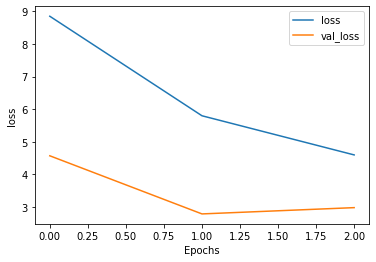

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.9918 - accuracy: 0.0064 - val_loss: 1.5449 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.2609 - accuracy: 0.0064 - val_loss: 1.0685 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.9143 - accuracy: 0.0065 - val_loss: 0.8344 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-1756.1903544171146, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1536.5105027399115, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1548.2805004732381, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1585.5705658111408, shape=(), dtype=float64)
test dates 2019-04-24~2019-04-24
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


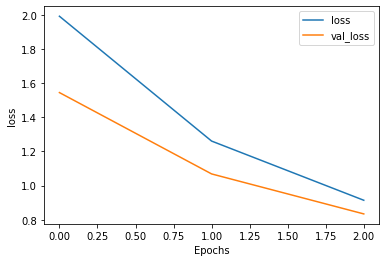

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7171 - accuracy: 0.0065 - val_loss: 0.6111 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5862 - accuracy: 0.0065 - val_loss: 0.5013 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4935 - accuracy: 0.0065 - val_loss: 0.4322 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-1874.1786435780386, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2529.2626864025206, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2581.5705071056955, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2664.010879021406, shape=(), dtype=float64)
test dates 2019-04-25~2019-04-25
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


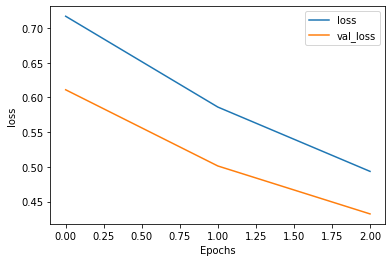

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4278 - accuracy: 0.0065 - val_loss: 0.3664 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3700 - accuracy: 0.0065 - val_loss: 0.3121 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3441 - accuracy: 0.0065 - val_loss: 0.3226 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-3616.516663214058, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2474.861556466107, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2522.9702838298954, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2594.6591053020347, shape=(), dtype=float64)
test dates 2019-04-26~2019-04-26
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


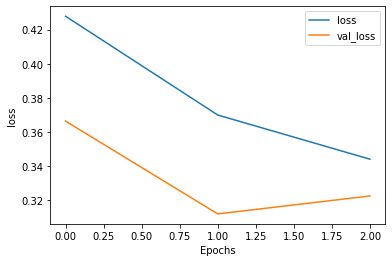

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3176 - accuracy: 0.0065 - val_loss: 0.2700 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2866 - accuracy: 0.0065 - val_loss: 0.2920 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2758 - accuracy: 0.0065 - val_loss: 0.2943 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3424.250415068829, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2445.839590065468, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2461.5279120976943, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2483.0496983659514, shape=(), dtype=float64)
test dates 2019-04-29~2019-04-29
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


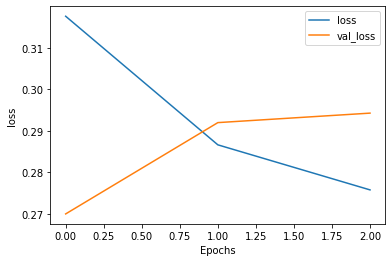

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2961 - accuracy: 0.0065 - val_loss: 0.4888 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2704 - accuracy: 0.0065 - val_loss: 0.3402 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2485 - accuracy: 0.0065 - val_loss: 0.2475 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-3398.5722521974394, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2716.6482581342784, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2791.254291612977, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2896.5692962029325, shape=(), dtype=float64)
test dates 2019-04-30~2019-04-30
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


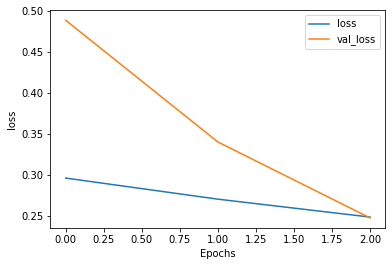

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2287 - accuracy: 0.0065 - val_loss: 0.3186 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2249 - accuracy: 0.0065 - val_loss: 0.2551 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2316 - accuracy: 0.0065 - val_loss: 0.2462 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-4314.601384459919, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2888.110015101077, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2924.34843293379, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2974.256734029941, shape=(), dtype=float64)
test dates 2019-05-02~2019-05-02
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


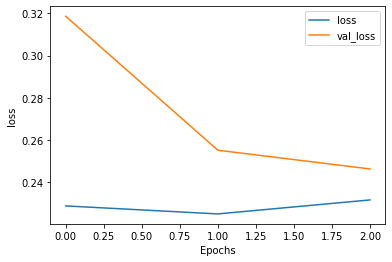

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2069 - accuracy: 0.0065 - val_loss: 0.2897 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2212 - accuracy: 0.0065 - val_loss: 0.2777 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2120 - accuracy: 0.0065 - val_loss: 0.3057 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3627.1227131346322, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2623.535467616644, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2626.6825348148673, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2631.400494980191, shape=(), dtype=float64)
test dates 2019-05-03~2019-05-03
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


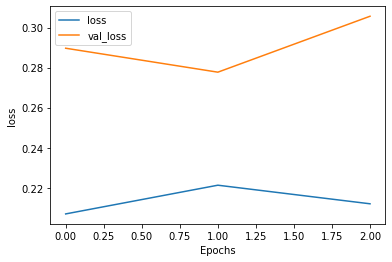

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2191 - accuracy: 0.0065 - val_loss: 0.3455 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2408 - accuracy: 0.0065 - val_loss: 0.3133 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2155 - accuracy: 0.0065 - val_loss: 0.3037 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-2999.2431482312863, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3059.4972866686185, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4323.434426073224, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2258.1755615192224, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-05-07~2019-05-07
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


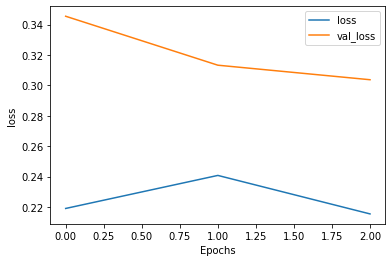

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2198 - accuracy: 0.0066 - val_loss: 0.2730 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2051 - accuracy: 0.0066 - val_loss: 0.1961 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2057 - accuracy: 0.0065 - val_loss: 0.2414 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-2632.647335968464, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2396.6255502094823, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2554.5111577791595, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2861.811758342026, shape=(), dtype=float64)
test dates 2019-05-08~2019-05-08
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


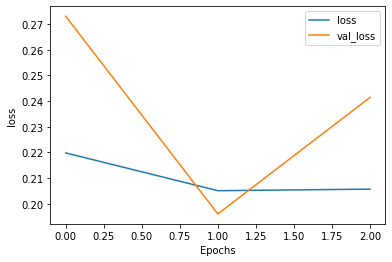

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.3169 - accuracy: 0.0064 - val_loss: 16.2485 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 7.7896 - accuracy: 0.0061 - val_loss: 4.6231 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 3.3760 - accuracy: 0.0065 - val_loss: 2.8865 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-4832.817725211055, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2446.210314489924, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2452.1305049958896, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2460.7873487273505, shape=(), dtype=float64)
test dates 2019-05-09~2019-05-09
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


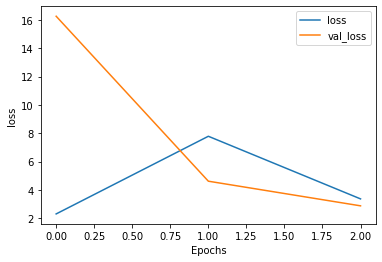

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.1597 - accuracy: 0.0065 - val_loss: 2.1961 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.7576 - accuracy: 0.0065 - val_loss: 1.6191 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.1830 - accuracy: 0.0065 - val_loss: 1.3427 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-3603.3272331449148, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-9256.466743078256, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1339.1163724876012, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1343.7763928075237, shape=(), dtype=float64)
test dates 2019-05-10~2019-05-10
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


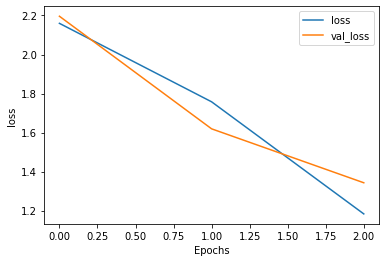

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.9417 - accuracy: 0.0065 - val_loss: 1.1446 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7586 - accuracy: 0.0066 - val_loss: 0.8882 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6408 - accuracy: 0.0066 - val_loss: 0.7846 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-1678.9344431662496, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3591.2235540497127, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4088.7460592991392, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5645.395138386311, shape=(), dtype=float64)
test dates 2019-05-13~2019-05-13
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


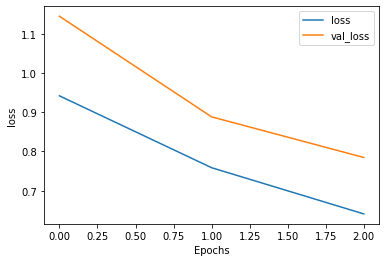

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5470 - accuracy: 0.0066 - val_loss: 0.5997 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4721 - accuracy: 0.0066 - val_loss: 0.6741 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5079 - accuracy: 0.0066 - val_loss: 0.4529 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-2183.646244412465, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1962.20171958644, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1987.7771792591045, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2043.009885001321, shape=(), dtype=float64)
test dates 2019-05-14~2019-05-14
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


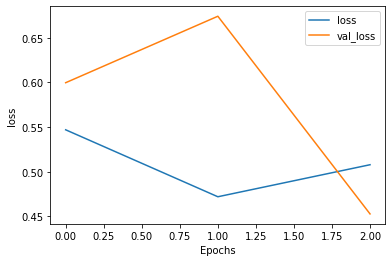

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3765 - accuracy: 0.0066 - val_loss: 0.3908 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3409 - accuracy: 0.0066 - val_loss: 0.3757 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3287 - accuracy: 0.0066 - val_loss: 0.3965 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-2561.5316492264446, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3044.1858175620964, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3043.931633336141, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3044.0354352298104, shape=(), dtype=float64)
test dates 2019-05-15~2019-05-15
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


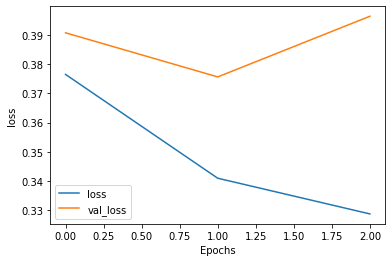

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2967 - accuracy: 0.0066 - val_loss: 0.3421 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2904 - accuracy: 0.0065 - val_loss: 0.3507 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3228 - accuracy: 0.0066 - val_loss: 0.3719 - val_accuracy: 0.0300
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3754.0165739245895, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3753.606931397955, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4572.712629549612, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-19199.8604737984, shape=(), dtype=float64)
test dates 2019-05-16~2019-05-16
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


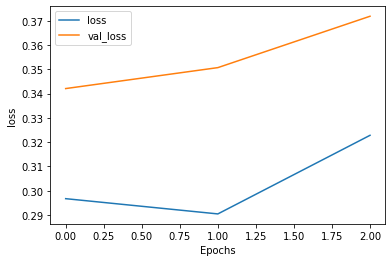

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2528 - accuracy: 0.0066 - val_loss: 0.4152 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2493 - accuracy: 0.0066 - val_loss: 0.3911 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2454 - accuracy: 0.0066 - val_loss: 0.2910 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-1061.9571825024375, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2516.596006871648, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2897.9093546376207, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4267.528209763093, shape=(), dtype=float64)
test dates 2019-05-17~2019-05-17
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


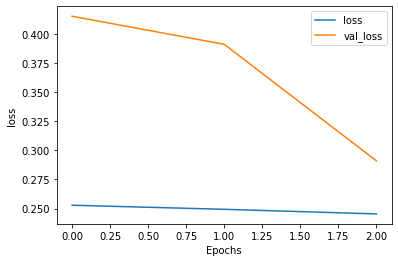

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2471 - accuracy: 0.0066 - val_loss: 0.3526 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2440 - accuracy: 0.0066 - val_loss: 0.8914 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3319 - accuracy: 0.0065 - val_loss: 0.3619 - val_accuracy: 0.0300
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1125.490698710289, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2933.338491799514, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2949.1366178524718, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2971.881069009461, shape=(), dtype=float64)
test dates 2019-05-20~2019-05-20
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


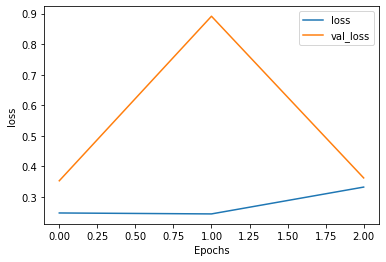

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2109 - accuracy: 0.0066 - val_loss: 0.2273 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2134 - accuracy: 0.0066 - val_loss: 0.2768 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2031 - accuracy: 0.0066 - val_loss: 0.4317 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3638.8588600987227, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4095.0609149324296, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4428.998914052805, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5112.605024792467, shape=(), dtype=float64)
test dates 2019-05-21~2019-05-21
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


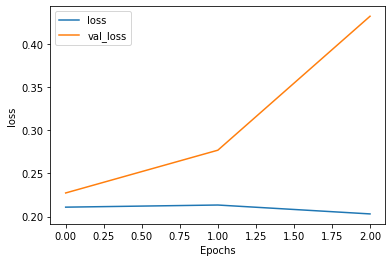

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2061 - accuracy: 0.0066 - val_loss: 0.3113 - val_accuracy: 0.0300
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2148 - accuracy: 0.0066 - val_loss: 0.4156 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2828 - accuracy: 0.0066 - val_loss: 0.4086 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-10730.60253425536, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4378.547410448816, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-7004.0155693147335, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1678.2092032018384, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-05-22~2019-05-22
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dty

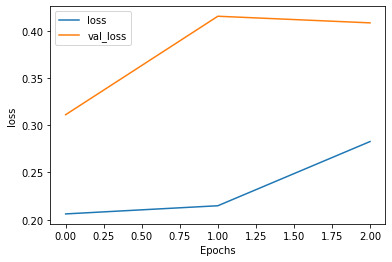

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2341 - accuracy: 0.0066 - val_loss: 0.3622 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1945 - accuracy: 0.0066 - val_loss: 0.6076 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2304 - accuracy: 0.0066 - val_loss: 0.3287 - val_accuracy: 0.0300
prediction2_MSE = tf.Tensor(-1788.0574455217816, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3150.957134466623, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3151.57851703447, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3153.432783065584, shape=(), dtype=float64)
test dates 2019-05-23~2019-05-23
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


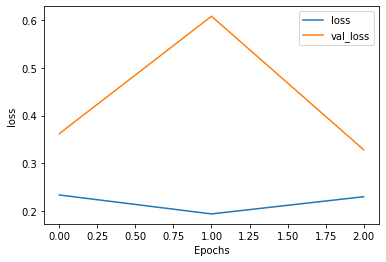

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2245 - accuracy: 0.0066 - val_loss: 0.3816 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.8540 - accuracy: 0.0063 - val_loss: 2.9986 - val_accuracy: 0.0300
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.8695 - accuracy: 0.0065 - val_loss: 0.5353 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3935.5112321293245, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3186.9524807270645, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3190.0787971860573, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3194.536151276625, shape=(), dtype=float64)
test dates 2019-05-24~2019-05-24
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


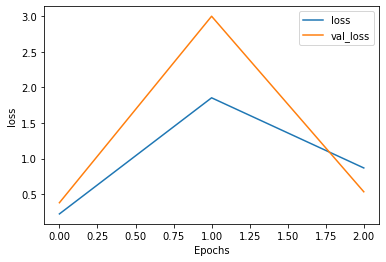

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3253 - accuracy: 0.0065 - val_loss: 0.3471 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2351 - accuracy: 0.0066 - val_loss: 0.3394 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2110 - accuracy: 0.0066 - val_loss: 0.3178 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-4159.416185473979, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3552.547205037204, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3839.284855541031, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4481.155875625099, shape=(), dtype=float64)
test dates 2019-05-27~2019-05-27
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


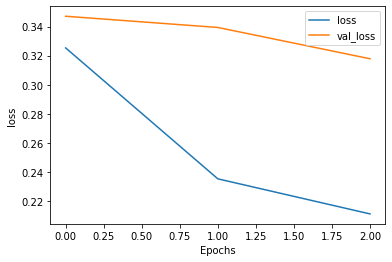

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1906 - accuracy: 0.0066 - val_loss: 0.3812 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3074 - accuracy: 0.0065 - val_loss: 0.3513 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1735 - accuracy: 0.0066 - val_loss: 0.4093 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-9972.82569060811, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3374.39034678708, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3409.343870667859, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3463.323036877384, shape=(), dtype=float64)
test dates 2019-05-28~2019-05-28
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


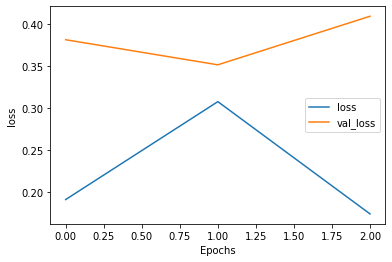

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1650 - accuracy: 0.0067 - val_loss: 0.3225 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.4263 - accuracy: 0.0064 - val_loss: 1.2183 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5522 - accuracy: 0.0065 - val_loss: 0.5357 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-4429.805375488371, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3514.575034878524, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3527.725736378112, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3544.761651749668, shape=(), dtype=float64)
test dates 2019-05-29~2019-05-29
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


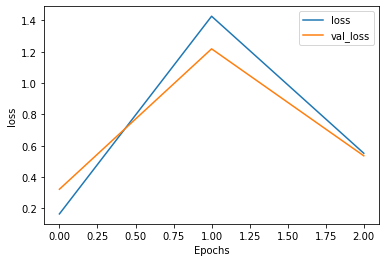

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2977 - accuracy: 0.0066 - val_loss: 0.4139 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2494 - accuracy: 0.0066 - val_loss: 0.3692 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1876 - accuracy: 0.0066 - val_loss: 0.2611 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-4864.1061908572865, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2735.616183751672, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2739.6538968794503, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2753.3498750313543, shape=(), dtype=float64)
test dates 2019-05-30~2019-05-30
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


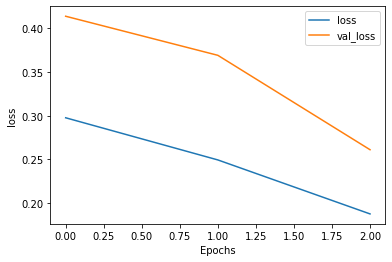

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1811 - accuracy: 0.0066 - val_loss: 0.2889 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1726 - accuracy: 0.0066 - val_loss: 0.1896 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1711 - accuracy: 0.0067 - val_loss: 0.2138 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3335.376048131346, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4198.123664211001, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4610.787011669834, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5484.039593616654, shape=(), dtype=float64)
test dates 2019-05-31~2019-05-31
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


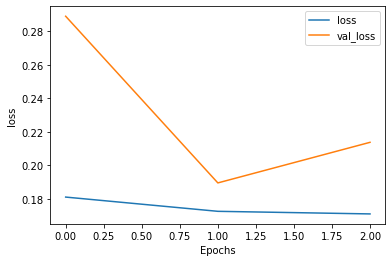

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1643 - accuracy: 0.0067 - val_loss: 0.2653 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1765 - accuracy: 0.0066 - val_loss: 0.2775 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1732 - accuracy: 0.0066 - val_loss: 0.1977 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-18814.436728576675, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5456.762703720974, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1605.023525018344, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1586.0899287235852, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-06-03~2019-06-03
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


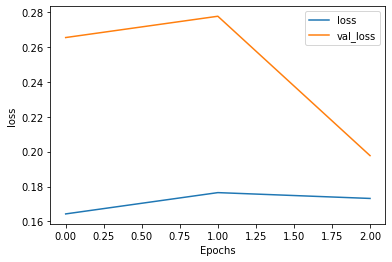

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2282 - accuracy: 0.0067 - val_loss: 0.3134 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1661 - accuracy: 0.0066 - val_loss: 0.3058 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1690 - accuracy: 0.0067 - val_loss: 0.3636 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-1699.8933619337638, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3706.0346049258133, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3828.7677177444334, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4024.474140034554, shape=(), dtype=float64)
test dates 2019-06-04~2019-06-04
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


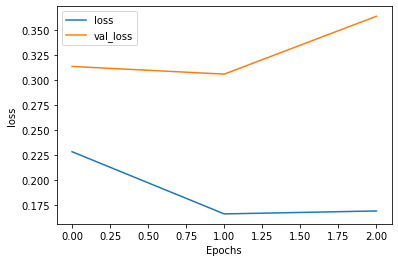

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1814 - accuracy: 0.0067 - val_loss: 0.3601 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2277 - accuracy: 0.0066 - val_loss: 0.3395 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1810 - accuracy: 0.0066 - val_loss: 0.5077 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-4843.59145473486, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3852.4021577657763, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4643.498261995154, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-10530.059987425107, shape=(), dtype=float64)
test dates 2019-06-05~2019-06-05
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


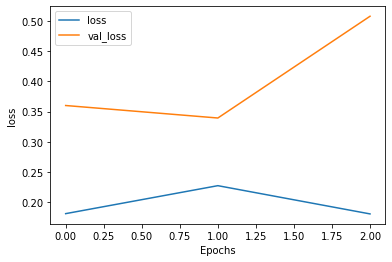

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.8510 - accuracy: 0.0065 - val_loss: 0.6509 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2761 - accuracy: 0.0067 - val_loss: 0.2018 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3682 - accuracy: 0.0066 - val_loss: 0.2615 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-1064.6121390162214, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2801.552815200975, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2802.986823915154, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2805.896050841218, shape=(), dtype=float64)
test dates 2019-06-07~2019-06-07
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


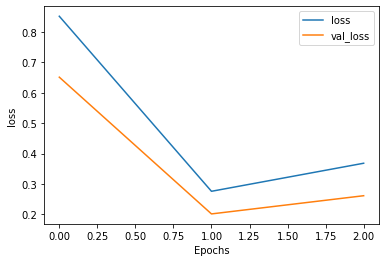

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1787 - accuracy: 0.0067 - val_loss: 0.2299 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1501 - accuracy: 0.0067 - val_loss: 0.1900 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2134 - accuracy: 0.0067 - val_loss: 0.1863 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3422.83642691924, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-6461.486530239567, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1347.518554014969, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1346.5702413248805, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-06-10~2019-06-10
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


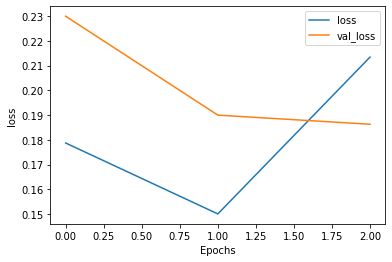

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1598 - accuracy: 0.0067 - val_loss: 0.3377 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1762 - accuracy: 0.0067 - val_loss: 0.4025 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1591 - accuracy: 0.0067 - val_loss: 0.2513 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-1299.5773498650944, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2439.179978700918, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2456.7918492931444, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2481.8985511755086, shape=(), dtype=float64)
test dates 2019-06-11~2019-06-11
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


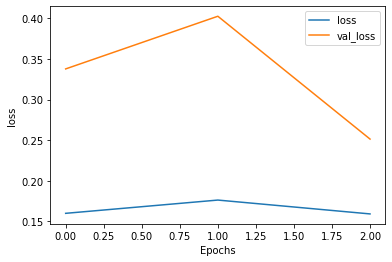

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1600 - accuracy: 0.0067 - val_loss: 0.5134 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1752 - accuracy: 0.0067 - val_loss: 0.2242 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1677 - accuracy: 0.0067 - val_loss: 0.2296 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-2929.8891848826192, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2870.781702200967, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3104.6835768497217, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3565.4262303630185, shape=(), dtype=float64)
test dates 2019-06-12~2019-06-12
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


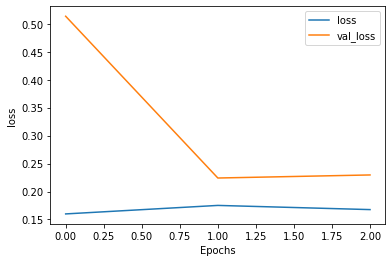

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5724 - accuracy: 0.0066 - val_loss: 0.3220 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1586 - accuracy: 0.0067 - val_loss: 0.2833 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1722 - accuracy: 0.0067 - val_loss: 0.5549 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-7335.993625688872, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3475.472497374783, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1166.2635250089356, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1023.4865438461326, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-06-13~2019-06-13
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


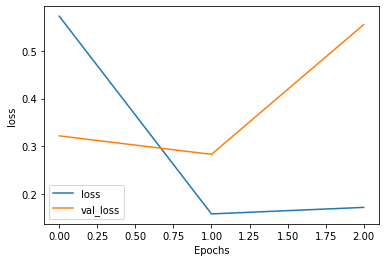

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1893 - accuracy: 0.0067 - val_loss: 1.2063 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2397 - accuracy: 0.0067 - val_loss: 0.2047 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1515 - accuracy: 0.0067 - val_loss: 0.2860 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-1038.9731983579902, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2417.308114724675, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2485.8938708657006, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2597.3049782531816, shape=(), dtype=float64)
test dates 2019-06-14~2019-06-14
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


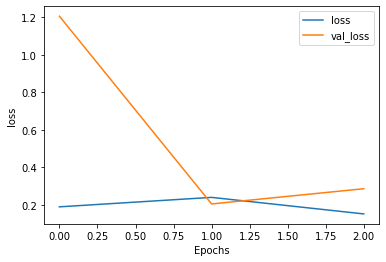

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1614 - accuracy: 0.0067 - val_loss: 0.7656 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1570 - accuracy: 0.0067 - val_loss: 0.5872 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1730 - accuracy: 0.0067 - val_loss: 0.6977 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-3451.7598388057977, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1518.3102676152105, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1516.6236307533054, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1537.5743840880798, shape=(), dtype=float64)
test dates 2019-06-17~2019-06-17
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


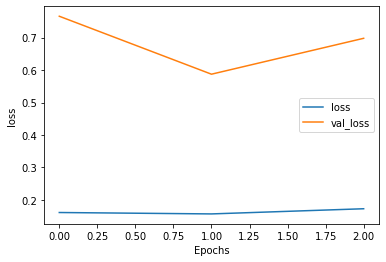

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2402 - accuracy: 0.0067 - val_loss: 0.6408 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2401 - accuracy: 0.0067 - val_loss: 0.9449 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1698 - accuracy: 0.0067 - val_loss: 0.7281 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1802.1897690687501, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4191.033893576708, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3497.836264834882, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-11579.729798079621, shape=(), dtype=float64)
test dates 2019-06-18~2019-06-18
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


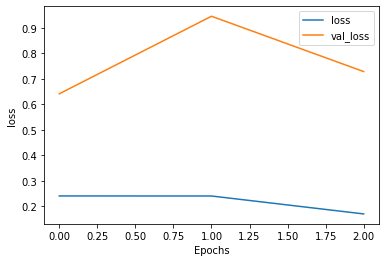

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.8179 - accuracy: 0.0065 - val_loss: 1.0677 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2180 - accuracy: 0.0067 - val_loss: 0.4001 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1689 - accuracy: 0.0067 - val_loss: 0.5841 - val_accuracy: 0.0200
prediction2_MSE = tf.Tensor(-767.4093787447943, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1715.185982186099, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1734.4256739748753, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1767.6662322959885, shape=(), dtype=float64)
test dates 2019-06-19~2019-06-19
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


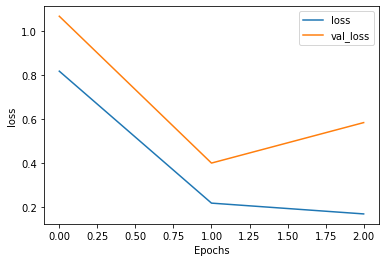

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1498 - accuracy: 0.0067 - val_loss: 0.5107 - val_accuracy: 0.0200
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1515 - accuracy: 0.0067 - val_loss: 0.7379 - val_accuracy: 0.0200
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1759 - accuracy: 0.0067 - val_loss: 0.5894 - val_accuracy: 0.0200
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2209.8967325166873, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2630.860198244585, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2693.6358133037515, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2779.0259125772473, shape=(), dtype=float64)
test dates 2019-06-20~2019-06-20
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


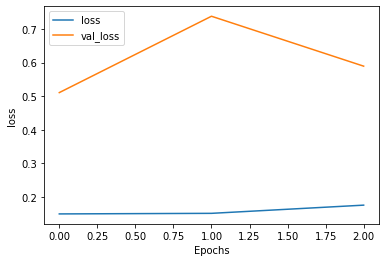

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1516 - accuracy: 0.0067 - val_loss: 0.4995 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4022 - accuracy: 0.0066 - val_loss: 0.5239 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1493 - accuracy: 0.0067 - val_loss: 0.5066 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3843.08372571143, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3970.1597350656566, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1053.154351436885, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1038.4387126232311, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-06-21~2019-06-21
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtyp

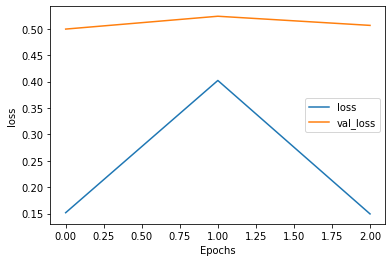

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2350 - accuracy: 0.0067 - val_loss: 0.3266 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1452 - accuracy: 0.0067 - val_loss: 0.2655 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1551 - accuracy: 0.0067 - val_loss: 0.3006 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1098.537902497239, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2559.2186085386893, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2616.2877605770477, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2699.2758306527708, shape=(), dtype=float64)
test dates 2019-06-24~2019-06-24
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


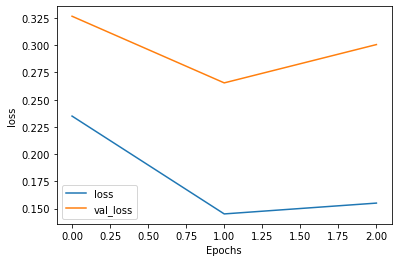

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1561 - accuracy: 0.0067 - val_loss: 0.3032 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2286 - accuracy: 0.0067 - val_loss: 0.3943 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1672 - accuracy: 0.0067 - val_loss: 0.2750 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3414.7805512022273, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2475.1913254695733, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2506.728781136992, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2546.1890142516368, shape=(), dtype=float64)
test dates 2019-06-25~2019-06-25
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


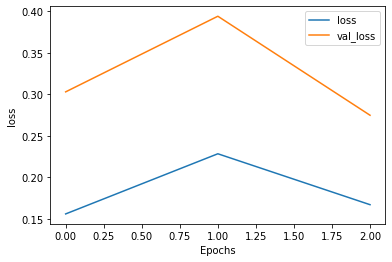

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1600 - accuracy: 0.0067 - val_loss: 0.2963 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1495 - accuracy: 0.0067 - val_loss: 0.3454 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.3812 - accuracy: 0.0065 - val_loss: 0.2865 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3272.0703931746716, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1692.1210416518295, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1719.488130068411, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1768.6897375374604, shape=(), dtype=float64)
test dates 2019-06-26~2019-06-26
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


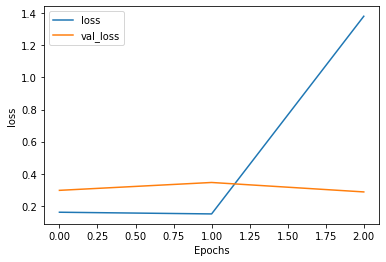

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1978 - accuracy: 0.0067 - val_loss: 0.4033 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1595 - accuracy: 0.0067 - val_loss: 0.2808 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3135 - accuracy: 0.0067 - val_loss: 0.2668 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2151.4636612172208, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2453.003519397476, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2452.9737365771844, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2453.3072057375316, shape=(), dtype=float64)
test dates 2019-06-27~2019-06-27
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


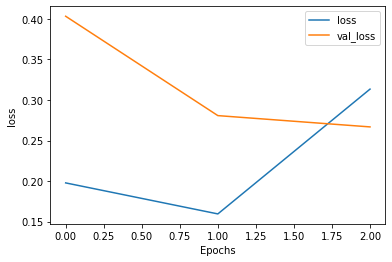

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1564 - accuracy: 0.0067 - val_loss: 0.2262 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1432 - accuracy: 0.0067 - val_loss: 0.2132 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1351 - accuracy: 0.0067 - val_loss: 0.2123 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3139.353278328664, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4110.576524286464, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1077.8593609839356, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1018.028937781329, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-06-28~2019-06-28
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


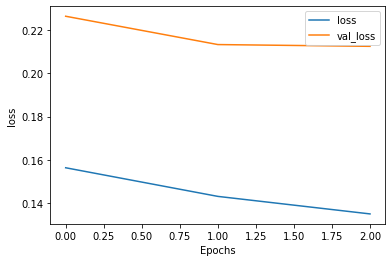

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1452 - accuracy: 0.0067 - val_loss: 0.1834 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1679 - accuracy: 0.0067 - val_loss: 0.2037 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6369 - accuracy: 0.0066 - val_loss: 0.1697 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1125.3806948339543, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-18840.422845835576, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1272.441302738332, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1273.6302099656195, shape=(), dtype=float64)
test dates 2019-07-01~2019-07-01
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


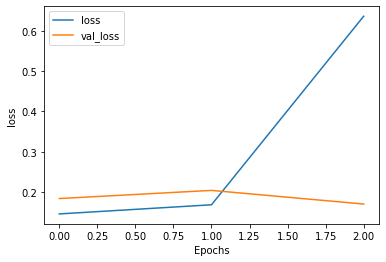

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1491 - accuracy: 0.0067 - val_loss: 0.1674 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2522 - accuracy: 0.0067 - val_loss: 0.3197 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1472 - accuracy: 0.0067 - val_loss: 0.1665 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1341.862066570189, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2280.817954876643, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2280.6600403710677, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2280.9678957032716, shape=(), dtype=float64)
test dates 2019-07-02~2019-07-02
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


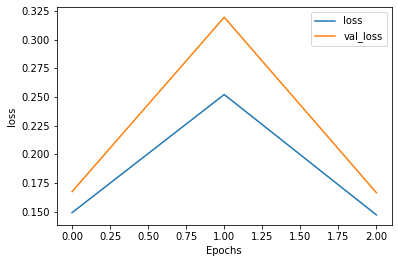

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1772 - accuracy: 0.0067 - val_loss: 0.1580 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1288 - accuracy: 0.0067 - val_loss: 0.2361 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1564 - accuracy: 0.0067 - val_loss: 0.2962 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2783.568613196123, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2388.70081617917, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2391.4748463118785, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2395.4169909743055, shape=(), dtype=float64)
test dates 2019-07-03~2019-07-03
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


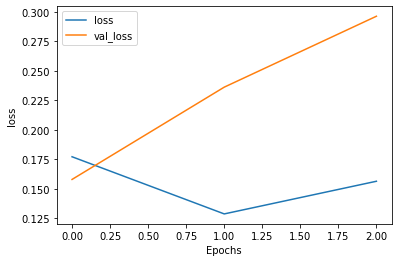

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1523 - accuracy: 0.0067 - val_loss: 0.2286 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1542 - accuracy: 0.0067 - val_loss: 0.2154 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1856 - accuracy: 0.0067 - val_loss: 0.1678 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3101.6151752623396, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1670.7738974417302, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1716.3420928095065, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1798.4213692954525, shape=(), dtype=float64)
test dates 2019-07-04~2019-07-04
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


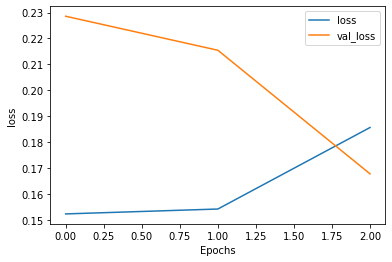

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1507 - accuracy: 0.0067 - val_loss: 0.2084 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.2386 - accuracy: 0.0062 - val_loss: 0.7866 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3921 - accuracy: 0.0066 - val_loss: 1.6103 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2251.8793792510974, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2464.5454866570676, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2468.011188936543, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2473.4163771124977, shape=(), dtype=float64)
test dates 2019-07-05~2019-07-05
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


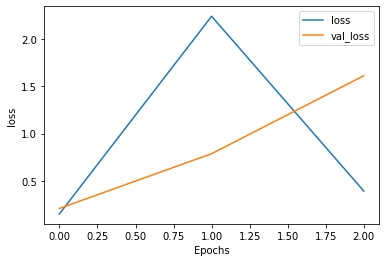

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.4165 - accuracy: 0.0065 - val_loss: 0.5913 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2824 - accuracy: 0.0067 - val_loss: 0.3759 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5928 - accuracy: 0.0066 - val_loss: 0.2784 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3076.0253541230086, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2465.182202479842, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2468.4352597928246, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2473.12394515994, shape=(), dtype=float64)
test dates 2019-07-08~2019-07-08
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


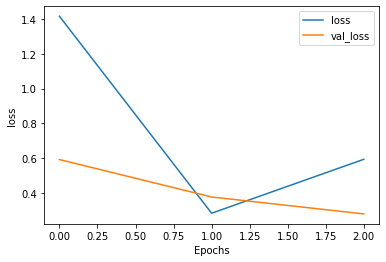

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2258 - accuracy: 0.0067 - val_loss: 0.3565 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1544 - accuracy: 0.0067 - val_loss: 0.3751 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1441 - accuracy: 0.0067 - val_loss: 0.3030 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2826.9199677539227, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2318.4918195002806, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2353.102501479953, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2402.9578981144828, shape=(), dtype=float64)
test dates 2019-07-09~2019-07-09
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


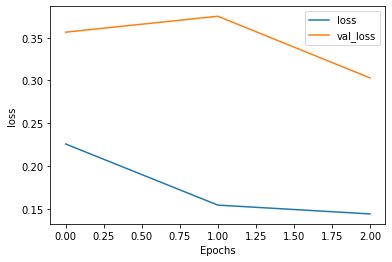

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2243 - accuracy: 0.0067 - val_loss: 0.5327 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1724 - accuracy: 0.0067 - val_loss: 0.3013 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1338 - accuracy: 0.0067 - val_loss: 0.2596 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2912.863477327345, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1518.0343661546299, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1182.9607033550908, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1193.3138221488448, shape=(), dtype=float64)
test dates 2019-07-10~2019-07-10
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


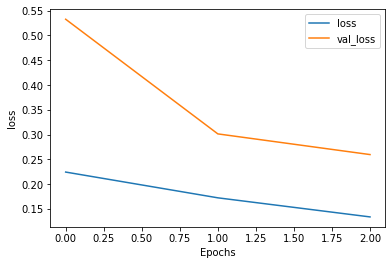

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1325 - accuracy: 0.0067 - val_loss: 0.2271 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1354 - accuracy: 0.0067 - val_loss: 0.2550 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1383 - accuracy: 0.0067 - val_loss: 0.2016 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1355.7937450111658, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5305.8336261150735, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1084.6689798366478, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1104.2453893474303, shape=(), dtype=float64)
test dates 2019-07-11~2019-07-11
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


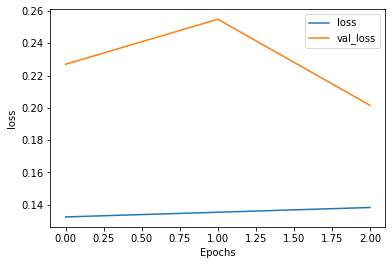

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1678 - accuracy: 0.0067 - val_loss: 0.2922 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1441 - accuracy: 0.0067 - val_loss: 0.1667 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1502 - accuracy: 0.0067 - val_loss: 0.2226 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1355.6882381806824, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2290.974402673815, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2331.2435418663417, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2393.700123541335, shape=(), dtype=float64)
test dates 2019-07-12~2019-07-12
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


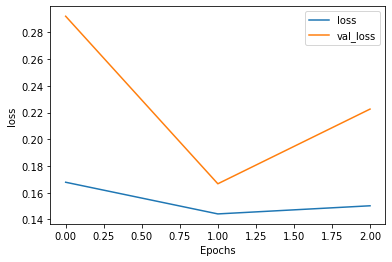

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1393 - accuracy: 0.0067 - val_loss: 0.2729 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1929 - accuracy: 0.0067 - val_loss: 2.1534 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.2757 - accuracy: 0.0063 - val_loss: 0.5459 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3221.704558754501, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2806.800159922137, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3201.2606171049233, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4360.852199974013, shape=(), dtype=float64)
test dates 2019-07-15~2019-07-15
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


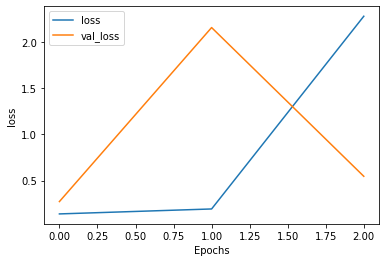

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2662 - accuracy: 0.0067 - val_loss: 0.2314 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1751 - accuracy: 0.0067 - val_loss: 0.2226 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1424 - accuracy: 0.0067 - val_loss: 0.1885 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-999.7066423947283, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2167.0295069601675, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2193.0458261720496, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2226.6243174497126, shape=(), dtype=float64)
test dates 2019-07-16~2019-07-16
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


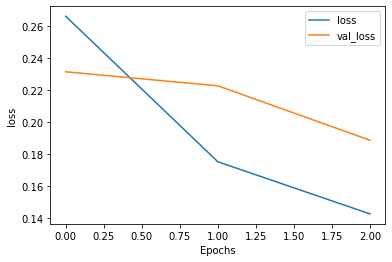

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1324 - accuracy: 0.0067 - val_loss: 0.1490 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1250 - accuracy: 0.0067 - val_loss: 0.1689 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1265 - accuracy: 0.0067 - val_loss: 0.1587 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2880.4830624137326, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2599.4976344126644, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2943.505079429311, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3879.0573859665624, shape=(), dtype=float64)
test dates 2019-07-17~2019-07-17
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


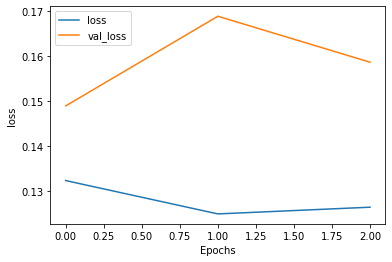

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1232 - accuracy: 0.0067 - val_loss: 0.1830 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1227 - accuracy: 0.0067 - val_loss: 0.1659 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1637 - accuracy: 0.0067 - val_loss: 0.1880 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1630.7368415007286, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2164.093878007219, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2178.4007173846235, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2197.8267849009153, shape=(), dtype=float64)
test dates 2019-07-18~2019-07-18
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


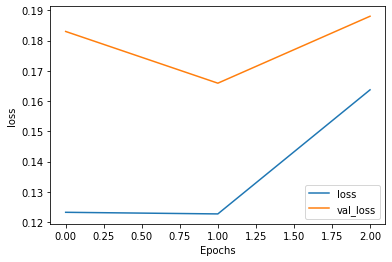

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1465 - accuracy: 0.0067 - val_loss: 0.1730 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1306 - accuracy: 0.0067 - val_loss: 0.1436 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1456 - accuracy: 0.0067 - val_loss: 0.1539 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2672.356659468207, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2338.829062466572, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2460.720794900302, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2744.6826127515897, shape=(), dtype=float64)
test dates 2019-07-19~2019-07-19
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


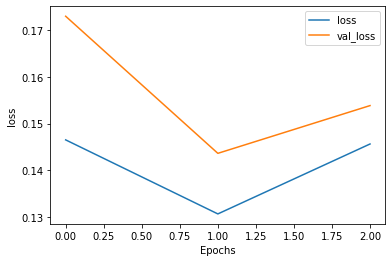

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1411 - accuracy: 0.0067 - val_loss: 0.1499 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1445 - accuracy: 0.0067 - val_loss: 0.1718 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1963 - accuracy: 0.0067 - val_loss: 2.2924 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-11303.9241750005, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1850.9677992064799, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1864.94934843004, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1886.527419394035, shape=(), dtype=float64)
test dates 2019-07-22~2019-07-22
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


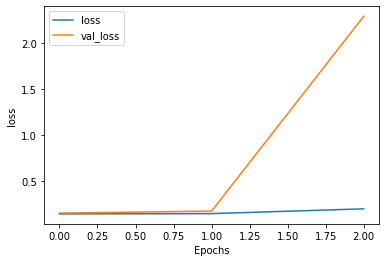

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4198 - accuracy: 0.0066 - val_loss: 0.1778 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1290 - accuracy: 0.0067 - val_loss: 0.1444 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6355 - accuracy: 0.0066 - val_loss: 0.9649 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2304.0777909404223, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-7247.9698933463005, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4483.541871262163, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-836.1100621218629, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-07-23~2019-07-23
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


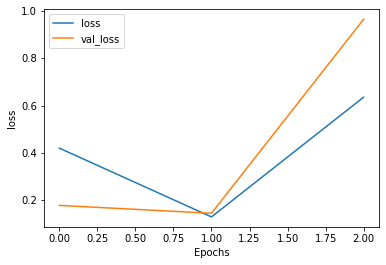

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2338 - accuracy: 0.0067 - val_loss: 0.1577 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1386 - accuracy: 0.0067 - val_loss: 0.1327 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1242 - accuracy: 0.0067 - val_loss: 0.2277 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-883.1911069443003, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1991.5906054414606, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2003.3589523175383, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2018.4836953822532, shape=(), dtype=float64)
test dates 2019-07-24~2019-07-24
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


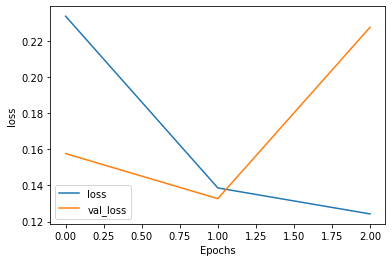

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1442 - accuracy: 0.0067 - val_loss: 0.3381 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1486 - accuracy: 0.0067 - val_loss: 0.1931 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7184 - accuracy: 0.0066 - val_loss: 0.5671 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2509.9764397996637, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2169.9192421501098, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2189.9006088593974, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2215.1769899766246, shape=(), dtype=float64)
test dates 2019-07-25~2019-07-25
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


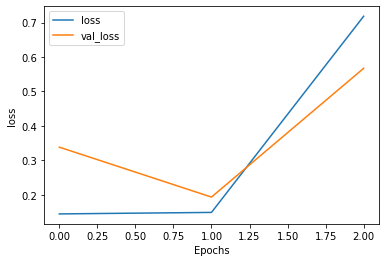

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2132 - accuracy: 0.0067 - val_loss: 0.2019 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1330 - accuracy: 0.0067 - val_loss: 0.1628 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1277 - accuracy: 0.0067 - val_loss: 0.1656 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2834.9799786805384, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2109.2498025077944, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2115.714892295036, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2124.0665475542155, shape=(), dtype=float64)
test dates 2019-07-26~2019-07-26
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


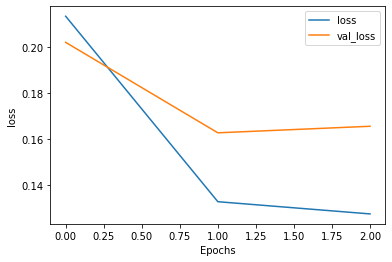

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1228 - accuracy: 0.0067 - val_loss: 0.2465 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1578 - accuracy: 0.0067 - val_loss: 0.2136 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1347 - accuracy: 0.0067 - val_loss: 0.2043 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2651.312100891901, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3279.465073242354, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5352.967564818766, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1957.3391720130164, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-07-29~2019-07-29
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


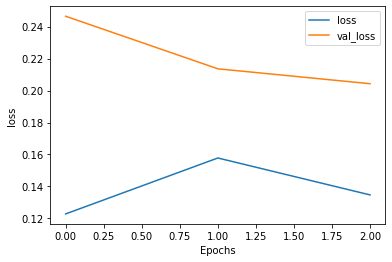

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1323 - accuracy: 0.0067 - val_loss: 0.2348 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2225 - accuracy: 0.0067 - val_loss: 0.2019 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1382 - accuracy: 0.0067 - val_loss: 0.2580 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2451.478547895725, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-18385.429118462907, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-953.4941674805443, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-952.5232955943844, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-07-30~2019-07-30
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


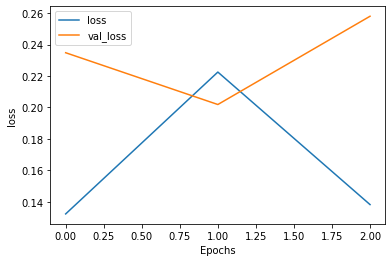

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1525 - accuracy: 0.0067 - val_loss: 0.2347 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1542 - accuracy: 0.0067 - val_loss: 0.3362 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3717 - accuracy: 0.0066 - val_loss: 0.2534 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-998.5644899645999, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2005.4624676272579, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2026.45982852802, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2056.6618331401655, shape=(), dtype=float64)
test dates 2019-07-31~2019-07-31
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


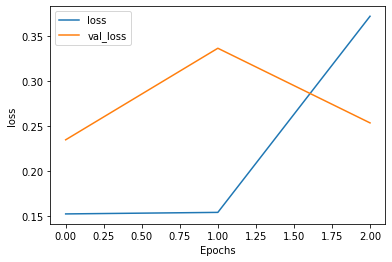

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1877 - accuracy: 0.0067 - val_loss: 0.2788 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 3.5320 - accuracy: 0.0063 - val_loss: 2.8350 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.1703 - accuracy: 0.0066 - val_loss: 1.9652 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2616.6886695905437, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3259.8882126730964, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4008.208600687452, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1044.8303230148535, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-08-01~2019-08-01
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dt

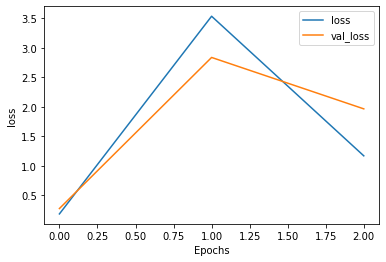

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5842 - accuracy: 0.0067 - val_loss: 0.5029 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.2749 - accuracy: 0.0064 - val_loss: 0.9037 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4615 - accuracy: 0.0067 - val_loss: 0.4654 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1132.2631283431026, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1875.2376641288295, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1898.8164430056477, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1931.95103371501, shape=(), dtype=float64)
test dates 2019-08-02~2019-08-02
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


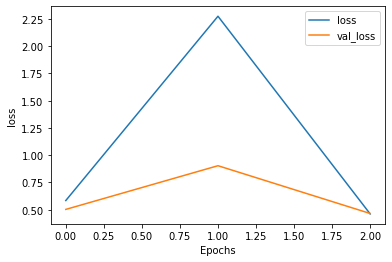

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4216 - accuracy: 0.0066 - val_loss: 0.6966 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2485 - accuracy: 0.0067 - val_loss: 0.4256 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1624 - accuracy: 0.0067 - val_loss: 0.4211 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2346.5089983405774, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1977.056795985, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2006.1482086918331, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2049.6514367316754, shape=(), dtype=float64)
test dates 2019-08-05~2019-08-05
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


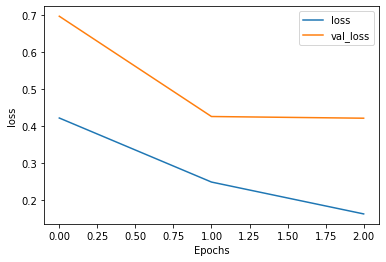

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1553 - accuracy: 0.0067 - val_loss: 0.5244 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1663 - accuracy: 0.0067 - val_loss: 0.4735 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1306 - accuracy: 0.0067 - val_loss: 0.5311 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3076.241067073459, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4104.2384287186505, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-962.3270855922576, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-961.6248503464018, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-08-06~2019-08-06
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


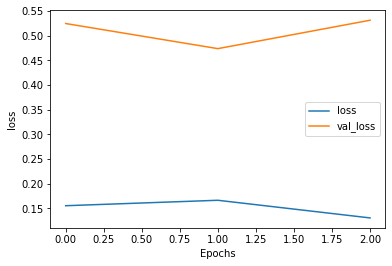

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1391 - accuracy: 0.0067 - val_loss: 0.3288 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1246 - accuracy: 0.0067 - val_loss: 0.5020 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1556 - accuracy: 0.0067 - val_loss: 0.4306 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1330.1607609824098, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2538.2790462551056, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2599.028496597015, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2699.901180430074, shape=(), dtype=float64)
test dates 2019-08-07~2019-08-07
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


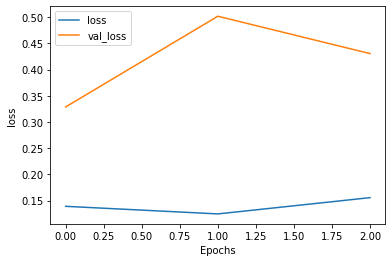

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1247 - accuracy: 0.0067 - val_loss: 0.2051 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1218 - accuracy: 0.0067 - val_loss: 0.2700 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.2713 - accuracy: 0.0064 - val_loss: 0.9157 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3364.232803269522, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1962.1261285287455, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1957.6820001423837, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1958.0643961941096, shape=(), dtype=float64)
test dates 2019-08-08~2019-08-08
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


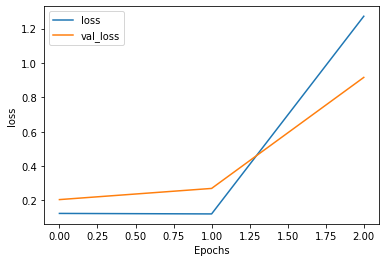

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.2683 - accuracy: 0.0067 - val_loss: 0.3244 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1531 - accuracy: 0.0067 - val_loss: 0.3119 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1398 - accuracy: 0.0067 - val_loss: 0.2167 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2236.5649369977186, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2760.1218263420515, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2833.050285572001, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2948.5509157521724, shape=(), dtype=float64)
test dates 2019-08-09~2019-08-09
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


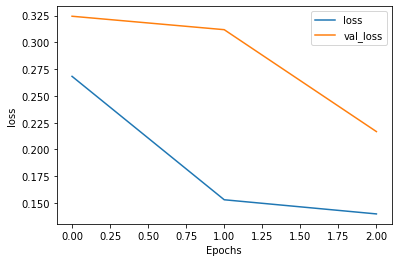

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.1129 - accuracy: 0.0067 - val_loss: 0.1670 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1159 - accuracy: 0.0067 - val_loss: 0.1251 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1127 - accuracy: 0.0067 - val_loss: 0.1721 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3994.514996156813, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2633.962239153806, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2663.325554546557, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2705.406200860284, shape=(), dtype=float64)
test dates 2019-08-12~2019-08-12
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


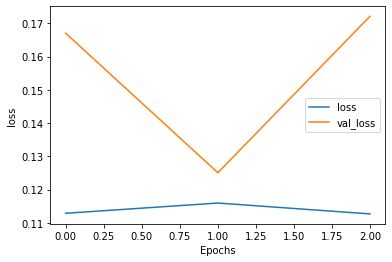

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3056 - accuracy: 0.0067 - val_loss: 0.7267 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.8918 - accuracy: 0.0066 - val_loss: 0.5744 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1792 - accuracy: 0.0067 - val_loss: 0.1494 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3462.9862430255034, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1751.44312586496, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1810.205762236165, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1928.7665195799125, shape=(), dtype=float64)
test dates 2019-08-13~2019-08-13
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


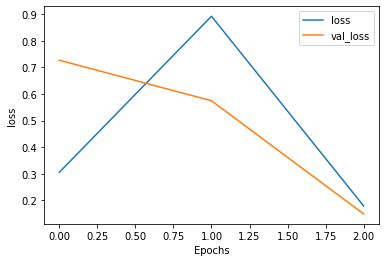

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1178 - accuracy: 0.0067 - val_loss: 0.2692 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1220 - accuracy: 0.0067 - val_loss: 0.2213 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1172 - accuracy: 0.0067 - val_loss: 0.3105 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2667.3965679046123, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3143.6588372721003, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3417.9152468920565, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3999.8128992284774, shape=(), dtype=float64)
test dates 2019-08-14~2019-08-14
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


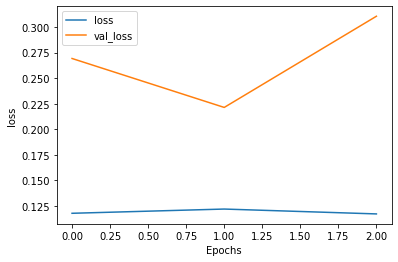

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1370 - accuracy: 0.0067 - val_loss: 0.3773 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1265 - accuracy: 0.0067 - val_loss: 0.2135 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1283 - accuracy: 0.0067 - val_loss: 0.3275 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-10308.022034478181, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-53105.97626106291, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1578.1667531917947, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1584.6708320022692, shape=(), dtype=float64)
test dates 2019-08-16~2019-08-16
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


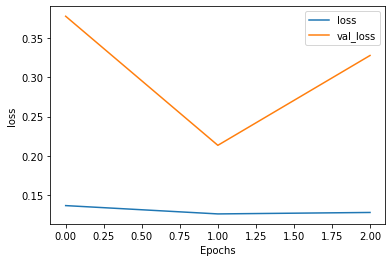

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1316 - accuracy: 0.0067 - val_loss: 0.2608 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1475 - accuracy: 0.0067 - val_loss: 0.3190 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1741 - accuracy: 0.0067 - val_loss: 0.1896 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1785.967774683344, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2637.220322002996, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2658.4244107343347, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2686.0885477922593, shape=(), dtype=float64)
test dates 2019-08-19~2019-08-19
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


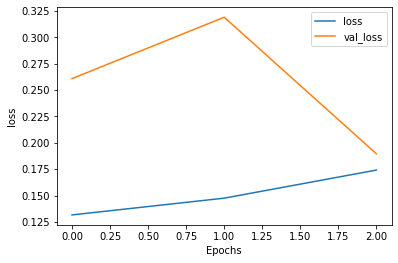

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.6782 - accuracy: 0.0064 - val_loss: 0.5041 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2242 - accuracy: 0.0067 - val_loss: 0.2103 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1353 - accuracy: 0.0067 - val_loss: 0.1189 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3408.437839480179, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2694.4090502164468, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2706.296319802721, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2723.3698460280275, shape=(), dtype=float64)
test dates 2019-08-20~2019-08-20
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


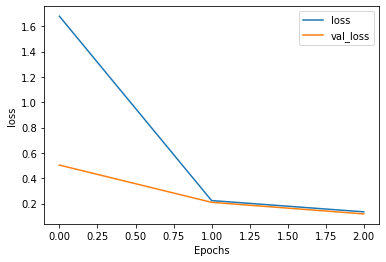

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5893 - accuracy: 0.0066 - val_loss: 0.3962 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1603 - accuracy: 0.0067 - val_loss: 0.1667 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1088 - accuracy: 0.0067 - val_loss: 0.1631 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3463.997450710415, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4457.2262500989555, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1172.2550299682844, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1059.6342320372012, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-08-21~2019-08-21
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


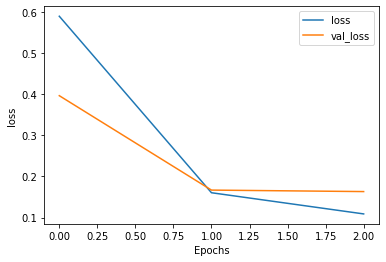

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1189 - accuracy: 0.0067 - val_loss: 0.2198 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1679 - accuracy: 0.0067 - val_loss: 0.2154 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1133 - accuracy: 0.0067 - val_loss: 0.1751 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1146.2589428225167, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3389.2316342216563, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4465.818751738853, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-966.3299583039839, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-08-22~2019-08-22
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


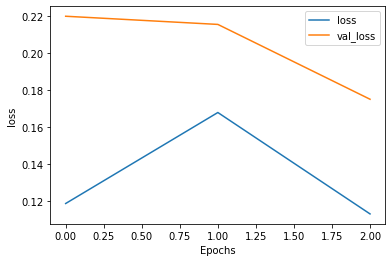

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1156 - accuracy: 0.0067 - val_loss: 0.3122 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1364 - accuracy: 0.0067 - val_loss: 0.3214 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1217 - accuracy: 0.0067 - val_loss: 0.1557 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1061.2526219206936, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2689.0057562674515, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2761.3475985735786, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2871.9526086326355, shape=(), dtype=float64)
test dates 2019-08-23~2019-08-23
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


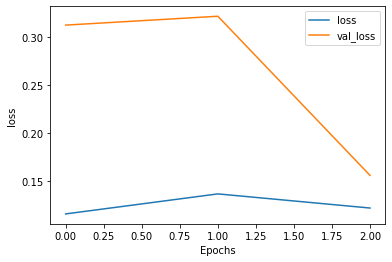

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1785 - accuracy: 0.0067 - val_loss: 0.4867 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.8210 - accuracy: 0.0065 - val_loss: 4.5338 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7846 - accuracy: 0.0067 - val_loss: 0.5607 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-4097.237481896217, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1988.842322789541, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1981.8894021675032, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1986.7739497030057, shape=(), dtype=float64)
test dates 2019-08-26~2019-08-26
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


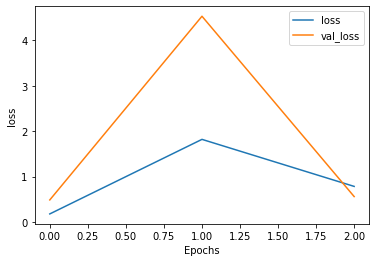

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1944 - accuracy: 0.0067 - val_loss: 0.3550 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2449 - accuracy: 0.0067 - val_loss: 0.3256 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1209 - accuracy: 0.0067 - val_loss: 0.1942 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2476.9675941747923, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3159.9538737006633, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3403.1637412060177, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3909.4862264373437, shape=(), dtype=float64)
test dates 2019-08-27~2019-08-27
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


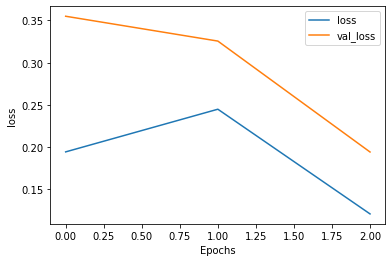

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1375 - accuracy: 0.0067 - val_loss: 0.1663 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1114 - accuracy: 0.0067 - val_loss: 0.1555 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1118 - accuracy: 0.0067 - val_loss: 0.1461 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-7497.779635638937, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4846.472265266609, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-6570.430731059354, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1249.6508065054832, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-08-28~2019-08-28
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


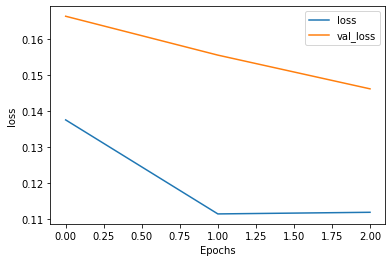

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1587 - accuracy: 0.0067 - val_loss: 0.1584 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1273 - accuracy: 0.0067 - val_loss: 0.1908 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.0258 - accuracy: 0.0064 - val_loss: 1.6102 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1258.175787106529, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2778.429407618763, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2785.764665695666, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2796.2955483367823, shape=(), dtype=float64)
test dates 2019-08-29~2019-08-29
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


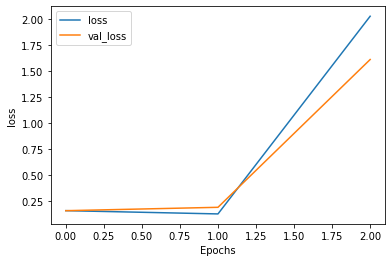

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5221 - accuracy: 0.0066 - val_loss: 0.2647 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1929 - accuracy: 0.0067 - val_loss: 0.1851 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1373 - accuracy: 0.0067 - val_loss: 0.1664 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3413.8403047115057, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2452.5904616507974, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2451.2591282131107, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2451.395245890067, shape=(), dtype=float64)
test dates 2019-08-30~2019-08-30
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


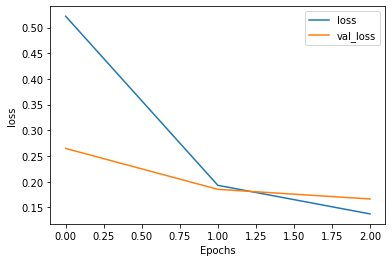

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1176 - accuracy: 0.0067 - val_loss: 0.1553 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1164 - accuracy: 0.0067 - val_loss: 0.1420 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1067 - accuracy: 0.0067 - val_loss: 0.1567 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-2935.81676227958, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2903.967448020043, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2905.9875011751474, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2908.9743647851737, shape=(), dtype=float64)
test dates 2019-09-02~2019-09-02
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


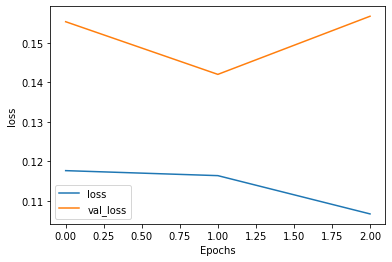

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1170 - accuracy: 0.0067 - val_loss: 0.1796 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1088 - accuracy: 0.0067 - val_loss: 0.1689 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1406 - accuracy: 0.0067 - val_loss: 0.8821 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3275.474902143551, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4292.220996618166, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1799.8473548035786, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1519.3840344024277, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-09-03~2019-09-03
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


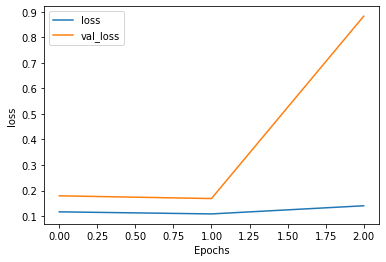

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2968 - accuracy: 0.0067 - val_loss: 0.2337 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1139 - accuracy: 0.0067 - val_loss: 0.1963 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1228 - accuracy: 0.0067 - val_loss: 0.2425 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1456.6561788578708, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2172.491456410709, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2172.2865999630853, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2172.4212546551366, shape=(), dtype=float64)
test dates 2019-09-04~2019-09-04
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


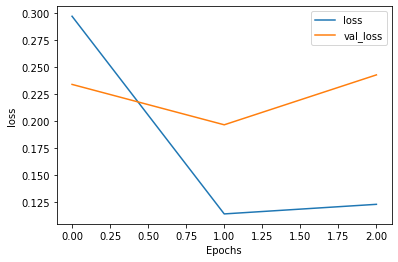

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1230 - accuracy: 0.0067 - val_loss: 0.3145 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1378 - accuracy: 0.0067 - val_loss: 0.8993 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 9.2438 - accuracy: 0.0060 - val_loss: 4.5866 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2708.9549589550074, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2425.102078301082, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2630.03510771551, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3023.812927220217, shape=(), dtype=float64)
test dates 2019-09-05~2019-09-05
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


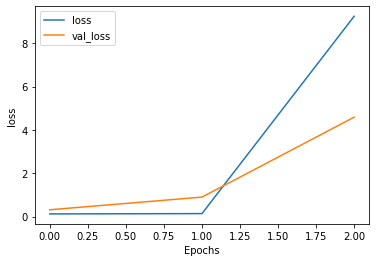

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.6422 - accuracy: 0.0064 - val_loss: 2.0234 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.2731 - accuracy: 0.0066 - val_loss: 1.1723 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.7982 - accuracy: 0.0066 - val_loss: 0.8845 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-6551.996492230244, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2910.713784726128, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-6008.728953348909, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1087.0058840630018, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-09-06~2019-09-06
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


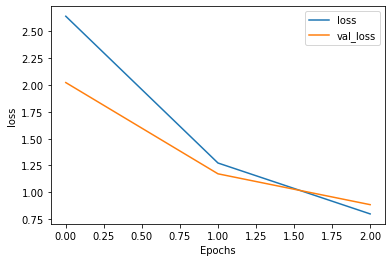

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.5625 - accuracy: 0.0066 - val_loss: 0.6274 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4357 - accuracy: 0.0066 - val_loss: 0.5488 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.3504 - accuracy: 0.0066 - val_loss: 0.5217 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1221.1144969333081, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2766.7774715326595, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3396.1517202920595, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-12107.210253584602, shape=(), dtype=float64)
test dates 2019-09-09~2019-09-09
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


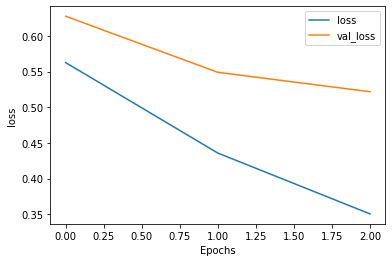

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2958 - accuracy: 0.0066 - val_loss: 0.4369 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2558 - accuracy: 0.0066 - val_loss: 0.4136 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2407 - accuracy: 0.0066 - val_loss: 0.4350 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-1083.7825635412369, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1792.653435262213, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1897.1503588114692, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2095.8134208530314, shape=(), dtype=float64)
test dates 2019-09-10~2019-09-10
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


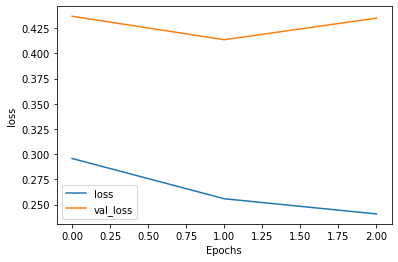

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2141 - accuracy: 0.0066 - val_loss: 0.3906 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2021 - accuracy: 0.0066 - val_loss: 0.4277 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1939 - accuracy: 0.0066 - val_loss: 0.5027 - val_accuracy: 0.0100
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3112.0303767652636, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2499.7145011850926, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2530.7624609947115, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2577.0698424558514, shape=(), dtype=float64)
test dates 2019-09-11~2019-09-11
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


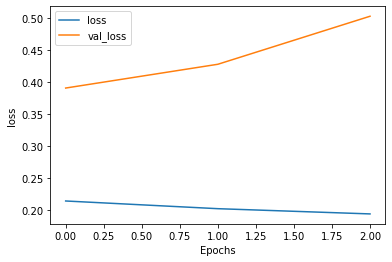

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1792 - accuracy: 0.0066 - val_loss: 0.5076 - val_accuracy: 0.0100
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1747 - accuracy: 0.0066 - val_loss: 0.5471 - val_accuracy: 0.0100
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1718 - accuracy: 0.0066 - val_loss: 0.4303 - val_accuracy: 0.0100
prediction2_MSE = tf.Tensor(-3376.1700938657546, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2821.2380549802187, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3467.26090293748, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-11385.800193306182, shape=(), dtype=float64)
test dates 2019-09-16~2019-09-16
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


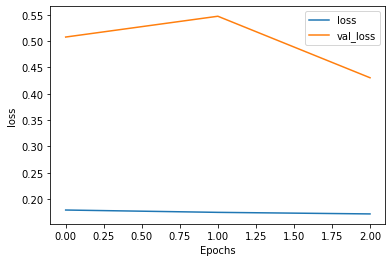

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1675 - accuracy: 0.0066 - val_loss: 0.4612 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1708 - accuracy: 0.0066 - val_loss: 0.4568 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1775 - accuracy: 0.0066 - val_loss: 0.3603 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-791.7135829068778, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2359.7986934856503, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2433.282865603616, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2547.6819971393925, shape=(), dtype=float64)
test dates 2019-09-17~2019-09-17
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


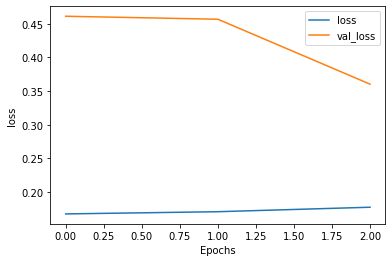

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1524 - accuracy: 0.0066 - val_loss: 0.2954 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1593 - accuracy: 0.0066 - val_loss: 0.3120 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1579 - accuracy: 0.0066 - val_loss: 0.2735 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-3456.276227285142, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3309.1977449542037, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5794.582272692736, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-871.8684086911985, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-09-18~2019-09-18
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


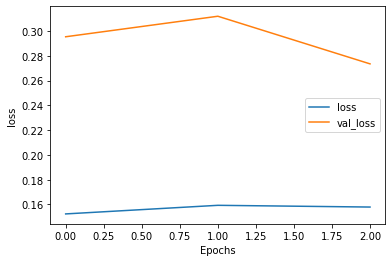

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.1532 - accuracy: 0.0066 - val_loss: 0.2674 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.1818 - accuracy: 0.0066 - val_loss: 0.2487 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4483 - accuracy: 0.0065 - val_loss: 0.4065 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-907.1506380237129, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2257.0412487873596, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2321.8396237136785, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2420.433457965291, shape=(), dtype=float64)
test dates 2019-09-19~2019-09-19
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


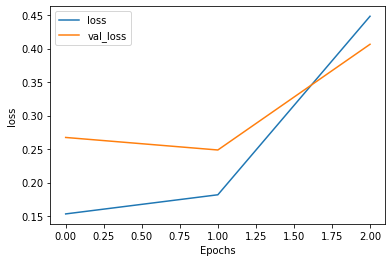

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1759 - accuracy: 0.0066 - val_loss: 0.2357 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1419 - accuracy: 0.0066 - val_loss: 0.2952 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.6629 - accuracy: 0.0063 - val_loss: 0.6571 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3365.0492425811303, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-9912.490530085992, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1383.8640610372443, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1408.0002331413802, shape=(), dtype=float64)
test dates 2019-09-20~2019-09-20
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


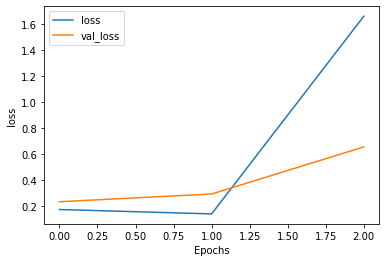

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2620 - accuracy: 0.0066 - val_loss: 0.3592 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1705 - accuracy: 0.0066 - val_loss: 0.2383 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1406 - accuracy: 0.0066 - val_loss: 0.2583 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1596.1615444307618, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2282.8126843602654, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2291.3475763543333, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2303.106061245373, shape=(), dtype=float64)
test dates 2019-09-23~2019-09-23
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


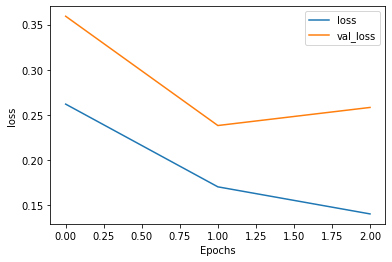

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1337 - accuracy: 0.0067 - val_loss: 0.2016 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1500 - accuracy: 0.0066 - val_loss: 0.1702 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1275 - accuracy: 0.0066 - val_loss: 0.2239 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2888.262956243165, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3322.8755013911864, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3975.816393146872, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-7369.257847090054, shape=(), dtype=float64)
test dates 2019-09-24~2019-09-24
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


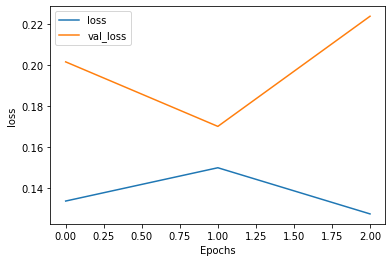

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1698 - accuracy: 0.0066 - val_loss: 0.1573 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1260 - accuracy: 0.0066 - val_loss: 0.1698 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1308 - accuracy: 0.0066 - val_loss: 0.2065 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1375.9338431324059, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3010.4561837955525, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3926.746238735921, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2491.7105762085494, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-09-25~2019-09-25
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, 

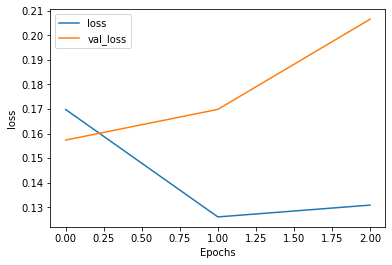

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1356 - accuracy: 0.0067 - val_loss: 0.1792 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1618 - accuracy: 0.0066 - val_loss: 0.1228 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1361 - accuracy: 0.0066 - val_loss: 0.2002 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-3112.9566195717293, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2329.5008912269554, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2331.689499591865, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2335.0229082107776, shape=(), dtype=float64)
test dates 2019-09-26~2019-09-26
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


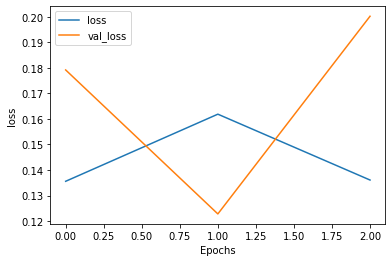

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1659 - accuracy: 0.0066 - val_loss: 0.2134 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.2894 - accuracy: 0.0062 - val_loss: 0.7636 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3634 - accuracy: 0.0066 - val_loss: 0.2960 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2980.2196901951816, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2618.9434694984625, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2793.5066418361707, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3121.5751259736844, shape=(), dtype=float64)
test dates 2019-09-27~2019-09-27
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


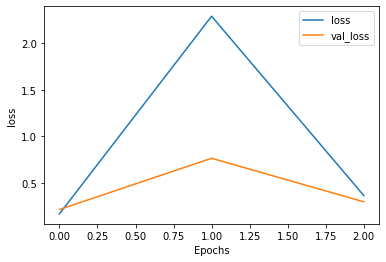

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1836 - accuracy: 0.0066 - val_loss: 0.1847 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1603 - accuracy: 0.0066 - val_loss: 0.1850 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1317 - accuracy: 0.0066 - val_loss: 0.1767 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-5592.119901620735, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2955.9776679639353, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3442.526148029634, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4784.079199317318, shape=(), dtype=float64)
test dates 2019-09-30~2019-09-30
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


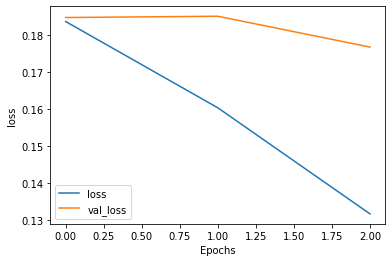

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1155 - accuracy: 0.0067 - val_loss: 0.2318 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1172 - accuracy: 0.0066 - val_loss: 0.1539 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1231 - accuracy: 0.0067 - val_loss: 0.1414 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-790.847385223407, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1693.6740103986203, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1719.90456973599, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1768.2987613224968, shape=(), dtype=float64)
test dates 2019-10-01~2019-10-01
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


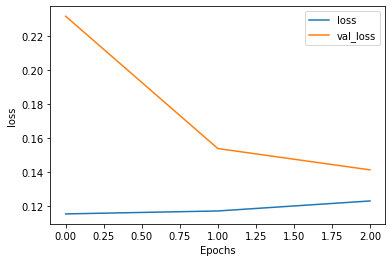

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1280 - accuracy: 0.0066 - val_loss: 0.2123 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1265 - accuracy: 0.0066 - val_loss: 0.2908 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1208 - accuracy: 0.0066 - val_loss: 0.3589 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2187.290777431039, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2586.0308783397504, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2771.1183962591463, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3115.5963611567568, shape=(), dtype=float64)
test dates 2019-10-02~2019-10-02
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


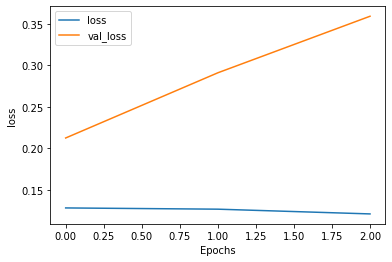

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1676 - accuracy: 0.0066 - val_loss: 0.4266 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1333 - accuracy: 0.0067 - val_loss: 0.3535 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1456 - accuracy: 0.0066 - val_loss: 0.4700 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-5918.3743668631205, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-9620.60530678631, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2385.422000195722, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2614.3755794449726, shape=(), dtype=float64)
test dates 2019-10-04~2019-10-04
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


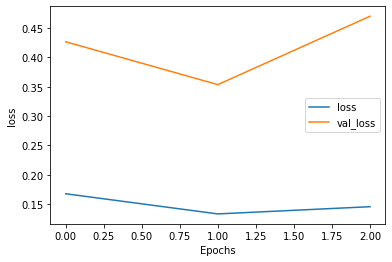

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1707 - accuracy: 0.0066 - val_loss: 0.4693 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1242 - accuracy: 0.0067 - val_loss: 0.2613 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2443 - accuracy: 0.0066 - val_loss: 0.1909 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-4436.812603014919, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4221.79406092935, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2647.6663822035443, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3058.576653932412, shape=(), dtype=float64)
test dates 2019-10-07~2019-10-07
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


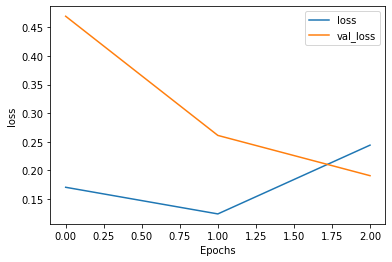

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.1333 - accuracy: 0.0066 - val_loss: 0.2238 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.1326 - accuracy: 0.0066 - val_loss: 0.2487 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 5.7883 - accuracy: 0.0062 - val_loss: 3.3573 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-11818.120249217074, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4091.8474137774447, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1677.7284728163, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1341.409936182694, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-10-08~2019-10-08
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, sha

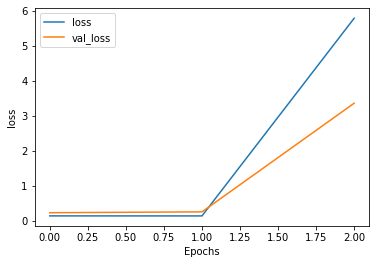

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.1941 - accuracy: 0.0066 - val_loss: 0.7720 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4396 - accuracy: 0.0066 - val_loss: 0.4532 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6290 - accuracy: 0.0066 - val_loss: 0.5445 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1531.5128433555012, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2986.712578876754, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3024.4539341495347, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3075.837286795457, shape=(), dtype=float64)
test dates 2019-10-10~2019-10-10
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


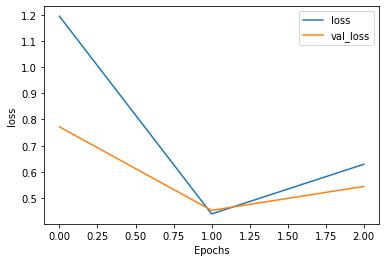

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2521 - accuracy: 0.0067 - val_loss: 0.2354 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1666 - accuracy: 0.0067 - val_loss: 0.2205 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1437 - accuracy: 0.0066 - val_loss: 0.1546 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-3905.405660730534, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3147.19126411213, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3169.2065769930177, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3199.6794948077936, shape=(), dtype=float64)
test dates 2019-10-11~2019-10-11
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


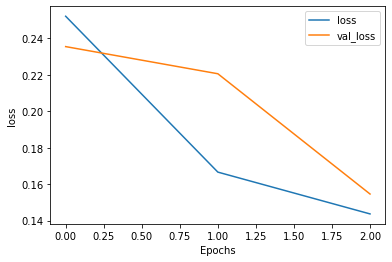

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.1264 - accuracy: 0.0066 - val_loss: 0.2603 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1193 - accuracy: 0.0066 - val_loss: 0.2848 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.1219 - accuracy: 0.0066 - val_loss: 0.2256 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-3991.9833287027614, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2105.525808084978, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1541.4604824573298, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1546.8552081653484, shape=(), dtype=float64)
test dates 2019-10-14~2019-10-14
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


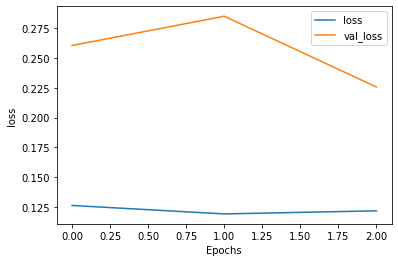

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1115 - accuracy: 0.0066 - val_loss: 0.1701 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1446 - accuracy: 0.0066 - val_loss: 0.3691 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1293 - accuracy: 0.0066 - val_loss: 0.2424 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1690.1502409351306, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3033.341669894091, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3421.293483609034, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4365.197054384053, shape=(), dtype=float64)
test dates 2019-10-15~2019-10-15
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


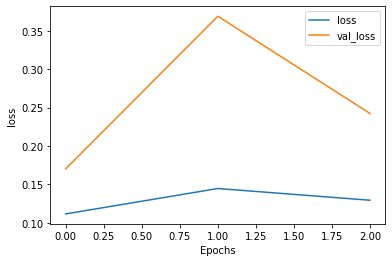

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1124 - accuracy: 0.0066 - val_loss: 0.1569 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1177 - accuracy: 0.0066 - val_loss: 0.2473 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1783 - accuracy: 0.0066 - val_loss: 0.1583 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1902.3072350544219, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-15556.516222347766, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1371.621995978285, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1381.1654141506915, shape=(), dtype=float64)
test dates 2019-10-16~2019-10-16
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


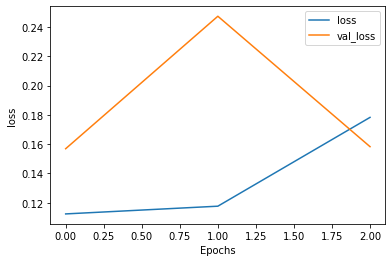

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1280 - accuracy: 0.0066 - val_loss: 0.1465 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1240 - accuracy: 0.0066 - val_loss: 0.1261 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1250 - accuracy: 0.0066 - val_loss: 0.1458 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1551.2875723864104, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3063.269909526988, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3207.938777571351, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3461.7950132226347, shape=(), dtype=float64)
test dates 2019-10-17~2019-10-17
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


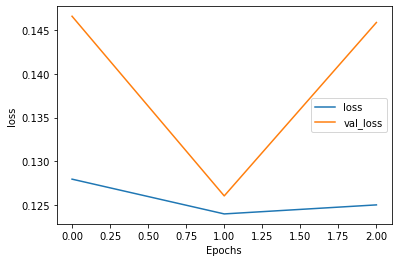

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1349 - accuracy: 0.0066 - val_loss: 0.1544 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2620 - accuracy: 0.0066 - val_loss: 0.2945 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1331 - accuracy: 0.0066 - val_loss: 0.1990 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-5320.882560064084, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3032.8227614519474, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3094.001706548901, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3170.0912170593256, shape=(), dtype=float64)
test dates 2019-10-18~2019-10-18
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


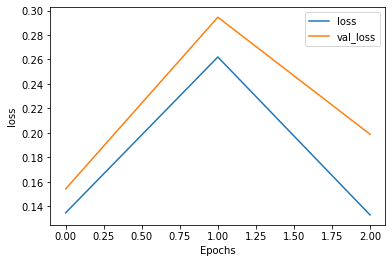

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.1253 - accuracy: 0.0066 - val_loss: 0.2802 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.3074 - accuracy: 0.0066 - val_loss: 0.2143 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1239 - accuracy: 0.0066 - val_loss: 0.2697 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-4085.068790516145, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3338.688614040315, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3902.6569222372573, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-6109.514178518326, shape=(), dtype=float64)
test dates 2019-10-21~2019-10-21
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


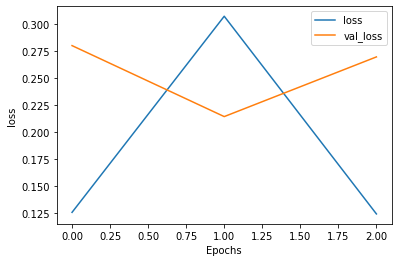

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1631 - accuracy: 0.0066 - val_loss: 0.2473 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1183 - accuracy: 0.0066 - val_loss: 0.2783 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1606 - accuracy: 0.0066 - val_loss: 0.2120 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-6872.440507788548, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3560.310829931408, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3960.7138539480165, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4972.41624036778, shape=(), dtype=float64)
test dates 2019-10-22~2019-10-22
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


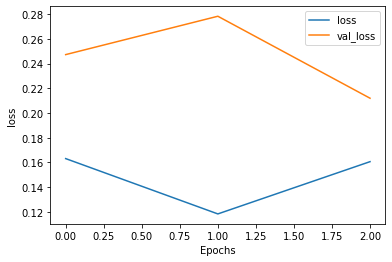

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1453 - accuracy: 0.0066 - val_loss: 0.2511 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 8.4832 - accuracy: 0.0061 - val_loss: 17.2036 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 9.3961 - accuracy: 0.0062 - val_loss: 5.6359 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1442.1819796907648, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3341.941890338234, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4027.032289014187, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-9090.564011350314, shape=(), dtype=float64)
test dates 2019-10-23~2019-10-23
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


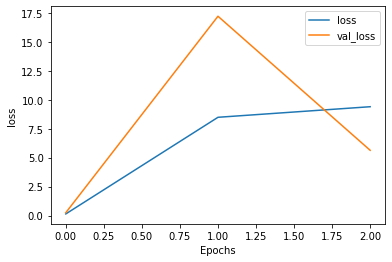

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 4.0460 - accuracy: 0.0063 - val_loss: 2.9683 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.3346 - accuracy: 0.0064 - val_loss: 1.9379 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 1.5310 - accuracy: 0.0065 - val_loss: 1.4617 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-868.890037249468, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-8678.109115870873, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3809.3963171628125, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-139190.9215076667, shape=(), dtype=float64)
test dates 2019-10-24~2019-10-24
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


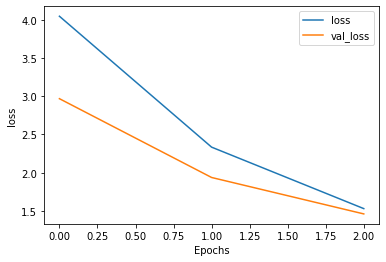

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.0901 - accuracy: 0.0065 - val_loss: 1.0536 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.8222 - accuracy: 0.0065 - val_loss: 0.8023 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6426 - accuracy: 0.0065 - val_loss: 0.6063 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-950.577457739306, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3018.4164316167885, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1792.9907830740958, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1643.6928762868802, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-10-25~2019-10-25
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


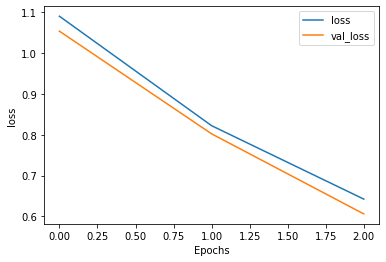

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5219 - accuracy: 0.0065 - val_loss: 0.6169 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4411 - accuracy: 0.0065 - val_loss: 0.4845 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3802 - accuracy: 0.0065 - val_loss: 0.4666 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1891.9636441196453, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2180.3417739714173, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2203.855426881531, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2238.0848221977403, shape=(), dtype=float64)
test dates 2019-10-28~2019-10-28
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


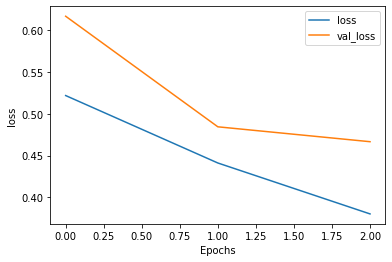

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3294 - accuracy: 0.0066 - val_loss: 0.4805 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2927 - accuracy: 0.0065 - val_loss: 0.2741 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2656 - accuracy: 0.0065 - val_loss: 0.2793 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2786.127103455074, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1370.5124945853377, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1369.9722528830089, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1383.2170862059575, shape=(), dtype=float64)
test dates 2019-10-29~2019-10-29
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


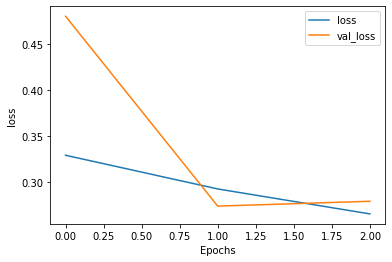

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2455 - accuracy: 0.0065 - val_loss: 0.2601 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2287 - accuracy: 0.0066 - val_loss: 0.2693 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2172 - accuracy: 0.0066 - val_loss: 0.2660 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1591.9021055080739, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2644.4974049630096, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3618.4029724968796, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1048.3753289305712, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-10-30~2019-10-30
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0,

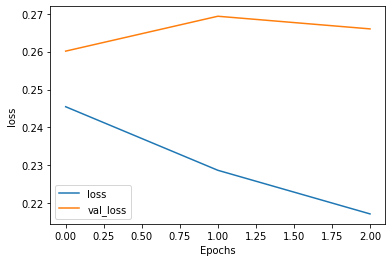

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2063 - accuracy: 0.0066 - val_loss: 0.2450 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2040 - accuracy: 0.0066 - val_loss: 0.2221 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1894 - accuracy: 0.0065 - val_loss: 0.2006 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1185.9903045258889, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2066.2474431753026, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2131.796674506192, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2227.4625857837896, shape=(), dtype=float64)
test dates 2019-10-31~2019-10-31
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


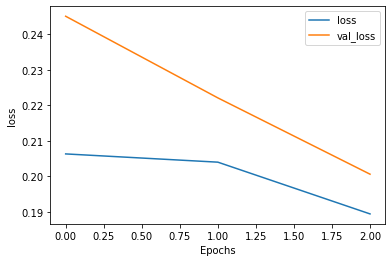

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1902 - accuracy: 0.0066 - val_loss: 0.2040 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2012 - accuracy: 0.0065 - val_loss: 0.2944 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2061 - accuracy: 0.0065 - val_loss: 0.1807 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-3023.2883624732613, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2485.419856406236, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2985.1813522789143, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-6838.726148673767, shape=(), dtype=float64)
test dates 2019-11-01~2019-11-01
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


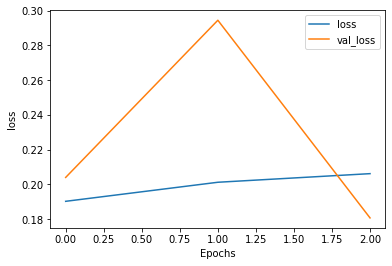

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1731 - accuracy: 0.0065 - val_loss: 0.2359 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1783 - accuracy: 0.0066 - val_loss: 0.2431 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2030 - accuracy: 0.0066 - val_loss: 0.2471 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-682.1822988252721, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1863.5380289960203, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1942.539629744171, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2066.141372333145, shape=(), dtype=float64)
test dates 2019-11-04~2019-11-04
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


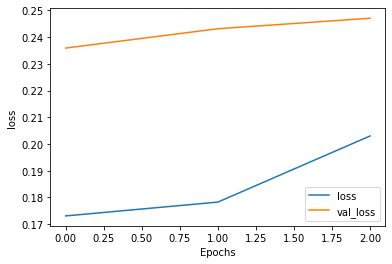

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1711 - accuracy: 0.0066 - val_loss: 0.3007 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1781 - accuracy: 0.0066 - val_loss: 0.3327 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1776 - accuracy: 0.0065 - val_loss: 0.3905 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3096.8150357556638, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2201.259351209117, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2287.866200980048, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2425.5519153377436, shape=(), dtype=float64)
test dates 2019-11-05~2019-11-05
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


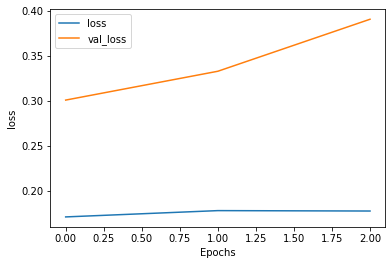

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1790 - accuracy: 0.0066 - val_loss: 0.2790 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1928 - accuracy: 0.0065 - val_loss: 0.2230 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2108 - accuracy: 0.0066 - val_loss: 0.8443 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-3799.1068061826736, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3175.0894671821843, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4209.390968910243, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-909.880441398333, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-11-06~2019-11-06
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


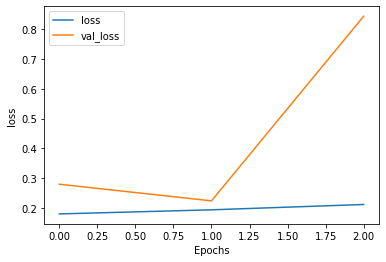

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2113 - accuracy: 0.0065 - val_loss: 0.2348 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1777 - accuracy: 0.0066 - val_loss: 0.2517 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1843 - accuracy: 0.0065 - val_loss: 0.2493 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-970.4414418345137, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2168.9100634781794, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2169.647686591255, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2171.2367458931353, shape=(), dtype=float64)
test dates 2019-11-07~2019-11-07
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


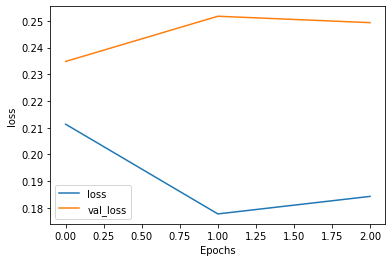

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1928 - accuracy: 0.0066 - val_loss: 0.2717 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7729 - accuracy: 0.0064 - val_loss: 0.2977 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1637 - accuracy: 0.0066 - val_loss: 0.1840 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2667.8394295183407, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1441.1828738788597, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1449.0630425027628, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1484.6773214830107, shape=(), dtype=float64)
test dates 2019-11-08~2019-11-08
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


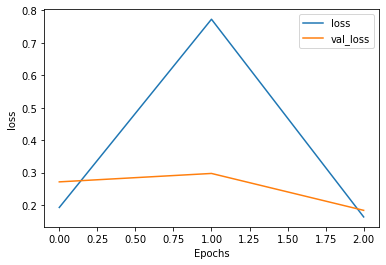

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.5923 - accuracy: 0.0063 - val_loss: 1.9626 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6146 - accuracy: 0.0065 - val_loss: 0.2820 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2104 - accuracy: 0.0065 - val_loss: 0.2357 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1746.2362996111058, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2835.9801789518915, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3407.4332786462605, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-7701.890623964128, shape=(), dtype=float64)
test dates 2019-11-11~2019-11-11
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


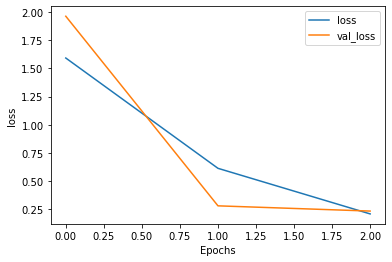

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1637 - accuracy: 0.0065 - val_loss: 0.2054 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1510 - accuracy: 0.0066 - val_loss: 0.1819 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1440 - accuracy: 0.0065 - val_loss: 0.1802 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-826.9021413097286, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1961.1995290559726, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2010.0142446772634, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2086.099482688174, shape=(), dtype=float64)
test dates 2019-11-12~2019-11-12
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


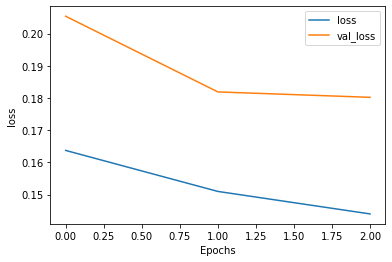

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1521 - accuracy: 0.0066 - val_loss: 0.1459 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1458 - accuracy: 0.0066 - val_loss: 0.1427 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1600 - accuracy: 0.0066 - val_loss: 0.1756 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2672.3688891989605, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3830.466186022, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-960.8462630205254, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-888.5204516653965, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-11-13~2019-11-13
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


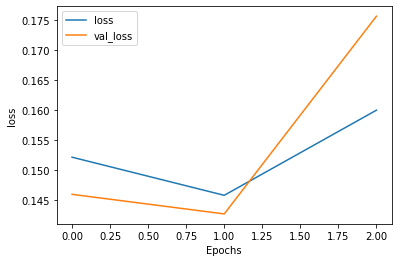

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1473 - accuracy: 0.0066 - val_loss: 0.2055 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1435 - accuracy: 0.0066 - val_loss: 0.2212 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1443 - accuracy: 0.0066 - val_loss: 0.1921 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-945.4205984270956, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2293.4656581847157, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2518.1907058379716, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3038.2179994296594, shape=(), dtype=float64)
test dates 2019-11-14~2019-11-14
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


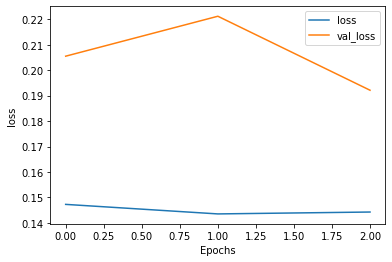

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1493 - accuracy: 0.0066 - val_loss: 0.2259 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1640 - accuracy: 0.0066 - val_loss: 0.1861 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1553 - accuracy: 0.0066 - val_loss: 0.2096 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-11164.169171806318, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2118.0367781269583, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2295.506136372379, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2649.526141112655, shape=(), dtype=float64)
test dates 2019-11-15~2019-11-15
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


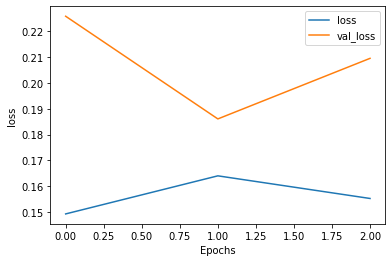

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1710 - accuracy: 0.0065 - val_loss: 0.2351 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1496 - accuracy: 0.0066 - val_loss: 0.2275 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1604 - accuracy: 0.0066 - val_loss: 0.1957 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-5013.612051024899, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4957.914160631015, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-854.4158583470015, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-860.9688913596231, shape=(), dtype=float64)
test dates 2019-11-18~2019-11-18
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


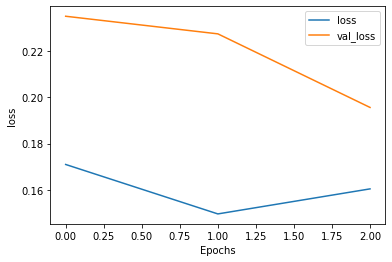

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1677 - accuracy: 0.0065 - val_loss: 0.1946 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1546 - accuracy: 0.0066 - val_loss: 0.1977 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1969 - accuracy: 0.0065 - val_loss: 0.4148 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-947.646535948698, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1945.743076464947, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1996.058019481382, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2067.341374170824, shape=(), dtype=float64)
test dates 2019-11-19~2019-11-19
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


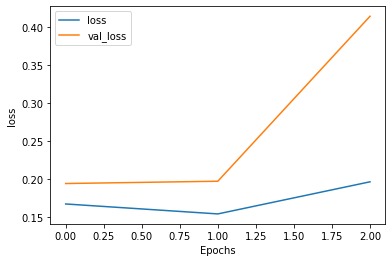

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2269 - accuracy: 0.0066 - val_loss: 0.2900 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1571 - accuracy: 0.0066 - val_loss: 0.4194 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1713 - accuracy: 0.0065 - val_loss: 0.2824 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2742.2244566758495, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3045.644124351453, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-993.2204420421564, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-737.2945888300054, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-11-20~2019-11-20
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


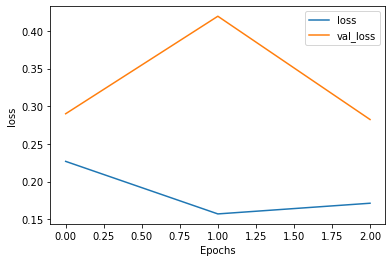

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.7864 - accuracy: 0.0064 - val_loss: 0.3124 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2158 - accuracy: 0.0066 - val_loss: 0.3474 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.1634 - accuracy: 0.0066 - val_loss: 0.3076 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-818.4344563588965, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1982.5389111051074, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2070.7150391152695, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2225.8237634532916, shape=(), dtype=float64)
test dates 2019-11-21~2019-11-21
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


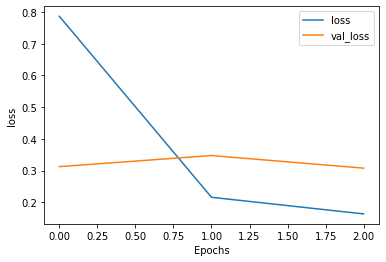

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1481 - accuracy: 0.0066 - val_loss: 0.3492 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1421 - accuracy: 0.0066 - val_loss: 0.3664 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1709 - accuracy: 0.0066 - val_loss: 0.4017 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3726.6480769447235, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2385.0807919118593, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2508.243540019685, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2713.5606461233547, shape=(), dtype=float64)
test dates 2019-11-22~2019-11-22
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


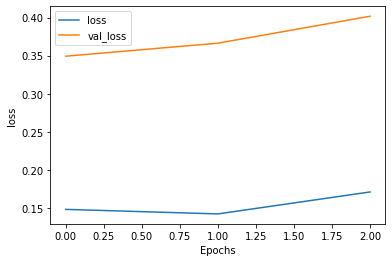

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1871 - accuracy: 0.0066 - val_loss: 0.3828 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3256 - accuracy: 0.0065 - val_loss: 4.1020 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.0141 - accuracy: 0.0062 - val_loss: 2.2467 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-4477.070423714222, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2212.4553756054734, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2220.1291416005133, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2231.7564705484456, shape=(), dtype=float64)
test dates 2019-11-25~2019-11-25
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


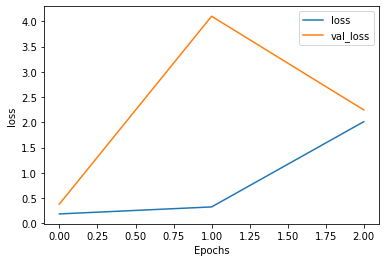

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7184 - accuracy: 0.0065 - val_loss: 0.5713 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5849 - accuracy: 0.0065 - val_loss: 0.8949 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3763 - accuracy: 0.0066 - val_loss: 0.3532 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2858.410623787524, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2387.2273024323185, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2499.8852216784558, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2711.531161194105, shape=(), dtype=float64)
test dates 2019-11-26~2019-11-26
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


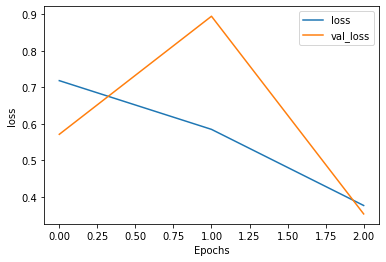

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1805 - accuracy: 0.0066 - val_loss: 0.2727 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1540 - accuracy: 0.0066 - val_loss: 0.2179 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1272 - accuracy: 0.0066 - val_loss: 0.2267 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-4134.491857441716, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4395.086031065089, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2274.0650734314763, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3559.7096105580495, shape=(), dtype=float64)
test dates 2019-11-27~2019-11-27
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


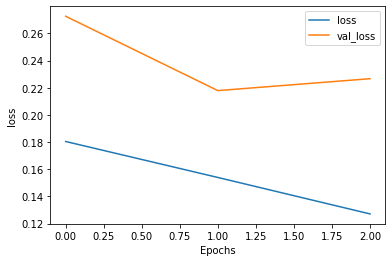

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1323 - accuracy: 0.0065 - val_loss: 0.3039 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1297 - accuracy: 0.0066 - val_loss: 0.3041 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1267 - accuracy: 0.0066 - val_loss: 0.2665 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2159.911941095198, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2731.353741682884, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3461.2508964396075, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1385.2163389933999, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-11-28~2019-11-28
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


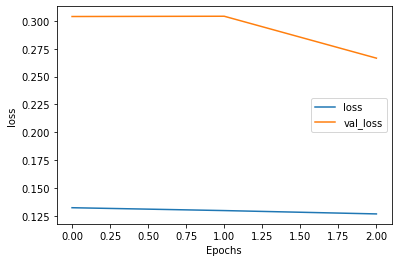

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1243 - accuracy: 0.0066 - val_loss: 0.3825 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1264 - accuracy: 0.0066 - val_loss: 0.3245 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.1229 - accuracy: 0.0064 - val_loss: 3.8338 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1248.5504664613673, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2229.9820874066804, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2340.473349810549, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2507.9892085934857, shape=(), dtype=float64)
test dates 2019-11-29~2019-11-29
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


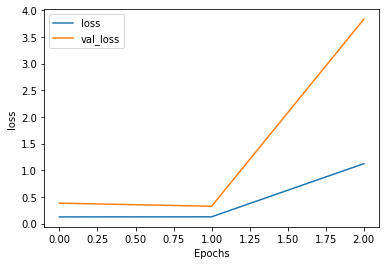

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7823 - accuracy: 0.0064 - val_loss: 0.4693 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2334 - accuracy: 0.0065 - val_loss: 0.4357 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1566 - accuracy: 0.0066 - val_loss: 0.3453 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-4083.6716274107016, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3921.4415353929903, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1188.9771627586, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1215.8033487364387, shape=(), dtype=float64)
test dates 2019-12-02~2019-12-02
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


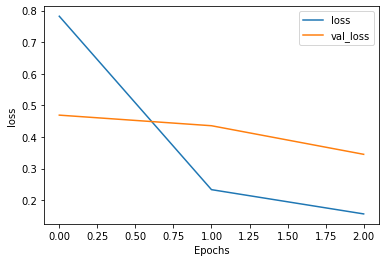

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1474 - accuracy: 0.0066 - val_loss: 0.3305 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 4.7165 - accuracy: 0.0059 - val_loss: 3.8296 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.9228 - accuracy: 0.0063 - val_loss: 1.1331 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1355.7341785938397, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2207.888520935469, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2218.1055165847843, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2234.0779750207953, shape=(), dtype=float64)
test dates 2019-12-03~2019-12-03
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


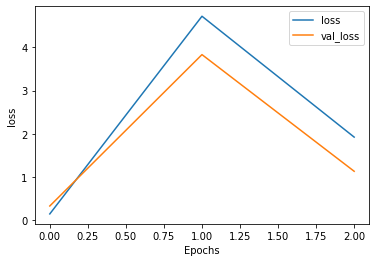

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.8057 - accuracy: 0.0065 - val_loss: 0.8067 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.5297 - accuracy: 0.0065 - val_loss: 0.5239 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3911 - accuracy: 0.0065 - val_loss: 0.4239 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2705.6922609863545, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2477.9225429510134, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2713.918444996763, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3184.8833608015866, shape=(), dtype=float64)
test dates 2019-12-04~2019-12-04
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


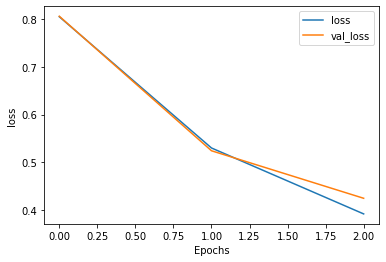

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.3228 - accuracy: 0.0065 - val_loss: 0.4793 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2684 - accuracy: 0.0064 - val_loss: 0.4071 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2418 - accuracy: 0.0065 - val_loss: 0.4279 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-8843.457880487125, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2257.7198072730366, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2261.4442192820143, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2267.122821862089, shape=(), dtype=float64)
test dates 2019-12-05~2019-12-05
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


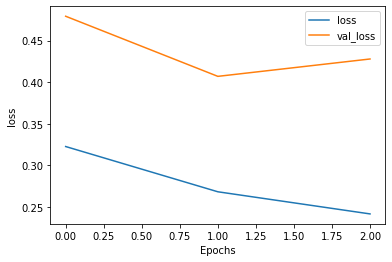

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2167 - accuracy: 0.0065 - val_loss: 0.2398 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2004 - accuracy: 0.0065 - val_loss: 0.3436 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1944 - accuracy: 0.0065 - val_loss: 0.2822 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2915.2564349431304, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2362.1709525488623, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2372.666462268216, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2388.414689925195, shape=(), dtype=float64)
test dates 2019-12-06~2019-12-06
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


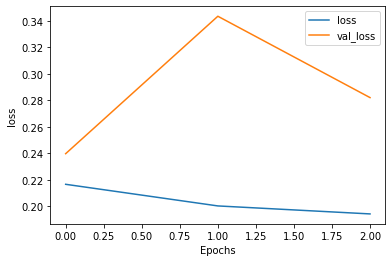

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1876 - accuracy: 0.0065 - val_loss: 0.2622 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1758 - accuracy: 0.0065 - val_loss: 0.3034 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1768 - accuracy: 0.0065 - val_loss: 0.2959 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3000.6294785529512, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2807.122489231488, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3174.4076467560258, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4311.156152641926, shape=(), dtype=float64)
test dates 2019-12-09~2019-12-09
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


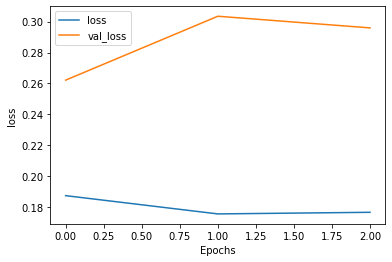

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2838 - accuracy: 0.0065 - val_loss: 0.2762 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1678 - accuracy: 0.0065 - val_loss: 0.2151 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1854 - accuracy: 0.0065 - val_loss: 0.2387 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-830.2884982212795, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3105.1526379597813, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4642.655172694706, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1134.8714656236375, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-12-10~2019-12-10
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


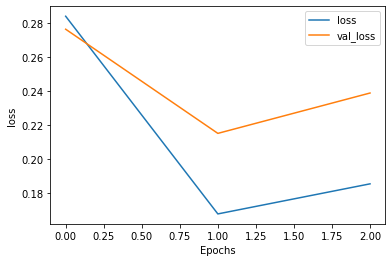

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1532 - accuracy: 0.0065 - val_loss: 0.2539 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1749 - accuracy: 0.0065 - val_loss: 0.1963 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1576 - accuracy: 0.0065 - val_loss: 0.2793 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1184.2929854999877, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2227.215747302409, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2227.9063036775988, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2229.2013073648145, shape=(), dtype=float64)
test dates 2019-12-11~2019-12-11
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


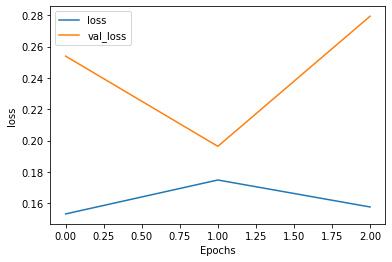

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1520 - accuracy: 0.0065 - val_loss: 0.2798 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2421 - accuracy: 0.0065 - val_loss: 0.2289 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1499 - accuracy: 0.0065 - val_loss: 0.2389 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2704.74549495253, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3313.395463593064, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1002.776449726604, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-969.4328804492897, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-12-12~2019-12-12
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


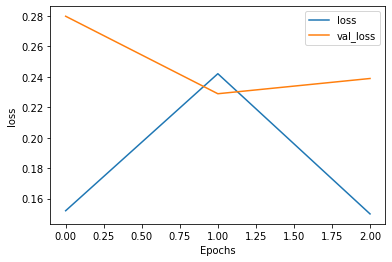

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.7436 - accuracy: 0.0062 - val_loss: 0.9059 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3278 - accuracy: 0.0064 - val_loss: 0.5375 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2067 - accuracy: 0.0065 - val_loss: 0.5601 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1077.558995983381, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2319.6855664674576, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2395.1108877297966, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2525.8183336056954, shape=(), dtype=float64)
test dates 2019-12-13~2019-12-13
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


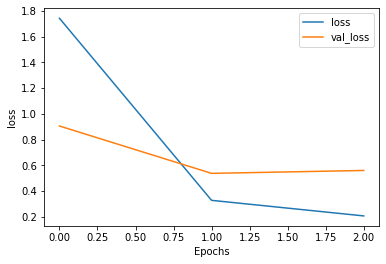

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2381 - accuracy: 0.0064 - val_loss: 0.5678 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1599 - accuracy: 0.0065 - val_loss: 0.5101 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1510 - accuracy: 0.0065 - val_loss: 0.4847 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-4024.9917607481398, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-18631.338328230006, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1535.0509569072124, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1566.0002303629415, shape=(), dtype=float64)
test dates 2019-12-16~2019-12-16
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


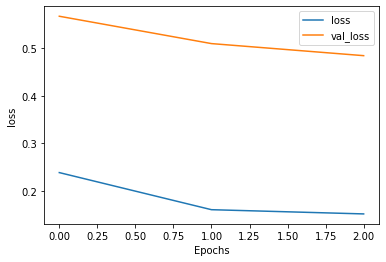

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1396 - accuracy: 0.0065 - val_loss: 0.5065 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1395 - accuracy: 0.0065 - val_loss: 0.4430 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1389 - accuracy: 0.0065 - val_loss: 0.5927 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1877.0793158604154, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1699.6440502326275, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1721.436051165039, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1762.7719817643706, shape=(), dtype=float64)
test dates 2019-12-17~2019-12-17
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


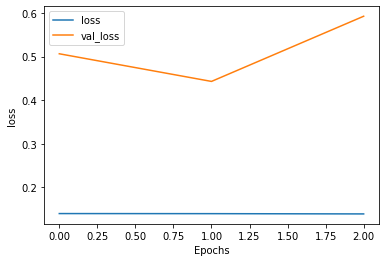

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1633 - accuracy: 0.0065 - val_loss: 0.4217 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1391 - accuracy: 0.0065 - val_loss: 0.2901 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1958 - accuracy: 0.0065 - val_loss: 0.5111 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2126.490075907786, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2816.370329453385, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3109.8786527969974, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3841.3679260502795, shape=(), dtype=float64)
test dates 2019-12-18~2019-12-18
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


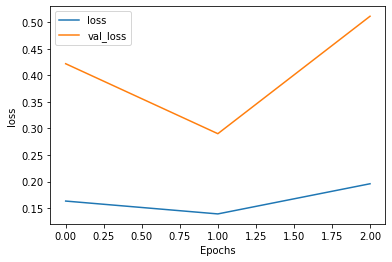

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1441 - accuracy: 0.0065 - val_loss: 0.4587 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1342 - accuracy: 0.0065 - val_loss: 0.2824 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1384 - accuracy: 0.0065 - val_loss: 0.3829 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-154645.28579439802, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3851.7092381608636, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2296.269014577631, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3459.8267958390215, shape=(), dtype=float64)
test dates 2019-12-19~2019-12-19
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


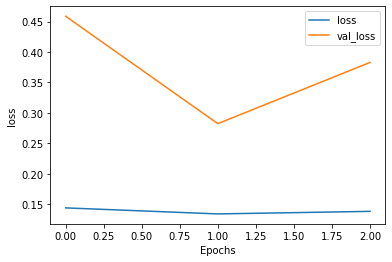

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1496 - accuracy: 0.0065 - val_loss: 0.3438 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1535 - accuracy: 0.0065 - val_loss: 0.4333 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1668 - accuracy: 0.0065 - val_loss: 0.3840 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1209.7821877389074, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1759.134790310704, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1412.4804075147968, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1427.37671455041, shape=(), dtype=float64)
test dates 2019-12-20~2019-12-20
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


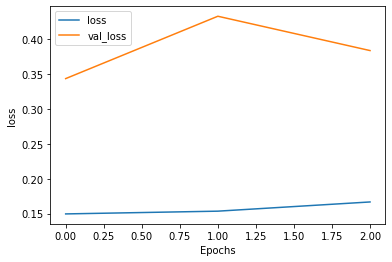

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1562 - accuracy: 0.0065 - val_loss: 0.9826 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 10.2730 - accuracy: 0.0060 - val_loss: 5.6756 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 3.9844 - accuracy: 0.0064 - val_loss: 3.1141 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1630.0870423859033, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2935.6392363355576, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3288.8741288620304, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4274.4387047240425, shape=(), dtype=float64)
test dates 2019-12-23~2019-12-23
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


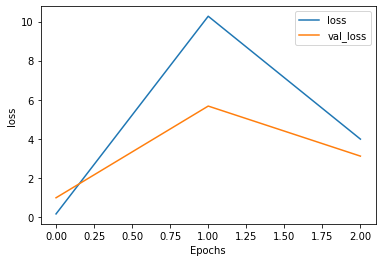

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.4476 - accuracy: 0.0064 - val_loss: 2.1300 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.7675 - accuracy: 0.0065 - val_loss: 1.6933 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.3796 - accuracy: 0.0065 - val_loss: 1.3232 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1690.934488853488, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2655.6481046385006, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2707.3583119315326, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2784.980500538036, shape=(), dtype=float64)
test dates 2019-12-24~2019-12-24
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


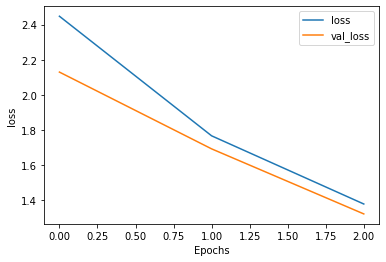

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.0768 - accuracy: 0.0065 - val_loss: 1.2259 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.8960 - accuracy: 0.0064 - val_loss: 1.3683 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7575 - accuracy: 0.0064 - val_loss: 0.8116 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2752.828181997572, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2037.8835450206223, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2147.890500737401, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2333.595508036624, shape=(), dtype=float64)
test dates 2019-12-26~2019-12-26
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


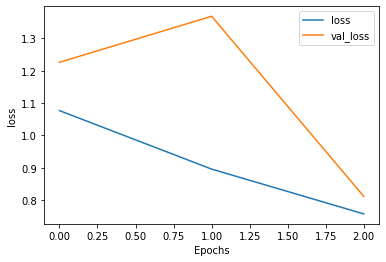

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6208 - accuracy: 0.0065 - val_loss: 0.7238 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5357 - accuracy: 0.0065 - val_loss: 0.7396 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5014 - accuracy: 0.0065 - val_loss: 0.5580 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-3371.1057596151973, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2796.4739143227794, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-758.0691403164866, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-724.3779897219406, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-12-27~2019-12-27
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


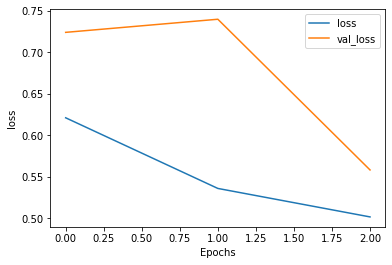

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4238 - accuracy: 0.0064 - val_loss: 0.7054 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3706 - accuracy: 0.0065 - val_loss: 0.5499 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3314 - accuracy: 0.0065 - val_loss: 0.7146 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-806.493144021319, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1863.6349541390118, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1971.2672156594665, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2153.3081045912513, shape=(), dtype=float64)
test dates 2019-12-30~2019-12-30
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


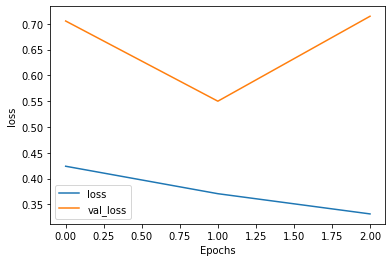

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3056 - accuracy: 0.0065 - val_loss: 0.4567 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2664 - accuracy: 0.0065 - val_loss: 0.7252 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2587 - accuracy: 0.0065 - val_loss: 0.6184 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3237.0771140140278, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1824.0349641848834, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1969.605926196609, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2280.468139793696, shape=(), dtype=float64)
test dates 2020-01-02~2020-01-02
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


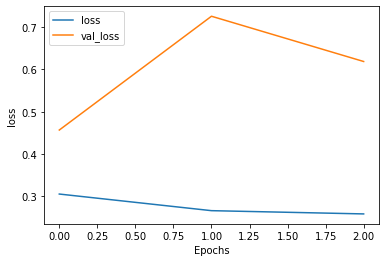

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2510 - accuracy: 0.0065 - val_loss: 0.3263 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2218 - accuracy: 0.0065 - val_loss: 0.3155 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2419 - accuracy: 0.0065 - val_loss: 0.2884 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-5101.793835954074, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1707.3222044106683, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1710.9184221308876, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1715.72894301114, shape=(), dtype=float64)
test dates 2020-01-03~2020-01-03
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


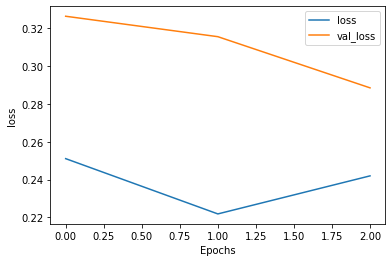

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3374 - accuracy: 0.0064 - val_loss: 1.1006 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3441 - accuracy: 0.0065 - val_loss: 0.2812 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1789 - accuracy: 0.0065 - val_loss: 0.2798 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2062.539449654179, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2035.1622388209407, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2332.3173412811516, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3212.1139923749083, shape=(), dtype=float64)
test dates 2020-01-06~2020-01-06
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


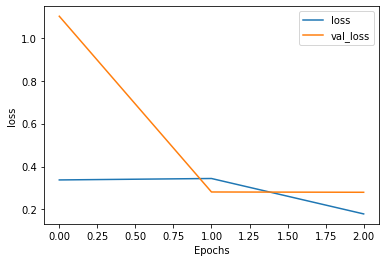

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1780 - accuracy: 0.0065 - val_loss: 0.3759 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1584 - accuracy: 0.0065 - val_loss: 0.3309 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1865 - accuracy: 0.0065 - val_loss: 0.2615 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-4430.174424233856, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1587.7156625474538, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1591.0890826544871, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1595.703943269735, shape=(), dtype=float64)
test dates 2020-01-07~2020-01-07
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


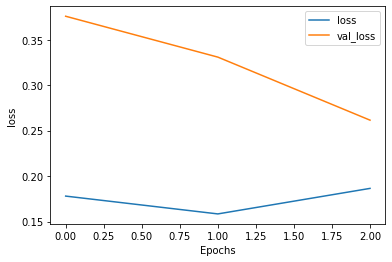

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1817 - accuracy: 0.0065 - val_loss: 0.3854 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4859 - accuracy: 0.0064 - val_loss: 0.6043 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1927 - accuracy: 0.0065 - val_loss: 0.2560 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1849.8950516023128, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1774.3687328591216, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1947.1964344056041, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2409.2102687216043, shape=(), dtype=float64)
test dates 2020-01-08~2020-01-08
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


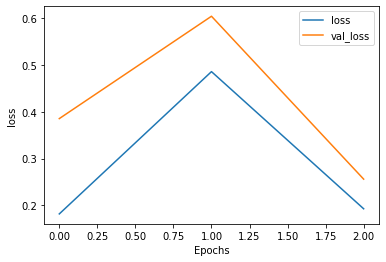

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1434 - accuracy: 0.0065 - val_loss: 0.1522 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1401 - accuracy: 0.0065 - val_loss: 0.1523 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1407 - accuracy: 0.0065 - val_loss: 0.1365 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-134694.02492376344, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1410.7449783506454, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1437.8276348297131, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1478.9832662543145, shape=(), dtype=float64)
test dates 2020-01-09~2020-01-09
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


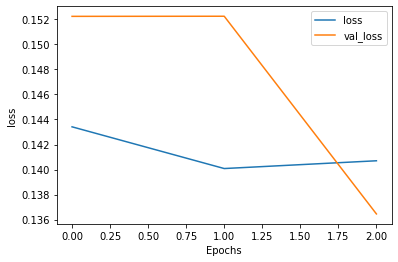

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1574 - accuracy: 0.0065 - val_loss: 0.2078 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1397 - accuracy: 0.0065 - val_loss: 0.2691 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1639 - accuracy: 0.0065 - val_loss: 0.3177 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1874.8886102180595, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2017.5885062880047, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2705.239547935727, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-610.4632915931542, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-01-10~2020-01-10
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, s

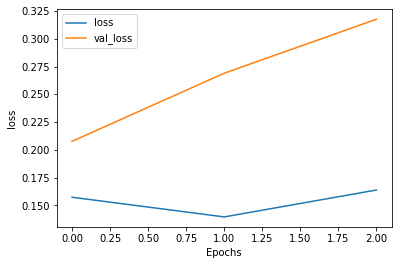

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1563 - accuracy: 0.0065 - val_loss: 0.2640 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1670 - accuracy: 0.0065 - val_loss: 0.3408 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.2174 - accuracy: 0.0063 - val_loss: 0.4297 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-677.8733376850699, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1622.798836922825, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1754.506105892012, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2034.4888282259083, shape=(), dtype=float64)
test dates 2020-01-13~2020-01-13
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


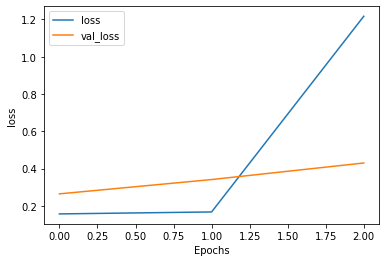

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2078 - accuracy: 0.0065 - val_loss: 0.3216 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3092 - accuracy: 0.0065 - val_loss: 0.2584 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1431 - accuracy: 0.0065 - val_loss: 0.3021 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-4248.865917826776, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1517.9711681426443, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1519.7662149458972, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1522.0529928750345, shape=(), dtype=float64)
test dates 2020-01-14~2020-01-14
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


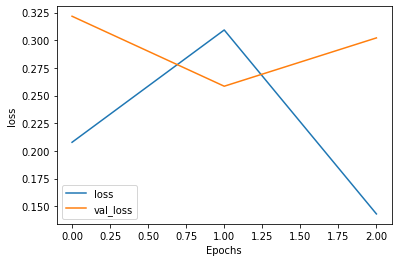

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1514 - accuracy: 0.0065 - val_loss: 0.3235 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1239 - accuracy: 0.0065 - val_loss: 0.2352 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1264 - accuracy: 0.0065 - val_loss: 0.2524 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1912.7823201369529, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1731.1490159521882, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2117.8308004193527, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-7128.708810415344, shape=(), dtype=float64)
test dates 2020-01-15~2020-01-15
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


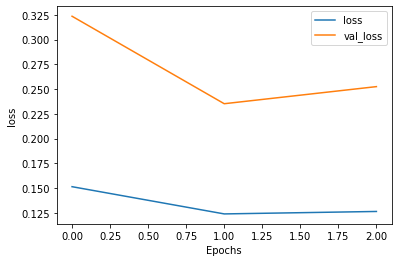

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1377 - accuracy: 0.0065 - val_loss: 0.3258 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1626 - accuracy: 0.0065 - val_loss: 0.2877 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1346 - accuracy: 0.0065 - val_loss: 0.5291 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2104.8261320490924, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1595.6442256611772, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1612.4110353411018, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1637.0676797802023, shape=(), dtype=float64)
test dates 2020-01-16~2020-01-16
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


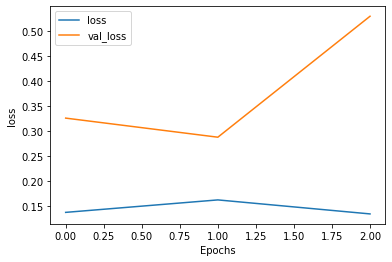

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2127 - accuracy: 0.0065 - val_loss: 0.2334 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1564 - accuracy: 0.0065 - val_loss: 0.4575 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1622 - accuracy: 0.0065 - val_loss: 0.2708 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2095.753699206732, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4003.0419774915317, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-700.258896461191, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-699.8183470973854, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-01-17~2020-01-17
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, sha

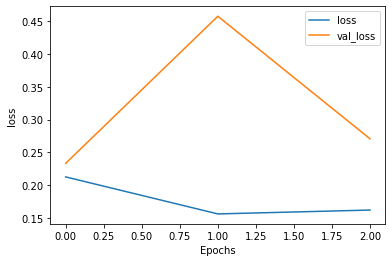

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1436 - accuracy: 0.0065 - val_loss: 0.2948 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2239 - accuracy: 0.0065 - val_loss: 0.3497 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1420 - accuracy: 0.0065 - val_loss: 0.2316 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-758.7434057275809, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2056.169579313043, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2512.0626024479902, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-6329.45892278234, shape=(), dtype=float64)
test dates 2020-01-20~2020-01-20
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


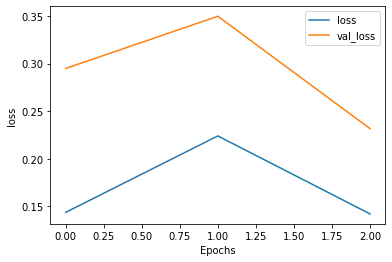

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2299 - accuracy: 0.0065 - val_loss: 0.2209 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1926 - accuracy: 0.0065 - val_loss: 0.2928 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1493 - accuracy: 0.0065 - val_loss: 0.2405 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-519.0663713168218, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-901.0806164385363, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-877.8175172950195, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-880.221105349839, shape=(), dtype=float64)
test dates 2020-01-21~2020-01-21
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


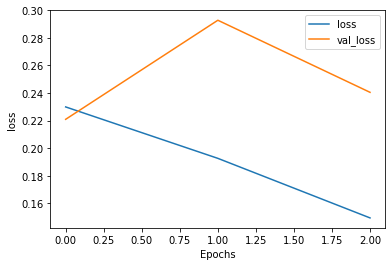

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1450 - accuracy: 0.0065 - val_loss: 0.3982 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.3762 - accuracy: 0.0062 - val_loss: 0.3295 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1932 - accuracy: 0.0065 - val_loss: 0.2151 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1006.6047042330171, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1546.4891612358497, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1627.6794980702525, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1774.7173999206072, shape=(), dtype=float64)
test dates 2020-01-22~2020-01-22
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


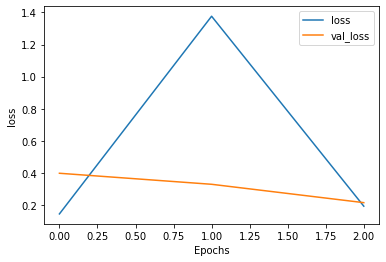

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1346 - accuracy: 0.0065 - val_loss: 0.1451 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.5455 - accuracy: 0.0062 - val_loss: 1.9748 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.2922 - accuracy: 0.0064 - val_loss: 1.4095 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2735.3288898366973, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1421.2122852939776, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1431.3744538514613, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1444.2743340197328, shape=(), dtype=float64)
test dates 2020-01-23~2020-01-23
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


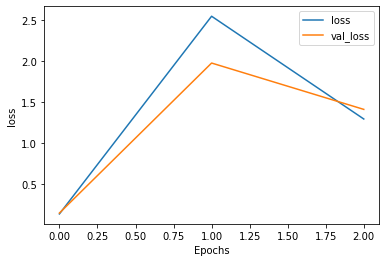

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6145 - accuracy: 0.0064 - val_loss: 0.5129 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3099 - accuracy: 0.0065 - val_loss: 0.4407 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2358 - accuracy: 0.0065 - val_loss: 0.3961 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1607.5852438383674, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1290.7356095322386, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1316.4420144368098, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1354.8845744648384, shape=(), dtype=float64)
test dates 2020-01-28~2020-01-28
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


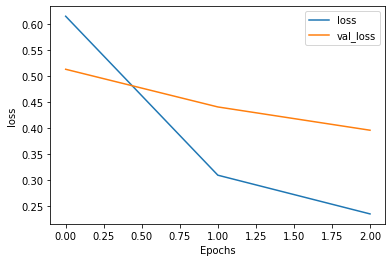

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1944 - accuracy: 0.0065 - val_loss: 0.4532 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1709 - accuracy: 0.0065 - val_loss: 0.4915 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1581 - accuracy: 0.0065 - val_loss: 0.3924 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1912.423205254446, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1744.181661958768, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3601.128187822435, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-470.02135194338564, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-01-29~2020-01-29
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


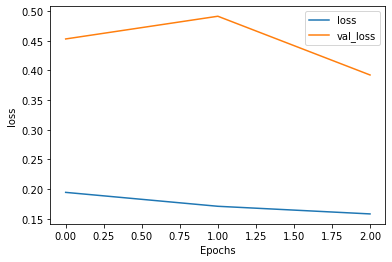

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1488 - accuracy: 0.0065 - val_loss: 0.4154 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1501 - accuracy: 0.0065 - val_loss: 0.4044 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1435 - accuracy: 0.0065 - val_loss: 0.4153 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-521.0576316898158, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1297.6931330990167, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1304.6878224568316, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1316.1085090774961, shape=(), dtype=float64)
test dates 2020-01-30~2020-01-30
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


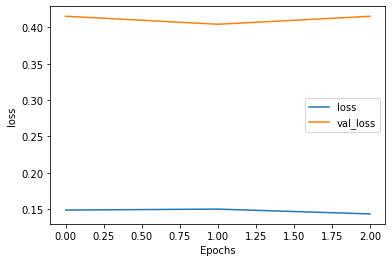

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1329 - accuracy: 0.0065 - val_loss: 0.4002 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1693 - accuracy: 0.0065 - val_loss: 0.4276 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1308 - accuracy: 0.0065 - val_loss: 0.3779 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1619.306774331904, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2135.6259244544935, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5295.535117940002, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-512.8467998242513, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-01-31~2020-01-31
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


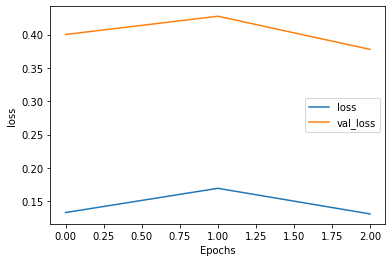

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1290 - accuracy: 0.0065 - val_loss: 0.2498 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.9504 - accuracy: 0.0063 - val_loss: 0.5643 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 3.1916 - accuracy: 0.0061 - val_loss: 1.8663 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-529.9951089336712, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4654.351572552205, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-700.5155163738829, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-709.7415541524473, shape=(), dtype=float64)
test dates 2020-02-03~2020-02-03
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


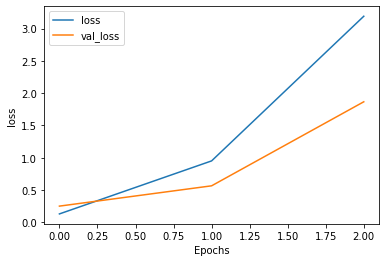

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.0688 - accuracy: 0.0064 - val_loss: 0.8684 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6084 - accuracy: 0.0064 - val_loss: 0.6525 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.1076 - accuracy: 0.0063 - val_loss: 1.3400 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-797.7611294291931, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1307.916934624307, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1358.6360656553327, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1434.3935806036284, shape=(), dtype=float64)
test dates 2020-02-04~2020-02-04
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


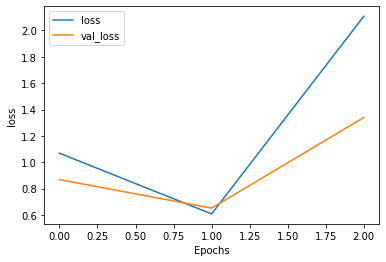

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7597 - accuracy: 0.0065 - val_loss: 0.7593 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4508 - accuracy: 0.0065 - val_loss: 0.5347 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3277 - accuracy: 0.0065 - val_loss: 0.3784 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2068.567023712436, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3876.490181453072, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-708.2344196893097, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-725.8885800740048, shape=(), dtype=float64)
test dates 2020-02-05~2020-02-05
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


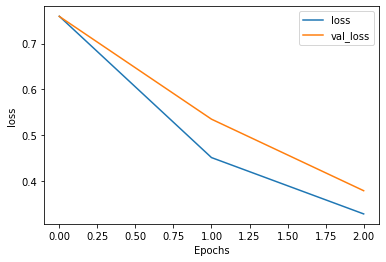

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2687 - accuracy: 0.0065 - val_loss: 0.3339 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2289 - accuracy: 0.0065 - val_loss: 0.2876 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2120 - accuracy: 0.0065 - val_loss: 0.2859 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-840.8275401465886, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-988.3917038797063, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1002.1820694131197, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1023.5266458472192, shape=(), dtype=float64)
test dates 2020-02-06~2020-02-06
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


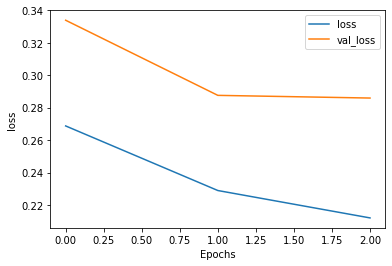

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1951 - accuracy: 0.0065 - val_loss: 0.2440 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1749 - accuracy: 0.0065 - val_loss: 0.2137 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1615 - accuracy: 0.0065 - val_loss: 0.2470 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1260.624007980755, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1593.7704626805237, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1953.1548924594279, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4853.108173985241, shape=(), dtype=float64)
test dates 2020-02-07~2020-02-07
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


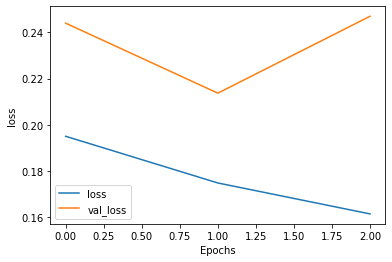

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1605 - accuracy: 0.0065 - val_loss: 0.2066 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1553 - accuracy: 0.0065 - val_loss: 0.2683 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1533 - accuracy: 0.0065 - val_loss: 0.2623 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2675.8968722591526, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1349.1232913403342, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1358.31178163773, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1370.7902843552429, shape=(), dtype=float64)
test dates 2020-02-10~2020-02-10
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


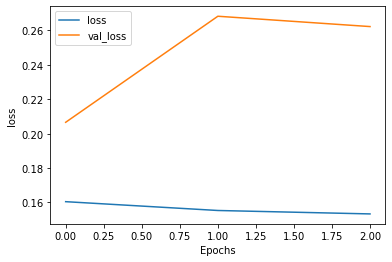

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1653 - accuracy: 0.0065 - val_loss: 0.2322 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1641 - accuracy: 0.0065 - val_loss: 0.2586 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2476 - accuracy: 0.0064 - val_loss: 0.2398 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1495.3675583311322, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1185.710727717356, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1215.5467798278894, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1259.750619334444, shape=(), dtype=float64)
test dates 2020-02-11~2020-02-11
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


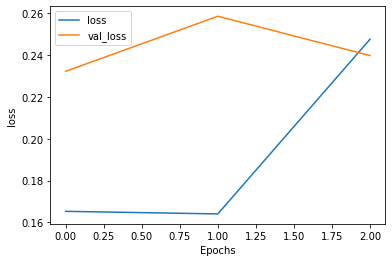

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1389 - accuracy: 0.0065 - val_loss: 0.2172 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1404 - accuracy: 0.0065 - val_loss: 0.2319 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1673 - accuracy: 0.0065 - val_loss: 0.2024 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1692.2397790877026, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1475.8729739538435, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-584.1680783870842, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-584.5345413518122, shape=(), dtype=float64)
test dates 2020-02-12~2020-02-12
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


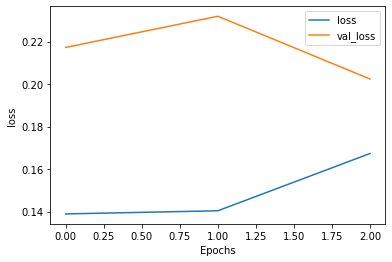

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1368 - accuracy: 0.0065 - val_loss: 0.2755 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1909 - accuracy: 0.0065 - val_loss: 0.2751 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1364 - accuracy: 0.0065 - val_loss: 0.2591 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-670.5123171285907, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-851.687531567423, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-619.2343281322087, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-619.6920683037329, shape=(), dtype=float64)
test dates 2020-02-13~2020-02-13
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


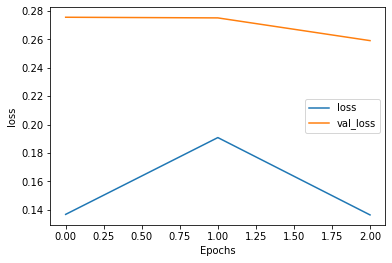

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1368 - accuracy: 0.0065 - val_loss: 0.1890 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2772 - accuracy: 0.0064 - val_loss: 0.6171 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1899 - accuracy: 0.0065 - val_loss: 0.2009 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-620.5648215600282, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1613.2640336995673, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2359.8893903083076, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-6802.534286615215, shape=(), dtype=float64)
test dates 2020-02-14~2020-02-14
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


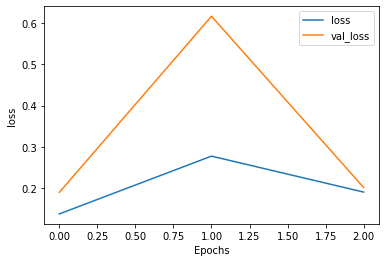

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1482 - accuracy: 0.0065 - val_loss: 0.1629 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 6.4979 - accuracy: 0.0061 - val_loss: 30.4556 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 24.2015 - accuracy: 0.0051 - val_loss: 19.3213 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-946.408194027807, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1486.3517241172067, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-516.7128056090016, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-491.64578676541316, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-02-17~2020-02-17
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0,

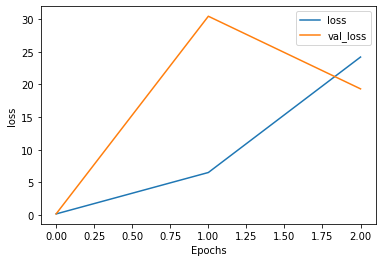

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 17.0178 - accuracy: 0.0058 - val_loss: 15.0060 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 13.5145 - accuracy: 0.0061 - val_loss: 12.2642 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 11.1251 - accuracy: 0.0061 - val_loss: 10.2534 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-533.540146067456, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1347.01309617529, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-608.4528361306637, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-391.97273869409264, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-02-18~2020-02-18
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


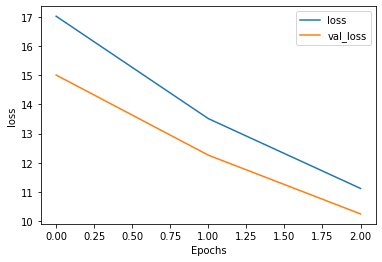

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 9.3244 - accuracy: 0.0062 - val_loss: 8.6434 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 7.8985 - accuracy: 0.0063 - val_loss: 7.3818 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 6.7554 - accuracy: 0.0063 - val_loss: 6.3719 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-402.342741827038, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3815.073306442102, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-466.7064387052162, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-467.0976366037278, shape=(), dtype=float64)
test dates 2020-02-19~2020-02-19
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


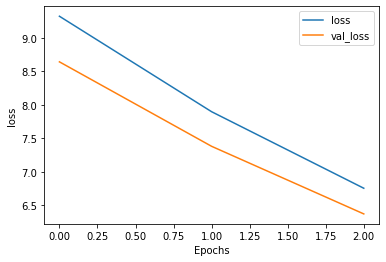

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 5.7960 - accuracy: 0.0063 - val_loss: 5.4829 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 4.9956 - accuracy: 0.0063 - val_loss: 4.6788 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 4.3500 - accuracy: 0.0063 - val_loss: 4.1223 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-484.1482373507569, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-939.0154082798292, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-973.4138909799167, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1030.9655795050317, shape=(), dtype=float64)
test dates 2020-02-20~2020-02-20
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


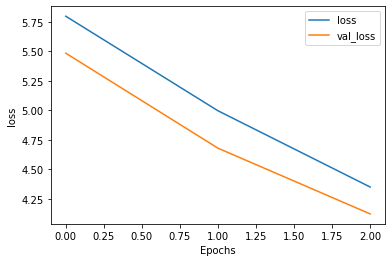

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 3.7605 - accuracy: 0.0064 - val_loss: 3.7219 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 3.2661 - accuracy: 0.0063 - val_loss: 3.2772 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.8484 - accuracy: 0.0063 - val_loss: 2.9189 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1282.6656939102666, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2218.5586678120067, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-371.06884775905286, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-371.5775444720239, shape=(), dtype=float64)
test dates 2020-02-21~2020-02-21
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


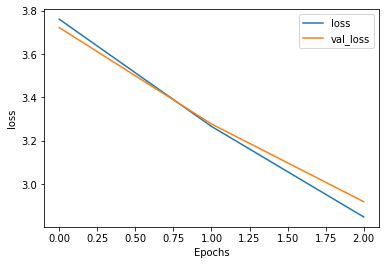

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.4887 - accuracy: 0.0064 - val_loss: 2.8142 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.1749 - accuracy: 0.0063 - val_loss: 2.5602 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.9059 - accuracy: 0.0063 - val_loss: 2.2423 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-391.08814095859805, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-553.3954970122842, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-550.2726883146212, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-563.6413281996028, shape=(), dtype=float64)
test dates 2020-02-24~2020-02-24
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


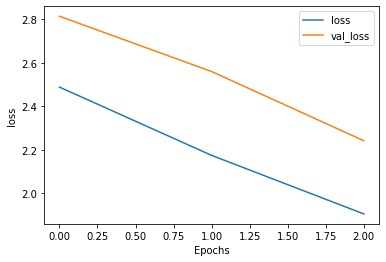

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.6684 - accuracy: 0.0064 - val_loss: 2.1074 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.4680 - accuracy: 0.0064 - val_loss: 1.9298 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.2941 - accuracy: 0.0064 - val_loss: 1.7558 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-671.4004476521013, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-919.913751345313, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1024.4177705111229, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1304.0395886088104, shape=(), dtype=float64)
test dates 2020-02-25~2020-02-25
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


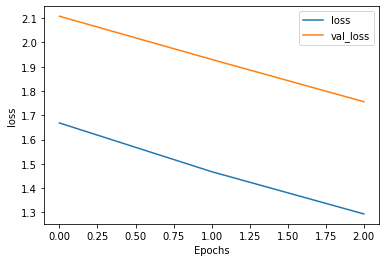

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.1495 - accuracy: 0.0064 - val_loss: 1.5470 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.0094 - accuracy: 0.0064 - val_loss: 1.5197 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.8996 - accuracy: 0.0064 - val_loss: 1.3607 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-10927.657821483474, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-701.7883144739476, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-702.775241058248, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-704.059959438776, shape=(), dtype=float64)
test dates 2020-02-26~2020-02-26
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


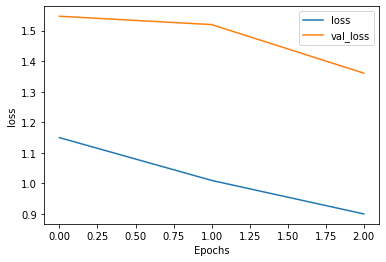

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7987 - accuracy: 0.0064 - val_loss: 1.4338 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.7483 - accuracy: 0.0064 - val_loss: 1.3861 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6459 - accuracy: 0.0064 - val_loss: 1.1434 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-612.8943170308956, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-601.3580365349522, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-674.4719137425443, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-869.2398745189035, shape=(), dtype=float64)
test dates 2020-02-27~2020-02-27
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


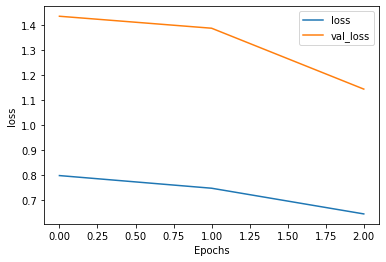

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5767 - accuracy: 0.0064 - val_loss: 1.0385 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5211 - accuracy: 0.0064 - val_loss: 0.8710 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4692 - accuracy: 0.0064 - val_loss: 0.9598 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-215.2359037471699, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-463.0340446663299, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-469.7901624014985, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-480.4334703992093, shape=(), dtype=float64)
test dates 2020-02-28~2020-02-28
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


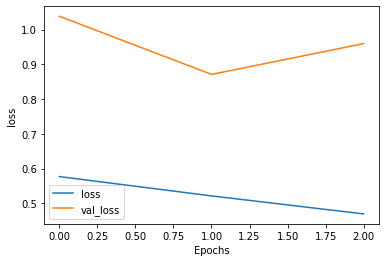

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4354 - accuracy: 0.0064 - val_loss: 0.8959 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3971 - accuracy: 0.0064 - val_loss: 0.7486 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3675 - accuracy: 0.0064 - val_loss: 0.7066 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-622.641154450911, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-517.5317602495178, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-522.0353791577412, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-528.0973686672779, shape=(), dtype=float64)
test dates 2020-03-02~2020-03-02
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


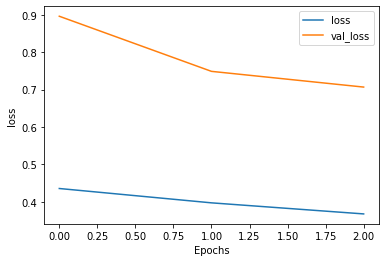

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3433 - accuracy: 0.0064 - val_loss: 0.4450 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3188 - accuracy: 0.0064 - val_loss: 0.4509 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3079 - accuracy: 0.0064 - val_loss: 0.5094 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-669.5342845251865, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1944.7195607583415, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-920.4071119438712, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1459.1143507006054, shape=(), dtype=float64)
test dates 2020-03-03~2020-03-03
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


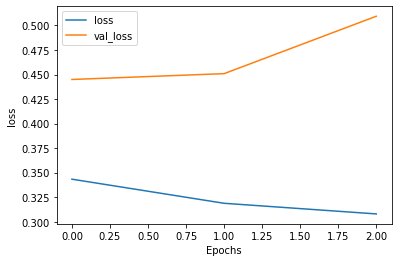

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2777 - accuracy: 0.0064 - val_loss: 0.3456 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2582 - accuracy: 0.0064 - val_loss: 0.3481 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2470 - accuracy: 0.0064 - val_loss: 0.3705 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-180.4136775175419, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-641.9476888672244, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-764.440463261021, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1377.164108781032, shape=(), dtype=float64)
test dates 2020-03-04~2020-03-04
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


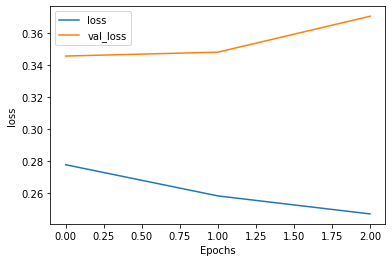

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2413 - accuracy: 0.0064 - val_loss: 0.3081 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2415 - accuracy: 0.0064 - val_loss: 0.3227 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2253 - accuracy: 0.0064 - val_loss: 0.3242 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-170.18866583851758, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-592.3841978219766, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-953.504078887301, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-174.63184037914039, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-03-05~2020-03-05
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, sh

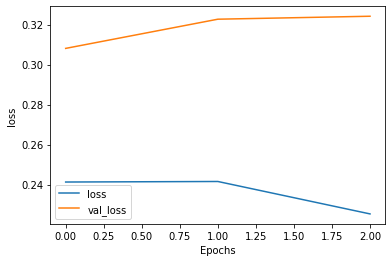

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3292 - accuracy: 0.0064 - val_loss: 0.9999 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2588 - accuracy: 0.0064 - val_loss: 0.3868 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2022 - accuracy: 0.0064 - val_loss: 0.3458 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-191.00900086532226, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-573.1181124000767, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-635.1284008495131, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-771.7521155905108, shape=(), dtype=float64)
test dates 2020-03-06~2020-03-06
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


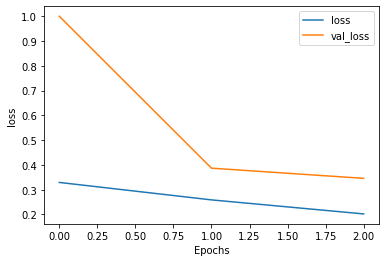

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1964 - accuracy: 0.0064 - val_loss: 0.8674 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1951 - accuracy: 0.0064 - val_loss: 0.9568 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1949 - accuracy: 0.0064 - val_loss: 0.9320 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-4168.235893695184, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-861.82733275474, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-343.1508478208632, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-294.67479458224255, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-03-09~2020-03-09
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shap

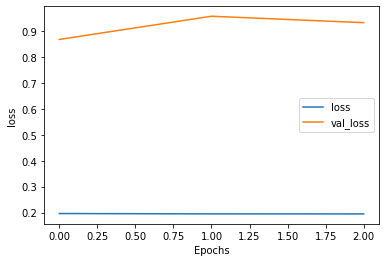

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.4884 - accuracy: 0.0061 - val_loss: 3.4952 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6911 - accuracy: 0.0064 - val_loss: 1.5099 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2943 - accuracy: 0.0064 - val_loss: 0.8742 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-333.8730994392494, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-569.5783317091967, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-618.9891543028369, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-726.5732081189242, shape=(), dtype=float64)
test dates 2020-03-10~2020-03-10
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


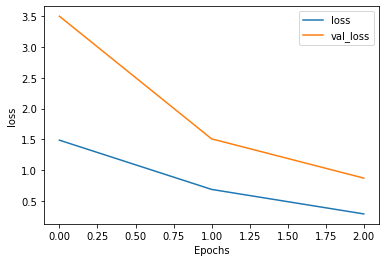

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1867 - accuracy: 0.0064 - val_loss: 0.6653 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1683 - accuracy: 0.0064 - val_loss: 0.6163 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1636 - accuracy: 0.0064 - val_loss: 0.6708 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1806.7999112881066, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-650.7483052603078, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1358.1843963687024, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-216.11580681821138, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-03-11~2020-03-11
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


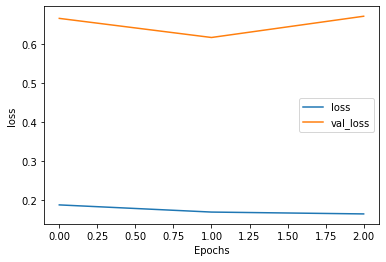

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1695 - accuracy: 0.0064 - val_loss: 0.9922 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1633 - accuracy: 0.0064 - val_loss: 0.8978 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4117 - accuracy: 0.0063 - val_loss: 1.2753 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-235.315588423289, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-780.1653053297127, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1142.3743837992076, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-180.93733568685226, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-03-12~2020-03-12
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


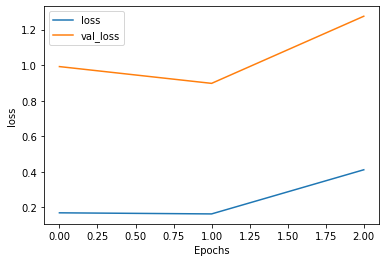

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2010 - accuracy: 0.0064 - val_loss: 0.9779 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1659 - accuracy: 0.0064 - val_loss: 1.3034 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1755 - accuracy: 0.0064 - val_loss: 1.2021 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-200.9115659546605, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-481.2438393396795, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-491.2152054143154, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-505.52617935149175, shape=(), dtype=float64)
test dates 2020-03-13~2020-03-13
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


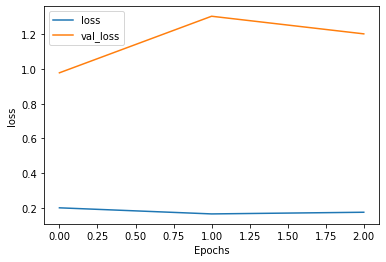

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1707 - accuracy: 0.0064 - val_loss: 1.1050 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1719 - accuracy: 0.0064 - val_loss: 1.0727 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1789 - accuracy: 0.0064 - val_loss: 0.9402 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-674.3460075834081, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-545.9936349999824, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-561.5111004582631, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-583.8034751791298, shape=(), dtype=float64)
test dates 2020-03-16~2020-03-16
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


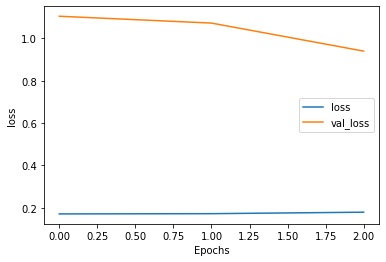

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1692 - accuracy: 0.0064 - val_loss: 1.1135 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1927 - accuracy: 0.0064 - val_loss: 1.0268 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.3425 - accuracy: 0.0061 - val_loss: 4.2889 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-823.8374255813117, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-551.3264692597031, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-553.7627292274071, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-556.86398359368, shape=(), dtype=float64)
test dates 2020-03-17~2020-03-17
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


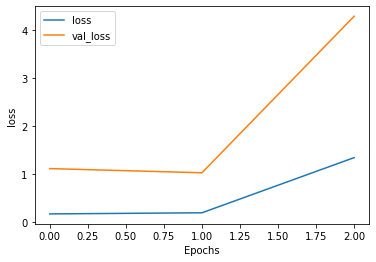

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5592 - accuracy: 0.0064 - val_loss: 1.6433 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2150 - accuracy: 0.0064 - val_loss: 1.8606 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 14s 3ms/sample - loss: 0.1714 - accuracy: 0.0064 - val_loss: 0.8803 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-735.2796259201679, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-630.6865340464437, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-657.2136027691276, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-695.66573956575, shape=(), dtype=float64)
test dates 2020-03-18~2020-03-18
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


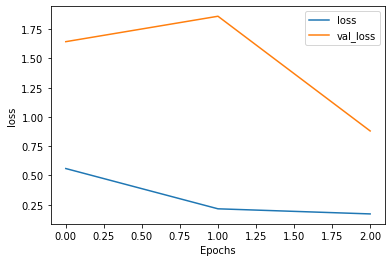

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1577 - accuracy: 0.0064 - val_loss: 2.3497 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1544 - accuracy: 0.0064 - val_loss: 2.7923 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1483 - accuracy: 0.0064 - val_loss: 3.0578 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1102.2195297995945, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-612.5121310518888, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-614.2869779745204, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-616.8082818677034, shape=(), dtype=float64)
test dates 2020-03-19~2020-03-19
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


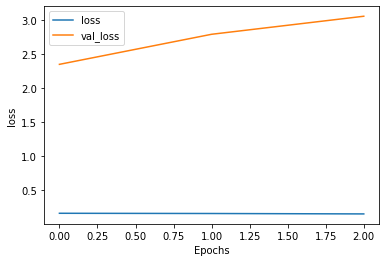

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1590 - accuracy: 0.0064 - val_loss: 1.6766 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4332 - accuracy: 0.0063 - val_loss: 1.6153 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1641 - accuracy: 0.0064 - val_loss: 1.6852 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-980.8773583561614, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-864.3750091904318, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-904.5244552069776, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-970.3336992097007, shape=(), dtype=float64)
test dates 2020-03-20~2020-03-20
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


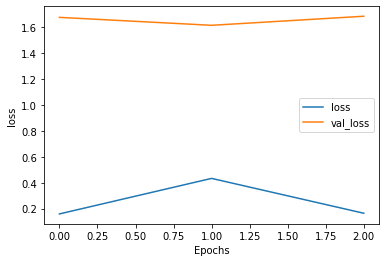

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1630 - accuracy: 0.0064 - val_loss: 0.9515 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1514 - accuracy: 0.0064 - val_loss: 0.9368 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1639 - accuracy: 0.0064 - val_loss: 0.9887 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1485.4449612950873, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-882.2493902447519, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-984.169441929449, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1226.618022863459, shape=(), dtype=float64)
test dates 2020-03-23~2020-03-23
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


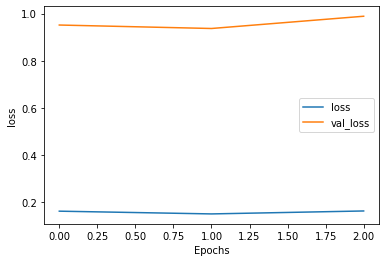

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1622 - accuracy: 0.0064 - val_loss: 0.6779 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1665 - accuracy: 0.0064 - val_loss: 0.8455 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1619 - accuracy: 0.0064 - val_loss: 0.7582 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-20381.194567557974, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1031.199986285357, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-370.92128794190796, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-301.11874974428355, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-03-24~2020-03-24
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, 

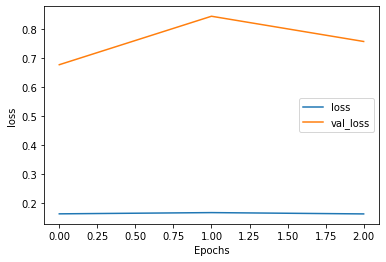

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1971 - accuracy: 0.0064 - val_loss: 3.6167 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6349 - accuracy: 0.0063 - val_loss: 14.6567 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.7343 - accuracy: 0.0060 - val_loss: 4.8951 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-324.92535198198345, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-589.4574315591389, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-601.042176792539, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-617.2526498333788, shape=(), dtype=float64)
test dates 2020-03-25~2020-03-25
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


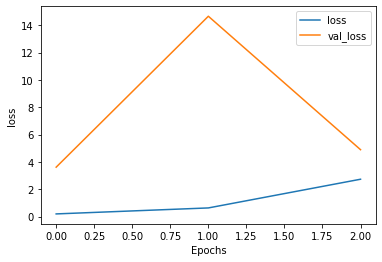

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3660 - accuracy: 0.0064 - val_loss: 3.5394 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2218 - accuracy: 0.0064 - val_loss: 3.4322 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1886 - accuracy: 0.0064 - val_loss: 5.2128 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1426.5147730967349, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1837.1008775578016, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3007.7049490448435, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-486.0423491221366, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-03-26~2020-03-26
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


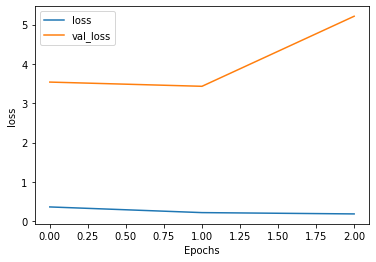

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1807 - accuracy: 0.0064 - val_loss: 2.7744 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1411 - accuracy: 0.0064 - val_loss: 1.4184 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1507 - accuracy: 0.0064 - val_loss: 2.5834 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-531.1874059617729, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1351.2311994324136, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1371.3671556287181, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1402.690447419109, shape=(), dtype=float64)
test dates 2020-03-27~2020-03-27
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


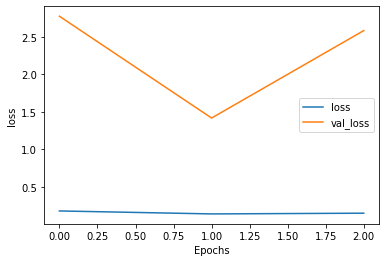

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1454 - accuracy: 0.0064 - val_loss: 0.9547 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1485 - accuracy: 0.0064 - val_loss: 0.8856 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1350 - accuracy: 0.0064 - val_loss: 3.4425 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1789.5986221043722, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1497.7634357258123, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1509.3838798971947, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1524.493350694498, shape=(), dtype=float64)
test dates 2020-03-30~2020-03-30
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


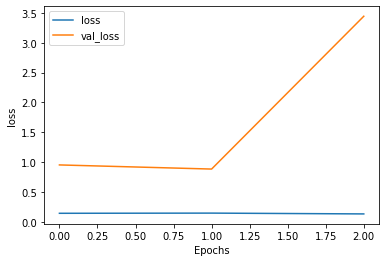

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1417 - accuracy: 0.0064 - val_loss: 1.0821 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1421 - accuracy: 0.0064 - val_loss: 0.5678 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1573 - accuracy: 0.0064 - val_loss: 1.1798 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1894.7106827863363, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-858.3157581052254, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-817.5802402783679, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-834.498003522008, shape=(), dtype=float64)
test dates 2020-03-31~2020-03-31
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


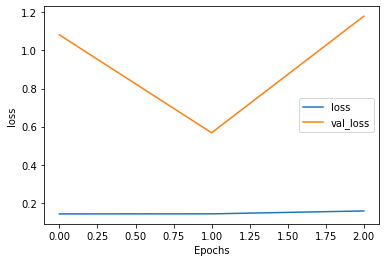

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2198 - accuracy: 0.0064 - val_loss: 5.9141 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2031 - accuracy: 0.0064 - val_loss: 1.0430 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1692 - accuracy: 0.0064 - val_loss: 0.9247 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-963.0300368783737, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1477.3993945759237, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1497.924722400774, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1526.3039150339343, shape=(), dtype=float64)
test dates 2020-04-01~2020-04-01
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


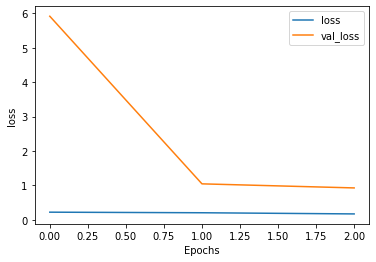

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1633 - accuracy: 0.0064 - val_loss: 0.5605 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1685 - accuracy: 0.0064 - val_loss: 0.2429 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2309 - accuracy: 0.0064 - val_loss: 8.8103 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1957.1985746606163, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1528.399223297818, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1620.7493960437132, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1794.2890589347962, shape=(), dtype=float64)
test dates 2020-04-02~2020-04-02
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


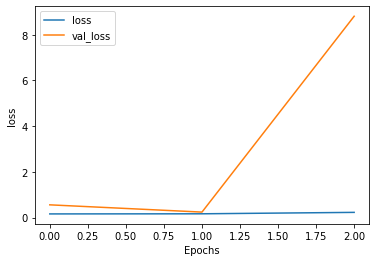

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2086 - accuracy: 0.0064 - val_loss: 0.8511 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1602 - accuracy: 0.0064 - val_loss: 0.6380 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1548 - accuracy: 0.0064 - val_loss: 0.4219 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-3065.8317093114442, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1228.1939712844803, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1234.0298323257723, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1244.1366167236397, shape=(), dtype=float64)
test dates 2020-04-03~2020-04-03
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


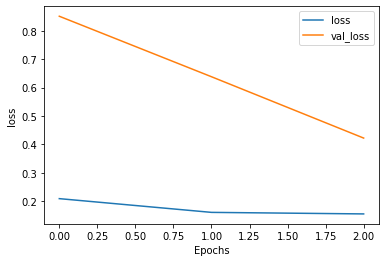

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1468 - accuracy: 0.0064 - val_loss: 0.7160 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1644 - accuracy: 0.0064 - val_loss: 0.7059 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1563 - accuracy: 0.0064 - val_loss: 0.4822 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1530.0452777203063, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1493.847028749894, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1496.2556819212016, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1499.8300042963174, shape=(), dtype=float64)
test dates 2020-04-06~2020-04-06
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


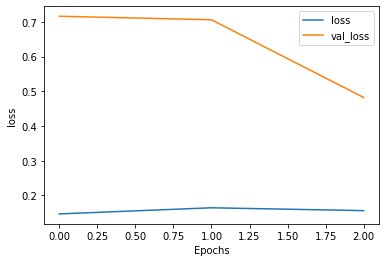

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1918 - accuracy: 0.0064 - val_loss: 0.9721 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1609 - accuracy: 0.0064 - val_loss: 1.1203 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1832 - accuracy: 0.0064 - val_loss: 0.9821 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1983.6987415036272, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2178.1995067098173, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3417.7627816835393, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-532.5068300470186, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-04-07~2020-04-07
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, 

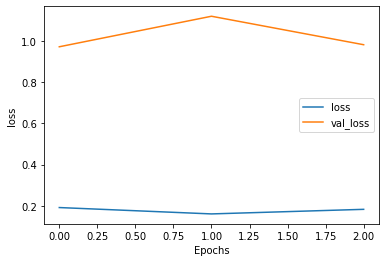

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1727 - accuracy: 0.0064 - val_loss: 0.7475 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1495 - accuracy: 0.0064 - val_loss: 0.8114 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3235 - accuracy: 0.0064 - val_loss: 0.7572 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-706.2538987647797, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1781.9685400223436, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2046.9621396743191, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2887.170454894509, shape=(), dtype=float64)
test dates 2020-04-08~2020-04-08
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


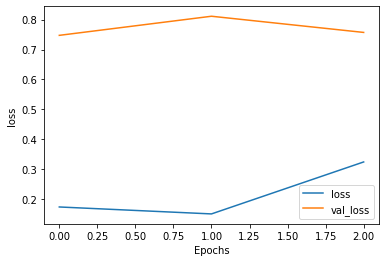

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1524 - accuracy: 0.0064 - val_loss: 0.6502 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1607 - accuracy: 0.0064 - val_loss: 0.3220 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2522 - accuracy: 0.0064 - val_loss: 0.3605 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-723.1584806116302, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1941.3063147043413, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4764.449741513313, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1247.3852634510915, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-04-09~2020-04-09
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


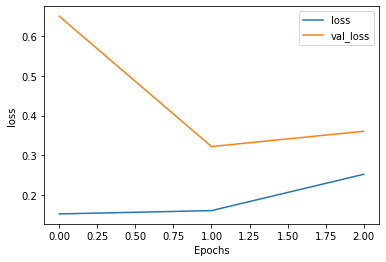

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 4.4862 - accuracy: 0.0061 - val_loss: 48.2281 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 29.3164 - accuracy: 0.0051 - val_loss: 18.3223 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 12.6986 - accuracy: 0.0059 - val_loss: 9.6133 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1448.1503482109981, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1616.5697864322678, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1664.1454633376252, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1754.3590786226011, shape=(), dtype=float64)
test dates 2020-04-10~2020-04-10
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


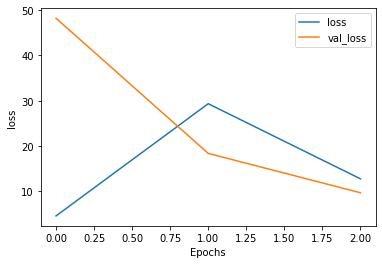

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 6.9724 - accuracy: 0.0061 - val_loss: 6.3165 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 4.2869 - accuracy: 0.0061 - val_loss: 4.8691 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.8239 - accuracy: 0.0062 - val_loss: 2.8104 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2807.4809195174635, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1685.3644357285714, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1900.5728959408982, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2665.0423225002237, shape=(), dtype=float64)
test dates 2020-04-13~2020-04-13
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


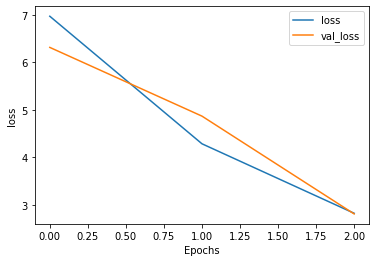

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.9596 - accuracy: 0.0062 - val_loss: 2.1963 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.4269 - accuracy: 0.0062 - val_loss: 2.7063 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.0852 - accuracy: 0.0062 - val_loss: 1.6108 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1079.387838037262, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1785.7593684704727, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1797.582965981294, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1814.3963703083828, shape=(), dtype=float64)
test dates 2020-04-14~2020-04-14
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


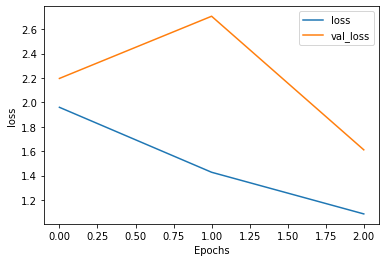

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.8395 - accuracy: 0.0063 - val_loss: 1.5069 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6748 - accuracy: 0.0063 - val_loss: 1.0901 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5473 - accuracy: 0.0063 - val_loss: 1.0898 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2231.54087634394, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1716.508507939916, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1754.840996681554, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1815.8554612166545, shape=(), dtype=float64)
test dates 2020-04-16~2020-04-16
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


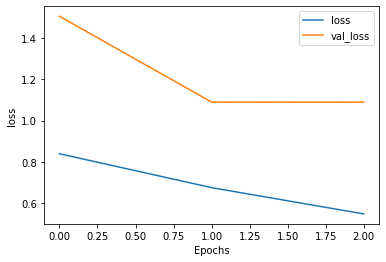

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4914 - accuracy: 0.0062 - val_loss: 1.4528 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4060 - accuracy: 0.0063 - val_loss: 0.8257 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3440 - accuracy: 0.0063 - val_loss: 0.6602 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2428.623487989116, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3738.7722036324712, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2750.40582161664, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1610.5029100599427, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-04-17~2020-04-17
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


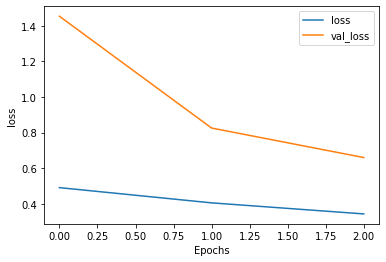

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.3125 - accuracy: 0.0063 - val_loss: 0.7498 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2885 - accuracy: 0.0063 - val_loss: 0.6236 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2538 - accuracy: 0.0063 - val_loss: 0.5099 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2131.347213822354, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1939.0225994628502, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1956.097627339055, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1980.38446704442, shape=(), dtype=float64)
test dates 2020-04-20~2020-04-20
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


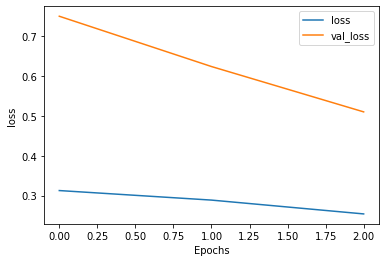

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2387 - accuracy: 0.0063 - val_loss: 0.4396 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2195 - accuracy: 0.0063 - val_loss: 0.4309 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2046 - accuracy: 0.0063 - val_loss: 0.4377 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2542.827220681971, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2559.2488950882525, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3130.141072432075, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-8709.841476160918, shape=(), dtype=float64)
test dates 2020-04-21~2020-04-21
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


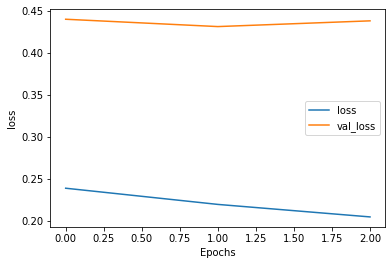

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2435 - accuracy: 0.0063 - val_loss: 0.3457 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1892 - accuracy: 0.0063 - val_loss: 0.4385 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1976 - accuracy: 0.0063 - val_loss: 0.2615 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1488.4943508395509, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2104.773842671848, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2175.2439693400634, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2287.3314036288684, shape=(), dtype=float64)
test dates 2020-04-22~2020-04-22
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


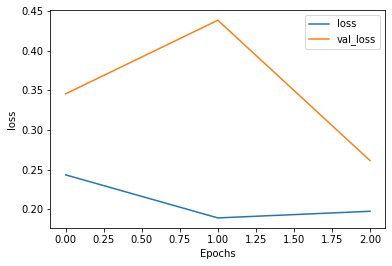

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1750 - accuracy: 0.0063 - val_loss: 0.3523 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1735 - accuracy: 0.0063 - val_loss: 0.3789 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1759 - accuracy: 0.0063 - val_loss: 0.3646 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-3070.295986477062, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2097.211893514759, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2105.586198420629, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2117.410066243678, shape=(), dtype=float64)
test dates 2020-04-23~2020-04-23
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


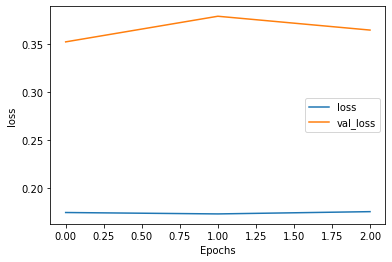

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1682 - accuracy: 0.0063 - val_loss: 0.4000 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1903 - accuracy: 0.0063 - val_loss: 0.4927 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1642 - accuracy: 0.0063 - val_loss: 0.2878 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2825.085087039428, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2103.980706478718, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2135.1356112047793, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2184.3573334278094, shape=(), dtype=float64)
test dates 2020-04-24~2020-04-24
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


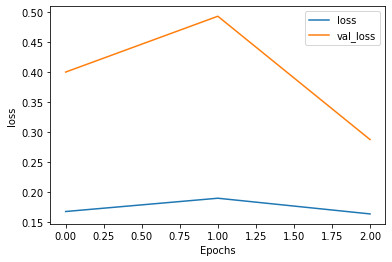

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1729 - accuracy: 0.0063 - val_loss: 0.3961 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2654 - accuracy: 0.0062 - val_loss: 1.0831 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1938 - accuracy: 0.0063 - val_loss: 0.2861 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2731.1518769450927, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2202.4023888531224, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2223.5318996411397, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2253.665602706686, shape=(), dtype=float64)
test dates 2020-04-27~2020-04-27
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


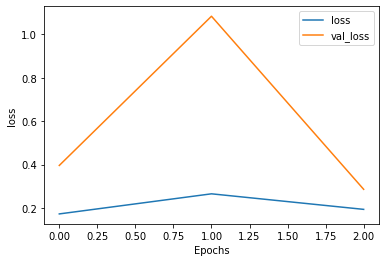

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1533 - accuracy: 0.0063 - val_loss: 0.3378 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1572 - accuracy: 0.0063 - val_loss: 0.5810 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2038 - accuracy: 0.0063 - val_loss: 0.4701 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2777.096775044604, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3231.53321987627, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-863.3946363882886, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-808.8835712421151, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-04-28~2020-04-28
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shap

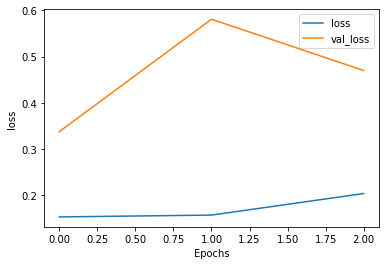

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2110 - accuracy: 0.0063 - val_loss: 0.4229 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1618 - accuracy: 0.0063 - val_loss: 0.2950 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1568 - accuracy: 0.0063 - val_loss: 0.2672 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-1047.2388605713757, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5383.645328295976, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1962.617078282938, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2028.254115859175, shape=(), dtype=float64)
test dates 2020-04-29~2020-04-29
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


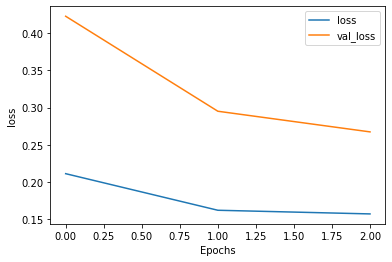

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1604 - accuracy: 0.0063 - val_loss: 0.4649 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.6534 - accuracy: 0.0061 - val_loss: 0.4177 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1779 - accuracy: 0.0063 - val_loss: 0.4422 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-3238.354726388323, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4658.966220727478, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2969.20089786105, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4622.835923395453, shape=(), dtype=float64)
test dates 2020-05-04~2020-05-04
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


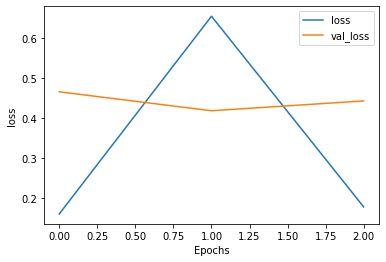

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1577 - accuracy: 0.0063 - val_loss: 0.3353 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1633 - accuracy: 0.0063 - val_loss: 0.3534 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 2.4092 - accuracy: 0.0060 - val_loss: 2.5652 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-1619.831126712469, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3352.1114283891143, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3534.367122591508, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3879.0648762181463, shape=(), dtype=float64)
test dates 2020-05-06~2020-05-06
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


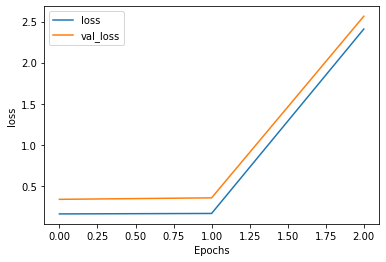

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.0134 - accuracy: 0.0063 - val_loss: 0.7885 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.4056 - accuracy: 0.0063 - val_loss: 0.5897 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2691 - accuracy: 0.0063 - val_loss: 0.5428 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-177604.2122652192, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3119.705030918549, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3272.2306927930445, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-3512.2941848336836, shape=(), dtype=float64)
test dates 2020-05-07~2020-05-07
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


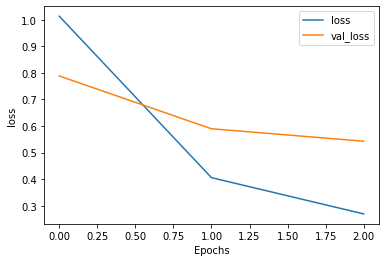

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2048 - accuracy: 0.0063 - val_loss: 0.3953 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2134 - accuracy: 0.0063 - val_loss: 0.7054 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1720 - accuracy: 0.0063 - val_loss: 0.3110 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-6618.949245042648, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2406.863512500176, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2278.016169303067, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-2303.050760318218, shape=(), dtype=float64)
test dates 2020-05-08~2020-05-08
accuracy1 =  tf.Tensor(1.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


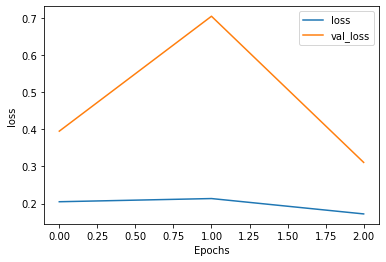

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1527 - accuracy: 0.0063 - val_loss: 0.1664 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1398 - accuracy: 0.0063 - val_loss: 0.2716 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.3784 - accuracy: 0.0061 - val_loss: 1.9400 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-2641.0565920565105, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5587.138039384015, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-10949.58822357432, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4086.290005651311, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-05-11~2020-05-11
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, sh

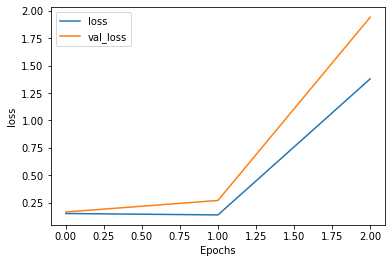

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.5937 - accuracy: 0.0063 - val_loss: 0.5116 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1870 - accuracy: 0.0063 - val_loss: 0.3786 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1568 - accuracy: 0.0063 - val_loss: 0.6522 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-5007.432768726028, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-6439.932081413222, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-16307.385222933583, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-1551.2889527524567, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-05-12~2020-05-12
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


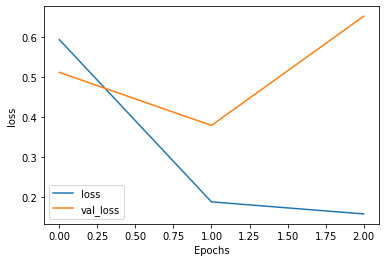

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1404 - accuracy: 0.0063 - val_loss: 0.5761 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1295 - accuracy: 0.0063 - val_loss: 0.3894 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1297 - accuracy: 0.0063 - val_loss: 0.3442 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-2348.298953336764, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5120.3784464041455, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5140.435476077595, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-5165.338031795007, shape=(), dtype=float64)
test dates 2020-05-13~2020-05-13
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(0.0, shape=(), dtype=float64)


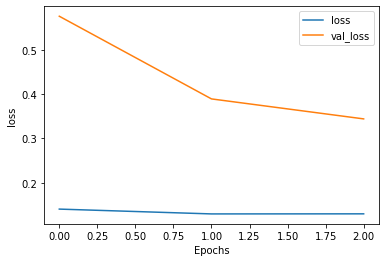

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1311 - accuracy: 0.0063 - val_loss: 0.1858 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1313 - accuracy: 0.0063 - val_loss: 7.0439 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 1.4400 - accuracy: 0.0060 - val_loss: 0.3823 - val_accuracy: 0.0000e+00
Epoch 00003: early stopping
prediction2_MSE = tf.Tensor(-8941.325480437377, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-8130.880996806904, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-8466.21296408394, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-9001.267741505977, shape=(), dtype=float64)
test dates 2020-05-14~2020-05-14
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


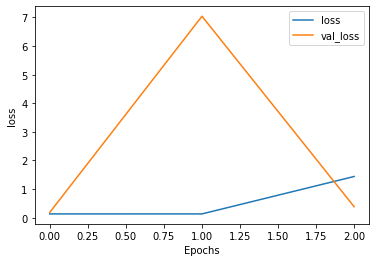

Train on 4569 samples, validate on 1 samples
Epoch 1/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.2340 - accuracy: 0.0063 - val_loss: 0.2196 - val_accuracy: 0.0000e+00
Epoch 2/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1598 - accuracy: 0.0063 - val_loss: 0.1646 - val_accuracy: 0.0000e+00
Epoch 3/3
4569/4569 [==============================] - 13s 3ms/sample - loss: 0.1421 - accuracy: 0.0063 - val_loss: 0.2429 - val_accuracy: 0.0000e+00
prediction2_MSE = tf.Tensor(-11139.71988587157, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-11326.324606361937, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4993.951868839313, shape=(), dtype=float64)
prediction2_MSE = tf.Tensor(-4362.8022446632285, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-05-15~2020-05-15
accuracy1 =  tf.Tensor(0.0, shape=(), dtype=float64)
accuracy2 =  tf.Tensor(1.0, shape=(), dtype=float64)


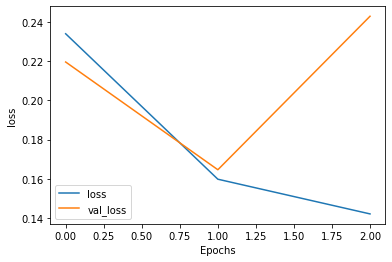

In [16]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []


while True:

    gc.collect()
    
    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)
    
    # input_size, columns reset
    input_size = len(df.columns) - len(remove_columns)
    input_columns = df.columns.copy()

    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

    #model.compile(optimizer='adam',
    #          loss=loss_fn)
    #          #callbacks=[cp-callback]
    #          #metrics=['accuracy'])
    
    # the firs training dataset
    train_x = train_x[:train_end_idx]
    train_y = train_y[:train_end_idx]    
    
    # train model1
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1)
    model1.load_weights(checkpoint_path)
    history = model1.fit(train_x, train_y, batch_size=batch_size, epochs=3, callbacks=[early_stopping], validation_data=(test_x, test_y))
    model1.save_weights(checkpoint_path)
    
    # model2를 위한 test data 생성
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < batch_size:
        m2_current_test_end = test_end
    else:
        m2_current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + batch_size - 1, 'date']
    m2_test_data = prepro.get_test_dataset(df, target_column, remove_columns, 
                                         current_test_start, m2_current_test_end,
                                         future_day, n_timestep, time_interval)    
    m2_test_x, m2_test_y = prepro.get_LSTM_dataset(m2_test_data, n_timestep, time_interval, input_size, future_day)

    # train model2
    early_stopping2 = learn.EarlyStopping(patience=2, verbose=1)    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    iter = epochs
    basic_epochs = tf.cast(epochs / 5, dtype=tf.int32)    
    for iteration in range(iter):
        batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)
        
        gradients2 = gradient2(model1, model2, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))
        if iteration % 100 == 0:
            loss2 = loss_fn_model2(model1, model2, m2_test_x, m2_test_y)
            print('prediction2_MSE =', loss2)
            
        if iteration > iter / 2 and early_stopping2.validate(loss2)==True:
            break    
    
    if iter > basic_epochs: iter -= basic_epochs
    if iter < basic_epochs: iter = basic_epochs
    
    print('test dates ' + current_test_start + "~" + current_test_end)
    
    updown = np.sign(test_y[:, -1, 0]).reshape((-1))       
    
    #단순 예측
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    #prediction_MSE = sum(test_y[:, -1, 0] - prediction[:, -1, 0]).reshape((-1))**2/len(test_y)
    #print('prediction_MSE =', prediction_MSE)

    #수익률 평균, 표준편차에 기반 투자 배분을 고려한 예측
    prediction2 = test_model2(model1, model2, test_x, test_y)
    #prediction_MSE = keras.losses.MSE(updown, prediction2)
    #print('prediction_MSE =', prediction_MSE)
    
    #calculate accuracy 
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('accuracy1 = ', accu)
    
    temp = tf.math.multiply(updown, prediction2)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('accuracy2 = ', accu)    
    
    plot_graphs(history, 'loss')
    
    test_prediction1.append(prediction1)
    test_prediction2.append(prediction2)
    
    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_start = df.loc[prepro.date_to_index(df, current_train_start) + trans_day, 'date']
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']

In [17]:
t1 = np.concatenate(test_prediction1)
t2 = np.concatenate(test_prediction2)

In [18]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)

# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [19]:
updown = np.sign(test_y[:, -1, 0]).reshape((-1))
#calculate prediction1 accuracy
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('accuracy = ', accu)

accuracy =  tf.Tensor(0.49258160237388726, shape=(), dtype=float64)


In [20]:
#calculate prediction2 accuracy
temp = tf.math.multiply(updown, t2.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('accuracy = ', accu)

accuracy =  tf.Tensor(0.47477744807121663, shape=(), dtype=float64)


In [21]:
import learn
from learn import GenerateResult

In [22]:
result = GenerateResult(t1, t2, test_y[:, -1, 0].reshape(-1), test_dates, n_timestep, future_day, trans_day)

In [23]:
#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)

info : ddaeryuble2-1_kospi200f_reinfo_809_100_1_2_0.499
MSE : 5.6042 , Accuracy : 0.499
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/ddaeryuble2-1_kospi200f_reinfo_809_100_1_2_0.499/assets


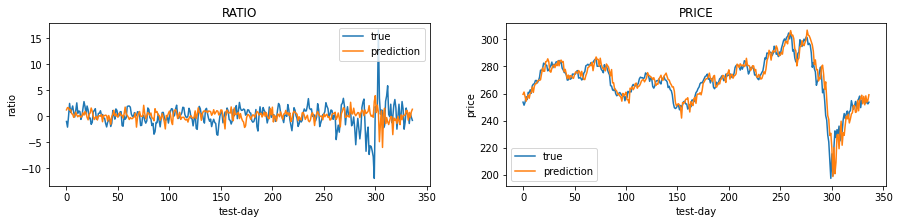

In [24]:
result.evaluation()
result.table()
result.save_result(model_name,item_name,n_unit,target_type,batch_size, n_timestep,time_interval, epochs, alpha, comment)
result.save_visualization()
result.save_model(model2)

In [25]:
    """
    # 변동성 학습
    prediction = learn.predict_batch_test(model, test_x, len(test_x))[:, -1, -1].reshape((-1))
    real = tf.cast(test_y[:, -1, -1].reshape((-1)), tf.float32)
    v_model = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
    optimizer = tf.keras.optimizers.Adam()
    for i in range(20):
        with tf.GradientTape() as tape:
            v_loss = models.loss_prediction_interval(v_model, test_x, prediction, real)
        gradients = tape.gradient(v_loss, v_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, v_model.trainable_variables))
    cnt = 0
    std = tf.reshape(v_model(test_x, training=False)[:, -1, -1], [-1])
    for i in range(len(real)):
        if real[i] > prediction[i] - 1.96 * std[i] and real[i] < prediction[i] + 1.96 * std[i]:
                   cnt += 1
      
    #test_prediction.append(learn.predict_batch_test(model, test_x, len(test_x))) 
    if first_trans:
        test_prediction = prediction
        test_target = test_y
    else:
        test_prediction = np.concatenate([test_prediction, prediction], axis=0)
        test_target = np.concatenate([test_target, test_y], axis=0)
    first_trans = False
    
    test_prediction_x = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
    test_target_y = np.concatenate(test_target, axis=0).reshape((-1, n_timestep, 1))
    
    expected_diff = tf.math.reduce_mean(test_target_y - test_prediction_x)
    #std_diff = tf.math.reduce_std(test_target_y - test_prediction_x)
    std_diff = 1.6
    
    test_prediction = np.a
    """

'\n# 변동성 학습\nprediction = learn.predict_batch_test(model, test_x, len(test_x))[:, -1, -1].reshape((-1))\nreal = tf.cast(test_y[:, -1, -1].reshape((-1)), tf.float32)\nv_model = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)\noptimizer = tf.keras.optimizers.Adam()\nfor i in range(20):\n    with tf.GradientTape() as tape:\n        v_loss = models.loss_prediction_interval(v_model, test_x, prediction, real)\n    gradients = tape.gradient(v_loss, v_model.trainable_variables)\n    optimizer.apply_gradients(zip(gradients, v_model.trainable_variables))\ncnt = 0\nstd = tf.reshape(v_model(test_x, training=False)[:, -1, -1], [-1])\nfor i in range(len(real)):\n    if real[i] > prediction[i] - 1.96 * std[i] and real[i] < prediction[i] + 1.96 * std[i]:\n               cnt += 1\n  \n#test_prediction.append(learn.predict_batch_test(model, test_x, len(test_x))) \nif first_trans:\n    test_prediction = prediction\n    test_target = test_y\nelse:\n    test_prediction = np.